In [1]:
import json
import requests
import websockets
from requests import Session
import pandas as pd
import time
import hashlib
import hmac
import base64
import sys
import numpy as np
import matplotlib.pyplot as plt
inf = sys.maxsize

In [2]:
spotPrices = []
futurePrices = []
differences = []

In [3]:
url = 'https://api.kucoin.com/api/v1/bullet-public'

In [4]:
x = requests.post(url)

In [5]:
cjson = json.loads(x.text)

In [6]:
endpoint = cjson['data']['instanceServers'][0]['endpoint']
token = cjson['data']['token']

In [7]:
multi = {"id": "1Jpg30DEdU", "type": "openTunnel", "newTunnelId": "bt1", "response": False}
# command used to open tunnel

In [8]:
multi_spotEth = {"id": "1JpoPamgFM",
             "type": "subscribe",
             "topic": "/market/ticker:ETH-USDT",
             "tunnelId": "bt1", "response": False}
# subscriptions to websocket with tunnelID attached

In [9]:
multi_futureEth = {"id": 1545910660740,                          
                "type": "subscribe",
                "topic": "/contractMarket/tickerV2:ETHUSDTM",
                "tunnelId": "bt1", "response": False}
# subscriptions to websocket with tunnelID attached

In [10]:
import sys
sys.path.append('..')
import classified

# for future api
fapi_passphrase = classified.FPASSPHRASE
fapi_key = classified.FKEY
fapi_secret = classified.FSECRET
# for spot api
api_passphrase = classified.SPASSPHRASE
api_key = classified.SKEY
api_secret = classified.SSECRET

session = Session()

In [11]:
def auth(method, endpoint):
    now = int(time.time() * 1000)
    str_to_sign = str(now) + method.upper() + endpoint
    signature = base64.b64encode(
        hmac.new(api_secret.encode('utf-8'), str_to_sign.encode('utf-8'), hashlib.sha256).digest())
    passphrase = base64.b64encode(hmac.new(api_secret.encode('utf-8'), api_passphrase.encode('utf-8'), hashlib.sha256).digest())
    headers = {
        "KC-API-SIGN": signature,
        "KC-API-TIMESTAMP": str(now),
        "KC-API-KEY": api_key,
        "KC-API-PASSPHRASE": passphrase,
        "KC-API-KEY-VERSION": '2',
        "Content-Type": "application/json"
    }
    return headers

In [12]:
class executeTrade:
    
    def spotOrder(self, side, symbol, price, size):
        url = 'https://api.kucoin.com/api/v1/orders'
        now = int(time.time() * 1000)
        data = {"clientOid": "01", "side": side, "symbol": symbol, "price": price,"size": size}
        data_json = json.dumps(data)
        str_to_sign = str(now) + 'POST' + '/api/v1/orders' + data_json
        signature = base64.b64encode(
            hmac.new(api_secret.encode('utf-8'), str_to_sign.encode('utf-8'), hashlib.sha256).digest())
        passphrase = base64.b64encode(
            hmac.new(api_secret.encode('utf-8'), api_passphrase.encode('utf-8'), hashlib.sha256).digest())
        headers = {
            "KC-API-SIGN": signature,
            "KC-API-TIMESTAMP": str(now),
            "KC-API-KEY": api_key,
            "KC-API-PASSPHRASE": passphrase,
            "KC-API-KEY-VERSION": '2',
            "Content-Type": "application/json" # specifying content type or using json=data in request
        }
        response = session.post(url, headers=headers, data=data_json)
        print(response.status_code)
        print(response.json())
        
    def futureOrder(self, side, symbol, leverage, price, size):
        url = 'https://api-futures.kucoin.com/api/v1/orders'
        now = int(time.time() * 1000)
        data = {"clientOid": "02", "side": side, "symbol": symbol, "leverage": leverage, "price": price,"size": size}
        data_json = json.dumps(data)
        str_to_sign = str(now) + 'POST' + '/api/v1/orders' + data_json
        signature = base64.b64encode(
            hmac.new(fapi_secret.encode('utf-8'), str_to_sign.encode('utf-8'), hashlib.sha256).digest())
        passphrase = base64.b64encode(
            hmac.new(fapi_secret.encode('utf-8'), fapi_passphrase.encode('utf-8'), hashlib.sha256).digest())
        headers = {
            "KC-API-SIGN": signature,
            "KC-API-TIMESTAMP": str(now),
            "KC-API-KEY": fapi_key,
            "KC-API-PASSPHRASE": passphrase,
            "KC-API-KEY-VERSION": '2',
            "Content-Type": "application/json" # specifying content type or using json=data in request
        }
        response = session.post(url, headers=headers, data=data_json)
        print(response.status_code)
        print(response.json())
        
trade = executeTrade()

In [13]:
class openClosePostion:
    
#     def arbOpen(self, spotPrice, futurePrice):
#         trade.spotOrder("buy", "ETH-USDT", spotPrice, "0.01")
#         trade.futureOrder("sell", "ETHUSDTM", "1", futurePrice, "1")
#         #trade.marekt("buy/sell", "tradingPair", "leverage", "limitPrice", "size")
    
    def arbOpen(self):
        trade.spotOrder("buy", "ETH-USDT", "500", "0.01")
        trade.futureOrder("sell", "ETHUSDTM", "1", "986", "1")
        #trade.marekt("buy/sell", "tradingPair", "leverage", "limitPrice", "size")
        
    def arbClose(self):
        trade.spotOrder("sell", "ETH-USDT", spotPrice, "0.01")
        trade.futureOrder("buy", "ETHUSDTM", "1", futurePrice, "1")
        #trade.marekt("buy/sell", "tradingPair", "leverage", "limitPrice", "size")
        
arb = openClosePostion()

In [53]:
spotPrices.clear()
futurePrices.clear()
async with websockets.connect(endpoint+"?token="+token) as conn:
    await conn.send(json.dumps(multi))  # initial open tunel command
    res = await conn.recv()
    
    await conn.send(json.dumps(multi_spotEth)) # send tunnel subscription
    res = await conn.recv()
    await conn.send(json.dumps(multi_futureEth))  # send tunnel subscription
    res = await conn.recv()
    
    counter = 0
    spotPrice = 0
    futurePrice = 0
    while True and counter < inf:
        res = await conn.recv()
        vals = json.loads(res)

        if (vals['topic']) == '/contractMarket/tickerV2:ETHUSDTM':
#             print(f"Future Price is: {vals['data']['bestAskPrice']}")
            futurePrice = float(vals['data']['bestAskPrice'])
            futurePrices.append(futurePrice)

        elif (vals['topic']) == '/market/ticker:ETH-USDT':
#             print(f"Spot Price is: {vals['data']['bestAsk']}")
            spotPrice = float(vals['data']['bestAsk'])
            spotPrices.append(spotPrice)
        
        difference = spotPrice - futurePrice
        differences.append(difference)
        print(spotPrice - futurePrice)
        print(counter)
        
        # OPEN POSTION
        if spotPrice - futurePrice > 1 and futurePrice != 0 and spotPrice != 0:
            print('Long Future and Short Spot')
            
        elif futurePrice - spotPrice > 1 and futurePrice != 0 and spotPrice != 0:
            print('Long Spot and Short Future')
#             arb.arbOpen(spotPrice, futurePrice)
            
            
        counter += 1
    eth_tunnel = {"id": "1JpoPamgFM", "type": "closeTunnel", "tunnelId": "bt1", "response": False}            
    btc_tunnel = {"id": "1JpoPamgFN", "type": "closeTunnel", "tunnelId": "bt1", "response": False}
    await conn.send(json.dumps(eth_tunnel))
    await conn.send(json.dumps(btc_tunnel))
    await conn.close()

-1637.6
0
0.19000000000005457
1
0.19000000000005457
2
0.19000000000005457
3
0.19000000000005457
4
0.19000000000005457
5
0.19000000000005457
6
0.19000000000005457
7
0.19000000000005457
8
0.19000000000005457
9
0.19000000000005457
10
0.19000000000005457
11
0.19000000000005457
12
0.19000000000005457
13
0.19000000000005457
14
0.19000000000005457
15
0.19000000000005457
16
0.19000000000005457
17
0.41000000000008185
18
0.41000000000008185
19
0.41000000000008185
20
0.41000000000008185
21
0.41000000000008185
22
0.41000000000008185
23
0.41000000000008185
24
0.41000000000008185
25
0.41000000000008185
26
0.41000000000008185
27
0.41000000000008185
28
0.41000000000008185
29
0.41000000000008185
30
0.41000000000008185
31
0.41000000000008185
32
0.7100000000000364
33
0.7100000000000364
34
0.7100000000000364
35
0.7100000000000364
36
0.7100000000000364
37
0.7100000000000364
38
0.7100000000000364
39
0.7100000000000364
40
0.7100000000000364
41
0.7100000000000364
42
0.7100000000000364
43
0.7100000000000364
44

0.4099999999998545
371
0.4099999999998545
372
0.4099999999998545
373
0.4099999999998545
374
0.4099999999998545
375
0.4099999999998545
376
0.4099999999998545
377
0.4099999999998545
378
0.4099999999998545
379
0.4099999999998545
380
0.4099999999998545
381
0.4099999999998545
382
0.4099999999998545
383
0.4099999999998545
384
0.4099999999998545
385
0.4099999999998545
386
0.4099999999998545
387
0.4099999999998545
388
0.4099999999998545
389
0.4099999999998545
390
0.4099999999998545
391
0.4099999999998545
392
0.4099999999998545
393
0.4099999999998545
394
0.4099999999998545
395
0.4099999999998545
396
0.4099999999998545
397
0.4099999999998545
398
0.4099999999998545
399
0.4099999999998545
400
0.4099999999998545
401
0.4099999999998545
402
0.4099999999998545
403
0.4099999999998545
404
0.4099999999998545
405
0.4099999999998545
406
0.4099999999998545
407
0.4099999999998545
408
0.4099999999998545
409
0.4099999999998545
410
0.4099999999998545
411
0.4099999999998545
412
0.4099999999998545
413
0.409999999

0.7400000000000091
728
0.7400000000000091
729
0.7400000000000091
730
0.7400000000000091
731
0.7400000000000091
732
0.7400000000000091
733
0.7400000000000091
734
0.7400000000000091
735
0.7400000000000091
736
0.7400000000000091
737
0.7400000000000091
738
0.7400000000000091
739
0.7400000000000091
740
0.7400000000000091
741
0.7400000000000091
742
0.7400000000000091
743
0.7400000000000091
744
0.7400000000000091
745
0.7400000000000091
746
0.7400000000000091
747
0.7400000000000091
748
0.7400000000000091
749
0.7400000000000091
750
0.7400000000000091
751
0.7400000000000091
752
0.7400000000000091
753
0.7400000000000091
754
0.7400000000000091
755
0.7400000000000091
756
0.7400000000000091
757
0.7400000000000091
758
0.7400000000000091
759
0.7400000000000091
760
0.7400000000000091
761
0.7400000000000091
762
0.7400000000000091
763
0.7400000000000091
764
0.7400000000000091
765
0.7400000000000091
766
0.7400000000000091
767
0.6499999999998636
768
0.6499999999998636
769
0.6499999999998636
770
0.649999999

0.36000000000012733
1076
0.36000000000012733
1077
0.36000000000012733
1078
0.36000000000012733
1079
0.36000000000012733
1080
0.36000000000012733
1081
0.36000000000012733
1082
0.36000000000012733
1083
0.36000000000012733
1084
0.36000000000012733
1085
0.36000000000012733
1086
0.36000000000012733
1087
0.36000000000012733
1088
0.36000000000012733
1089
0.36000000000012733
1090
0.36000000000012733
1091
0.36000000000012733
1092
0.36000000000012733
1093
0.36000000000012733
1094
0.36000000000012733
1095
0.36000000000012733
1096
0.36000000000012733
1097
0.36000000000012733
1098
0.36000000000012733
1099
0.36000000000012733
1100
0.36000000000012733
1101
0.4600000000000364
1102
0.2999999999999545
1103
0.05999999999994543
1104
0.10999999999989996
1105
0.16000000000008185
1106
0.12000000000011823
1107
-0.009999999999990905
1108
-0.009999999999990905
1109
-0.009999999999990905
1110
0.4900000000000091
1111
0.4900000000000091
1112
0.4900000000000091
1113
0.4900000000000091
1114
0.5399999999999636
1115
0

1.0299999999999727
1359
Long Future and Short Spot
1.0299999999999727
1360
Long Future and Short Spot
0.9300000000000637
1361
0.9300000000000637
1362
0.9300000000000637
1363
0.9300000000000637
1364
0.9300000000000637
1365
0.9300000000000637
1366
0.8799999999998818
1367
0.8799999999998818
1368
0.8799999999998818
1369
0.8799999999998818
1370
0.6800000000000637
1371
0.6800000000000637
1372
0.5799999999999272
1373
0.5799999999999272
1374
0.6800000000000637
1375
0.6800000000000637
1376
0.5799999999999272
1377
0.9700000000000273
1378
0.9200000000000728
1379
1.0199999999999818
1380
Long Future and Short Spot
1.0199999999999818
1381
Long Future and Short Spot
1.0199999999999818
1382
Long Future and Short Spot
1.0199999999999818
1383
Long Future and Short Spot
1.0199999999999818
1384
Long Future and Short Spot
1.0199999999999818
1385
Long Future and Short Spot
1.0199999999999818
1386
Long Future and Short Spot
1.0199999999999818
1387
Long Future and Short Spot
0.9200000000000728
1388
0.92000000

0.20000000000004547
1683
0.20000000000004547
1684
0.20000000000004547
1685
0.20000000000004547
1686
0.3500000000001364
1687
0.3500000000001364
1688
0.3500000000001364
1689
0.3500000000001364
1690
0.3500000000001364
1691
0.3500000000001364
1692
0.3500000000001364
1693
0.3500000000001364
1694
0.3500000000001364
1695
0.3500000000001364
1696
0.3500000000001364
1697
0.3500000000001364
1698
0.3500000000001364
1699
0.3500000000001364
1700
0.3500000000001364
1701
0.3500000000001364
1702
0.3500000000001364
1703
0.8100000000001728
1704
0.8100000000001728
1705
0.8100000000001728
1706
0.8100000000001728
1707
0.8100000000001728
1708
0.8100000000001728
1709
0.8100000000001728
1710
0.8100000000001728
1711
0.8100000000001728
1712
0.8100000000001728
1713
0.8100000000001728
1714
0.8100000000001728
1715
0.8100000000001728
1716
0.8100000000001728
1717
0.8100000000001728
1718
0.8100000000001728
1719
0.8100000000001728
1720
0.8100000000001728
1721
0.8100000000001728
1722
0.8100000000001728
1723
0.7100000000

0.4500000000000455
2020
0.4500000000000455
2021
0.4500000000000455
2022
0.4500000000000455
2023
0.4500000000000455
2024
0.4500000000000455
2025
0.4500000000000455
2026
0.4500000000000455
2027
0.4500000000000455
2028
0.4500000000000455
2029
0.4500000000000455
2030
0.4500000000000455
2031
0.4500000000000455
2032
0.4500000000000455
2033
0.4500000000000455
2034
0.4500000000000455
2035
0.4500000000000455
2036
0.4500000000000455
2037
0.4500000000000455
2038
0.4500000000000455
2039
0.2999999999999545
2040
0.2999999999999545
2041
-0.009999999999990905
2042
-0.009999999999990905
2043
-0.31999999999993634
2044
-0.31999999999993634
2045
-0.22000000000002728
2046
-0.22000000000002728
2047
-0.22000000000002728
2048
-0.22000000000002728
2049
-0.009999999999990905
2050
-0.009999999999990905
2051
-0.009999999999990905
2052
-0.009999999999990905
2053
-0.01999999999998181
2054
0.13000000000010914
2055
-0.16999999999984539
2056
-0.16999999999984539
2057
-0.16999999999984539
2058
0.13000000000010914
2059


0.8099999999999454
2358
0.8099999999999454
2359
0.8099999999999454
2360
0.8099999999999454
2361
0.8099999999999454
2362
0.8099999999999454
2363
0.8099999999999454
2364
0.8099999999999454
2365
0.8099999999999454
2366
0.8099999999999454
2367
0.8099999999999454
2368
0.8099999999999454
2369
0.8099999999999454
2370
0.8099999999999454
2371
0.8099999999999454
2372
0.8099999999999454
2373
0.8099999999999454
2374
0.8099999999999454
2375
0.8099999999999454
2376
0.8099999999999454
2377
0.8099999999999454
2378
0.8099999999999454
2379
0.8099999999999454
2380
0.8099999999999454
2381
0.8099999999999454
2382
0.8099999999999454
2383
0.8099999999999454
2384
0.8099999999999454
2385
0.8099999999999454
2386
0.8099999999999454
2387
0.8099999999999454
2388
0.8099999999999454
2389
0.8099999999999454
2390
0.8099999999999454
2391
0.8099999999999454
2392
0.8099999999999454
2393
0.8099999999999454
2394
0.8099999999999454
2395
0.8099999999999454
2396
0.8099999999999454
2397
0.8099999999999454
2398
0.80999999999994

1.0299999999999727
2655
Long Future and Short Spot
1.0299999999999727
2656
Long Future and Short Spot
1.0299999999999727
2657
Long Future and Short Spot
1.0299999999999727
2658
Long Future and Short Spot
1.0299999999999727
2659
Long Future and Short Spot
1.0299999999999727
2660
Long Future and Short Spot
1.0299999999999727
2661
Long Future and Short Spot
1.0299999999999727
2662
Long Future and Short Spot
1.0299999999999727
2663
Long Future and Short Spot
1.0299999999999727
2664
Long Future and Short Spot
1.0299999999999727
2665
Long Future and Short Spot
1.0299999999999727
2666
Long Future and Short Spot
1.0299999999999727
2667
Long Future and Short Spot
1.0299999999999727
2668
Long Future and Short Spot
1.0299999999999727
2669
Long Future and Short Spot
1.0299999999999727
2670
Long Future and Short Spot
1.0299999999999727
2671
Long Future and Short Spot
1.0299999999999727
2672
Long Future and Short Spot
1.0299999999999727
2673
Long Future and Short Spot
1.0299999999999727
2674
Long Fu

0.43000000000006366
2959
0.43000000000006366
2960
0.43000000000006366
2961
0.43000000000006366
2962
0.43000000000006366
2963
0.43000000000006366
2964
0.43000000000006366
2965
0.43000000000006366
2966
0.43000000000006366
2967
0.43000000000006366
2968
0.43000000000006366
2969
0.43000000000006366
2970
0.43000000000006366
2971
0.43000000000006366
2972
0.43000000000006366
2973
0.43000000000006366
2974
0.43000000000006366
2975
0.43000000000006366
2976
0.43000000000006366
2977
0.43000000000006366
2978
0.43000000000006366
2979
0.43000000000006366
2980
0.43000000000006366
2981
0.43000000000006366
2982
0.43000000000006366
2983
0.43000000000006366
2984
0.43000000000006366
2985
0.43000000000006366
2986
0.43000000000006366
2987
0.43000000000006366
2988
0.43000000000006366
2989
0.43000000000006366
2990
0.43000000000006366
2991
0.43000000000006366
2992
0.43000000000006366
2993
0.43000000000006366
2994
0.43000000000006366
2995
0.43000000000006366
2996
0.2300000000000182
2997
0.2300000000000182
2998
0.

0.8600000000001273
3300
0.8600000000001273
3301
0.4900000000000091
3302
0.4900000000000091
3303
0.4900000000000091
3304
0.4900000000000091
3305
0.4900000000000091
3306
0.4900000000000091
3307
0.4900000000000091
3308
0.4900000000000091
3309
0.4900000000000091
3310
0.4900000000000091
3311
0.4900000000000091
3312
0.4900000000000091
3313
0.4900000000000091
3314
0.4900000000000091
3315
0.4900000000000091
3316
0.4900000000000091
3317
0.4900000000000091
3318
0.4900000000000091
3319
0.4900000000000091
3320
0.4900000000000091
3321
0.4900000000000091
3322
0.4900000000000091
3323
0.4900000000000091
3324
0.4900000000000091
3325
0.4900000000000091
3326
0.4900000000000091
3327
0.4900000000000091
3328
0.4900000000000091
3329
0.4900000000000091
3330
0.4900000000000091
3331
0.4900000000000091
3332
0.4900000000000091
3333
0.4900000000000091
3334
0.4900000000000091
3335
0.4900000000000091
3336
0.4900000000000091
3337
0.4900000000000091
3338
0.4900000000000091
3339
0.4900000000000091
3340
0.49000000000000

0.7000000000000455
3649
0.7000000000000455
3650
0.7000000000000455
3651
0.7000000000000455
3652
0.7000000000000455
3653
0.7000000000000455
3654
0.7000000000000455
3655
0.7000000000000455
3656
0.7000000000000455
3657
0.7000000000000455
3658
0.7000000000000455
3659
0.7000000000000455
3660
0.7000000000000455
3661
0.7000000000000455
3662
0.7000000000000455
3663
0.7000000000000455
3664
0.7000000000000455
3665
0.7000000000000455
3666
0.7000000000000455
3667
0.7000000000000455
3668
0.7000000000000455
3669
0.7000000000000455
3670
0.7000000000000455
3671
0.7000000000000455
3672
0.7000000000000455
3673
0.7000000000000455
3674
0.7000000000000455
3675
0.7000000000000455
3676
0.7000000000000455
3677
0.7000000000000455
3678
0.7000000000000455
3679
0.7000000000000455
3680
0.7000000000000455
3681
0.7000000000000455
3682
0.7000000000000455
3683
0.7000000000000455
3684
0.7000000000000455
3685
0.9400000000000546
3686
0.9400000000000546
3687
0.9400000000000546
3688
0.9400000000000546
3689
0.94000000000005

0.6599999999998545
3984
0.6599999999998545
3985
0.6599999999998545
3986
0.6599999999998545
3987
0.6599999999998545
3988
0.6599999999998545
3989
0.6599999999998545
3990
0.6599999999998545
3991
0.6599999999998545
3992
0.6599999999998545
3993
0.6599999999998545
3994
0.6599999999998545
3995
0.6599999999998545
3996
0.6599999999998545
3997
0.6599999999998545
3998
0.6599999999998545
3999
0.6599999999998545
4000
0.6599999999998545
4001
0.6599999999998545
4002
0.6599999999998545
4003
0.6599999999998545
4004
0.7599999999999909
4005
0.7599999999999909
4006
0.7599999999999909
4007
0.7599999999999909
4008
0.7599999999999909
4009
0.7599999999999909
4010
0.7599999999999909
4011
0.7599999999999909
4012
0.7599999999999909
4013
0.7599999999999909
4014
0.7599999999999909
4015
0.7599999999999909
4016
0.7599999999999909
4017
0.7599999999999909
4018
0.7599999999999909
4019
0.7599999999999909
4020
0.7599999999999909
4021
0.7599999999999909
4022
0.7599999999999909
4023
0.7599999999999909
4024
0.75999999999999

1.0199999999999818
4270
Long Future and Short Spot
1.0199999999999818
4271
Long Future and Short Spot
1.0199999999999818
4272
Long Future and Short Spot
0.8300000000001546
4273
0.8300000000001546
4274
0.8300000000001546
4275
0.8300000000001546
4276
0.8300000000001546
4277
0.8300000000001546
4278
0.8300000000001546
4279
0.8300000000001546
4280
0.8300000000001546
4281
0.8300000000001546
4282
0.8300000000001546
4283
0.8300000000001546
4284
0.5099999999999909
4285
0.5099999999999909
4286
0.44000000000005457
4287
0.44000000000005457
4288
0.44000000000005457
4289
0.6900000000000546
4290
0.6700000000000728
4291
0.6700000000000728
4292
0.7200000000000273
4293
0.6200000000001182
4294
0.6200000000001182
4295
0.6200000000001182
4296
0.6200000000001182
4297
0.6200000000001182
4298
0.6200000000001182
4299
0.6200000000001182
4300
0.6200000000001182
4301
0.6200000000001182
4302
0.6200000000001182
4303
0.6200000000001182
4304
0.6200000000001182
4305
0.6200000000001182
4306
0.6200000000001182
4307
0.62

0.5499999999999545
4614
0.5499999999999545
4615
0.5499999999999545
4616
0.5499999999999545
4617
0.5499999999999545
4618
0.5499999999999545
4619
0.5499999999999545
4620
0.5499999999999545
4621
0.5499999999999545
4622
0.5499999999999545
4623
0.5499999999999545
4624
0.5499999999999545
4625
0.5499999999999545
4626
0.5499999999999545
4627
0.5499999999999545
4628
0.5499999999999545
4629
0.5499999999999545
4630
0.5499999999999545
4631
0.5499999999999545
4632
0.5499999999999545
4633
0.5499999999999545
4634
0.5499999999999545
4635
0.5499999999999545
4636
0.5499999999999545
4637
0.5499999999999545
4638
0.5499999999999545
4639
0.5499999999999545
4640
0.5499999999999545
4641
0.5499999999999545
4642
0.5499999999999545
4643
0.5499999999999545
4644
0.5499999999999545
4645
0.5499999999999545
4646
0.5499999999999545
4647
0.5499999999999545
4648
0.5499999999999545
4649
0.5499999999999545
4650
0.5499999999999545
4651
0.5499999999999545
4652
0.5499999999999545
4653
0.5499999999999545
4654
0.54999999999995

0.5800000000001546
4948
0.08000000000015461
4949
0.08000000000015461
4950
0.01999999999998181
4951
0.16999999999984539
4952
0.16999999999984539
4953
0.2199999999997999
4954
0.2199999999997999
4955
0.2199999999997999
4956
0.2199999999997999
4957
0.2199999999997999
4958
0.2199999999997999
4959
0.2199999999997999
4960
0.2199999999997999
4961
0.2199999999997999
4962
0.2199999999997999
4963
0.2199999999997999
4964
0.2199999999997999
4965
0.2699999999999818
4966
0.2699999999999818
4967
0.2699999999999818
4968
0.2699999999999818
4969
0.2699999999999818
4970
0.2699999999999818
4971
0.2699999999999818
4972
0.2699999999999818
4973
0.2699999999999818
4974
0.2699999999999818
4975
0.2699999999999818
4976
0.2699999999999818
4977
0.2699999999999818
4978
0.2699999999999818
4979
0.2699999999999818
4980
0.2699999999999818
4981
0.2699999999999818
4982
0.2699999999999818
4983
0.5500000000001819
4984
0.5500000000001819
4985
0.5500000000001819
4986
0.5500000000001819
4987
0.5500000000001819
4988
0.550000000

1.2200000000000273
5217
Long Future and Short Spot
1.2200000000000273
5218
Long Future and Short Spot
1.0699999999999363
5219
Long Future and Short Spot
1.0699999999999363
5220
Long Future and Short Spot
1.0699999999999363
5221
Long Future and Short Spot
1.0699999999999363
5222
Long Future and Short Spot
1.0699999999999363
5223
Long Future and Short Spot
1.0699999999999363
5224
Long Future and Short Spot
1.0699999999999363
5225
Long Future and Short Spot
1.0699999999999363
5226
Long Future and Short Spot
1.0699999999999363
5227
Long Future and Short Spot
1.0699999999999363
5228
Long Future and Short Spot
1.0699999999999363
5229
Long Future and Short Spot
1.0699999999999363
5230
Long Future and Short Spot
1.0699999999999363
5231
Long Future and Short Spot
1.0699999999999363
5232
Long Future and Short Spot
1.0699999999999363
5233
Long Future and Short Spot
1.0699999999999363
5234
Long Future and Short Spot
1.0699999999999363
5235
Long Future and Short Spot
1.0699999999999363
5236
Long Fu

0.7300000000000182
5466
0.7300000000000182
5467
0.7300000000000182
5468
0.7300000000000182
5469
0.7300000000000182
5470
0.7300000000000182
5471
0.7300000000000182
5472
0.32999999999992724
5473
0.32999999999992724
5474
0.20000000000004547
5475
0.4500000000000455
5476
0.2300000000000182
5477
0.2300000000000182
5478
0.15000000000009095
5479
0.15000000000009095
5480
0.15000000000009095
5481
0.20000000000004547
5482
0.18000000000006366
5483
0.18000000000006366
5484
0.18000000000006366
5485
0.18000000000006366
5486
0.18000000000006366
5487
0.18000000000006366
5488
0.18000000000006366
5489
0.18000000000006366
5490
0.18000000000006366
5491
0.05999999999994543
5492
0.05999999999994543
5493
0.05999999999994543
5494
0.16000000000008185
5495
0.16000000000008185
5496
0.16000000000008185
5497
0.16000000000008185
5498
0.16000000000008185
5499
0.16000000000008185
5500
0.16000000000008185
5501
0.16000000000008185
5502
0.30999999999994543
5503
0.30999999999994543
5504
0.30999999999994543
5505
0.30999999

0.5900000000001455
5805
0.5900000000001455
5806
0.5900000000001455
5807
0.5900000000001455
5808
0.5900000000001455
5809
0.5900000000001455
5810
0.5900000000001455
5811
0.5900000000001455
5812
0.5900000000001455
5813
0.5900000000001455
5814
0.5900000000001455
5815
0.5900000000001455
5816
0.5900000000001455
5817
0.5900000000001455
5818
0.5900000000001455
5819
0.5900000000001455
5820
0.5900000000001455
5821
0.5900000000001455
5822
0.5900000000001455
5823
0.5900000000001455
5824
0.5900000000001455
5825
0.5900000000001455
5826
0.5900000000001455
5827
0.5900000000001455
5828
0.5900000000001455
5829
0.5900000000001455
5830
0.5900000000001455
5831
0.5900000000001455
5832
0.5900000000001455
5833
0.5900000000001455
5834
0.5900000000001455
5835
0.5900000000001455
5836
0.5900000000001455
5837
0.5900000000001455
5838
0.5900000000001455
5839
0.5900000000001455
5840
0.5900000000001455
5841
0.5900000000001455
5842
0.5900000000001455
5843
0.5900000000001455
5844
0.5900000000001455
5845
0.59000000000014

0.9500000000000455
6155
0.9500000000000455
6156
0.9500000000000455
6157
0.9500000000000455
6158
0.9500000000000455
6159
0.9500000000000455
6160
0.9500000000000455
6161
0.9500000000000455
6162
0.9500000000000455
6163
0.9500000000000455
6164
0.9500000000000455
6165
0.9500000000000455
6166
0.9500000000000455
6167
0.9500000000000455
6168
0.9500000000000455
6169
0.9500000000000455
6170
0.9500000000000455
6171
0.9500000000000455
6172
0.9500000000000455
6173
0.9500000000000455
6174
0.9500000000000455
6175
0.9500000000000455
6176
0.9500000000000455
6177
0.9500000000000455
6178
0.9500000000000455
6179
0.9500000000000455
6180
0.9500000000000455
6181
0.9500000000000455
6182
0.9500000000000455
6183
0.9500000000000455
6184
0.9500000000000455
6185
0.9500000000000455
6186
0.9500000000000455
6187
0.9500000000000455
6188
0.9500000000000455
6189
0.9500000000000455
6190
0.9500000000000455
6191
0.9500000000000455
6192
0.9500000000000455
6193
0.9500000000000455
6194
0.9500000000000455
6195
0.95000000000004

0.44000000000005457
6491
0.44000000000005457
6492
0.44000000000005457
6493
0.44000000000005457
6494
0.44000000000005457
6495
0.44000000000005457
6496
0.44000000000005457
6497
0.44000000000005457
6498
0.44000000000005457
6499
0.44000000000005457
6500
0.44000000000005457
6501
0.44000000000005457
6502
0.44000000000005457
6503
0.44000000000005457
6504
0.44000000000005457
6505
0.44000000000005457
6506
0.44000000000005457
6507
0.44000000000005457
6508
0.44000000000005457
6509
0.44000000000005457
6510
0.44000000000005457
6511
0.44000000000005457
6512
0.44000000000005457
6513
0.44000000000005457
6514
0.44000000000005457
6515
0.44000000000005457
6516
0.44000000000005457
6517
0.44000000000005457
6518
0.44000000000005457
6519
0.44000000000005457
6520
0.44000000000005457
6521
0.44000000000005457
6522
0.44000000000005457
6523
0.44000000000005457
6524
0.44000000000005457
6525
0.44000000000005457
6526
0.7999999999999545
6527
0.7999999999999545
6528
0.7999999999999545
6529
0.7999999999999545
6530
0.79

0.8999999999998636
6839
0.8999999999998636
6840
0.8999999999998636
6841
0.8999999999998636
6842
0.8999999999998636
6843
0.8999999999998636
6844
0.8999999999998636
6845
0.8999999999998636
6846
0.8999999999998636
6847
0.8999999999998636
6848
0.849999999999909
6849
0.9700000000000273
6850
0.9700000000000273
6851
0.9700000000000273
6852
0.9700000000000273
6853
0.9700000000000273
6854
0.9700000000000273
6855
1.2999999999999545
6856
Long Future and Short Spot
0.7000000000000455
6857
0.9900000000000091
6858
0.8899999999998727
6859
0.8899999999998727
6860
0.8899999999998727
6861
0.8899999999998727
6862
0.8899999999998727
6863
0.8899999999998727
6864
0.8899999999998727
6865
0.8899999999998727
6866
0.8899999999998727
6867
0.8899999999998727
6868
0.8899999999998727
6869
0.8899999999998727
6870
0.8899999999998727
6871
0.8899999999998727
6872
0.8899999999998727
6873
0.8899999999998727
6874
0.8899999999998727
6875
0.8899999999998727
6876
0.8899999999998727
6877
0.8899999999998727
6878
0.889999999999

0.5499999999999545
7179
0.5499999999999545
7180
0.5499999999999545
7181
0.5499999999999545
7182
0.5499999999999545
7183
0.5499999999999545
7184
0.5499999999999545
7185
0.5499999999999545
7186
0.5499999999999545
7187
0.5499999999999545
7188
0.5499999999999545
7189
0.5499999999999545
7190
0.5499999999999545
7191
0.5499999999999545
7192
0.5499999999999545
7193
0.5499999999999545
7194
0.5499999999999545
7195
0.5499999999999545
7196
0.5499999999999545
7197
0.5499999999999545
7198
0.5499999999999545
7199
0.5499999999999545
7200
0.5499999999999545
7201
0.5499999999999545
7202
0.5499999999999545
7203
0.5499999999999545
7204
0.5499999999999545
7205
0.5499999999999545
7206
0.5499999999999545
7207
0.5499999999999545
7208
0.5499999999999545
7209
0.5499999999999545
7210
0.5499999999999545
7211
0.5499999999999545
7212
0.5499999999999545
7213
0.5499999999999545
7214
0.5499999999999545
7215
0.5499999999999545
7216
0.5499999999999545
7217
0.5499999999999545
7218
0.5499999999999545
7219
0.54999999999995

0.7899999999999636
7523
0.7899999999999636
7524
0.7899999999999636
7525
0.7899999999999636
7526
0.7899999999999636
7527
0.7899999999999636
7528
0.7899999999999636
7529
0.7899999999999636
7530
0.7899999999999636
7531
0.7899999999999636
7532
0.7899999999999636
7533
0.7899999999999636
7534
0.7899999999999636
7535
0.7899999999999636
7536
0.7899999999999636
7537
0.7899999999999636
7538
0.7899999999999636
7539
0.7899999999999636
7540
0.7899999999999636
7541
0.7899999999999636
7542
0.7899999999999636
7543
0.7899999999999636
7544
0.7899999999999636
7545
0.7899999999999636
7546
0.7899999999999636
7547
0.7899999999999636
7548
0.7899999999999636
7549
0.7899999999999636
7550
0.7899999999999636
7551
0.7899999999999636
7552
0.7899999999999636
7553
0.7899999999999636
7554
0.7899999999999636
7555
0.7899999999999636
7556
0.7899999999999636
7557
0.7899999999999636
7558
0.7899999999999636
7559
0.7899999999999636
7560
0.7899999999999636
7561
0.7899999999999636
7562
0.7899999999999636
7563
0.78999999999996

0.9600000000000364
7837
0.9600000000000364
7838
0.9600000000000364
7839
0.9600000000000364
7840
0.9600000000000364
7841
0.9600000000000364
7842
0.9600000000000364
7843
0.9600000000000364
7844
0.9600000000000364
7845
0.9600000000000364
7846
0.9600000000000364
7847
0.6700000000000728
7848
0.6700000000000728
7849
0.6700000000000728
7850
0.8599999999999
7851
0.8599999999999
7852
1.0199999999999818
7853
Long Future and Short Spot
0.6700000000000728
7854
1.1700000000000728
7855
Long Future and Short Spot
1.1700000000000728
7856
Long Future and Short Spot
1.2200000000000273
7857
Long Future and Short Spot
1.1699999999998454
7858
Long Future and Short Spot
0.7899999999999636
7859
0.7899999999999636
7860
0.7899999999999636
7861
0.7899999999999636
7862
0.7899999999999636
7863
0.7899999999999636
7864
0.7899999999999636
7865
0.75
7866
0.75
7867
0.75
7868
0.75
7869
0.75
7870
0.75
7871
0.75
7872
0.75
7873
0.75
7874
0.75
7875
0.75
7876
0.75
7877
0.75
7878
0.75
7879
0.75
7880
0.75
7881
0.75
7882
0.75


0.6300000000001091
8186
0.6300000000001091
8187
0.6300000000001091
8188
0.6300000000001091
8189
0.6300000000001091
8190
0.6300000000001091
8191
0.6300000000001091
8192
0.6300000000001091
8193
0.6300000000001091
8194
0.6300000000001091
8195
0.6300000000001091
8196
0.6300000000001091
8197
0.6300000000001091
8198
0.6300000000001091
8199
0.6300000000001091
8200
0.6300000000001091
8201
0.6300000000001091
8202
0.6300000000001091
8203
0.6300000000001091
8204
0.6300000000001091
8205
0.6300000000001091
8206
0.6300000000001091
8207
0.6300000000001091
8208
0.6300000000001091
8209
0.6300000000001091
8210
0.6300000000001091
8211
0.6300000000001091
8212
0.6300000000001091
8213
0.6300000000001091
8214
0.6300000000001091
8215
0.6300000000001091
8216
0.6300000000001091
8217
0.6300000000001091
8218
0.6300000000001091
8219
0.6300000000001091
8220
0.6300000000001091
8221
0.6300000000001091
8222
0.6300000000001091
8223
0.6300000000001091
8224
0.6300000000001091
8225
0.6300000000001091
8226
0.63000000000010

0.4700000000000273
8524
0.4700000000000273
8525
0.4700000000000273
8526
0.4700000000000273
8527
0.4700000000000273
8528
0.4700000000000273
8529
0.4700000000000273
8530
0.4700000000000273
8531
0.4700000000000273
8532
0.4700000000000273
8533
0.4700000000000273
8534
0.4700000000000273
8535
0.4700000000000273
8536
0.4700000000000273
8537
0.4700000000000273
8538
0.4700000000000273
8539
0.4700000000000273
8540
0.4700000000000273
8541
0.4700000000000273
8542
0.4700000000000273
8543
0.4700000000000273
8544
0.4700000000000273
8545
0.4700000000000273
8546
0.4700000000000273
8547
0.4700000000000273
8548
0.4700000000000273
8549
0.4700000000000273
8550
0.4700000000000273
8551
0.4700000000000273
8552
0.4700000000000273
8553
0.4700000000000273
8554
0.4700000000000273
8555
0.4700000000000273
8556
0.4700000000000273
8557
0.4700000000000273
8558
0.4700000000000273
8559
0.4700000000000273
8560
0.4700000000000273
8561
0.4700000000000273
8562
0.4700000000000273
8563
0.4700000000000273
8564
0.47000000000002

0.8199999999999363
8866
0.8199999999999363
8867
0.8199999999999363
8868
0.8199999999999363
8869
0.8199999999999363
8870
0.8199999999999363
8871
0.8199999999999363
8872
0.8199999999999363
8873
0.8199999999999363
8874
0.8199999999999363
8875
0.8199999999999363
8876
0.8199999999999363
8877
0.8199999999999363
8878
0.8199999999999363
8879
0.8199999999999363
8880
0.8199999999999363
8881
0.8199999999999363
8882
0.8199999999999363
8883
0.8199999999999363
8884
0.8199999999999363
8885
0.8199999999999363
8886
0.8199999999999363
8887
0.8199999999999363
8888
0.8199999999999363
8889
0.8199999999999363
8890
0.8199999999999363
8891
0.8199999999999363
8892
0.8199999999999363
8893
0.8199999999999363
8894
0.8199999999999363
8895
0.8199999999999363
8896
0.8199999999999363
8897
0.8199999999999363
8898
0.8199999999999363
8899
0.8199999999999363
8900
0.8199999999999363
8901
0.8199999999999363
8902
0.7699999999999818
8903
0.7699999999999818
8904
0.7699999999999818
8905
0.7699999999999818
8906
0.76999999999998

0.5900000000001455
9209
0.5900000000001455
9210
0.5900000000001455
9211
0.5900000000001455
9212
0.5900000000001455
9213
0.5900000000001455
9214
0.5900000000001455
9215
0.5900000000001455
9216
0.5900000000001455
9217
0.5900000000001455
9218
0.5900000000001455
9219
0.5900000000001455
9220
0.5900000000001455
9221
0.6100000000001273
9222
0.6100000000001273
9223
0.6100000000001273
9224
0.6100000000001273
9225
0.6100000000001273
9226
0.6100000000001273
9227
0.6100000000001273
9228
0.6100000000001273
9229
0.6100000000001273
9230
0.6100000000001273
9231
0.6100000000001273
9232
0.6100000000001273
9233
0.6100000000001273
9234
0.6100000000001273
9235
0.6100000000001273
9236
0.6100000000001273
9237
0.6100000000001273
9238
0.6100000000001273
9239
0.7599999999999909
9240
0.7599999999999909
9241
0.7599999999999909
9242
0.7599999999999909
9243
0.7599999999999909
9244
0.7599999999999909
9245
0.7599999999999909
9246
0.7599999999999909
9247
0.7599999999999909
9248
0.7599999999999909
9249
0.75999999999999

0.4099999999998545
9567
0.4099999999998545
9568
0.4099999999998545
9569
0.4099999999998545
9570
0.4099999999998545
9571
0.4099999999998545
9572
0.4099999999998545
9573
0.4099999999998545
9574
0.4099999999998545
9575
0.4099999999998545
9576
0.4099999999998545
9577
0.4099999999998545
9578
0.4099999999998545
9579
0.4099999999998545
9580
0.4099999999998545
9581
0.4099999999998545
9582
0.4099999999998545
9583
0.4099999999998545
9584
0.5699999999999363
9585
0.5699999999999363
9586
0.5699999999999363
9587
0.5699999999999363
9588
0.8399999999999181
9589
0.7899999999999636
9590
0.7899999999999636
9591
0.7899999999999636
9592
0.7899999999999636
9593
0.7899999999999636
9594
0.7899999999999636
9595
0.7899999999999636
9596
0.7899999999999636
9597
0.7899999999999636
9598
0.7899999999999636
9599
0.7899999999999636
9600
0.7899999999999636
9601
0.7899999999999636
9602
0.7899999999999636
9603
0.7899999999999636
9604
0.7899999999999636
9605
0.7899999999999636
9606
0.7899999999999636
9607
0.78999999999996

0.5800000000001546
9888
0.5800000000001546
9889
0.5800000000001546
9890
0.5800000000001546
9891
0.5800000000001546
9892
0.5800000000001546
9893
0.5800000000001546
9894
0.5800000000001546
9895
0.5800000000001546
9896
0.5800000000001546
9897
0.5800000000001546
9898
0.5800000000001546
9899
0.5800000000001546
9900
0.5800000000001546
9901
0.5800000000001546
9902
0.5800000000001546
9903
0.5800000000001546
9904
0.5800000000001546
9905
0.5800000000001546
9906
0.5800000000001546
9907
0.5800000000001546
9908
0.5800000000001546
9909
0.5800000000001546
9910
0.5800000000001546
9911
0.5800000000001546
9912
0.5800000000001546
9913
0.5800000000001546
9914
0.5800000000001546
9915
0.5800000000001546
9916
0.30999999999994543
9917
0.4099999999998545
9918
0.4099999999998545
9919
0.4099999999998545
9920
0.4099999999998545
9921
0.4099999999998545
9922
0.4099999999998545
9923
0.4099999999998545
9924
0.4099999999998545
9925
0.4099999999998545
9926
0.4099999999998545
9927
0.4099999999998545
9928
0.4099999999998

0.6199999999998909
10235
0.6199999999998909
10236
0.6199999999998909
10237
0.6199999999998909
10238
0.6199999999998909
10239
0.6199999999998909
10240
0.6199999999998909
10241
0.6199999999998909
10242
0.6199999999998909
10243
0.6199999999998909
10244
0.6199999999998909
10245
0.6199999999998909
10246
0.6199999999998909
10247
0.6199999999998909
10248
0.6199999999998909
10249
0.6199999999998909
10250
0.6199999999998909
10251
0.31999999999993634
10252
0.31999999999993634
10253
0.31999999999993634
10254
0.31999999999993634
10255
0.31999999999993634
10256
0.37000000000011823
10257
0.37000000000011823
10258
0.37000000000011823
10259
0.37000000000011823
10260
0.37000000000011823
10261
0.4900000000000091
10262
0.4900000000000091
10263
0.4900000000000091
10264
0.4900000000000091
10265
0.4900000000000091
10266
0.4900000000000091
10267
0.4900000000000091
10268
0.4900000000000091
10269
0.4900000000000091
10270
0.4900000000000091
10271
0.4900000000000091
10272
0.4900000000000091
10273
0.4900000000000

0.44000000000005457
10566
0.44000000000005457
10567
0.44000000000005457
10568
0.44000000000005457
10569
0.44000000000005457
10570
0.44000000000005457
10571
0.44000000000005457
10572
0.44000000000005457
10573
0.44000000000005457
10574
0.44000000000005457
10575
0.44000000000005457
10576
0.44000000000005457
10577
0.44000000000005457
10578
0.44000000000005457
10579
0.44000000000005457
10580
0.42000000000007276
10581
0.42000000000007276
10582
0.42000000000007276
10583
0.6200000000001182
10584
0.41000000000008185
10585
0.5599999999999454
10586
0.5599999999999454
10587
0.5599999999999454
10588
0.5599999999999454
10589
0.5599999999999454
10590
0.5599999999999454
10591
0.5599999999999454
10592
0.5599999999999454
10593
0.5599999999999454
10594
0.5599999999999454
10595
0.5599999999999454
10596
0.5599999999999454
10597
0.5599999999999454
10598
0.5599999999999454
10599
0.5599999999999454
10600
0.5599999999999454
10601
0.5599999999999454
10602
0.5599999999999454
10603
0.5599999999999454
10604
0.5599

0.9700000000000273
10877
0.9700000000000273
10878
0.9700000000000273
10879
0.9700000000000273
10880
0.9700000000000273
10881
0.9700000000000273
10882
0.9700000000000273
10883
0.9700000000000273
10884
0.9700000000000273
10885
0.9700000000000273
10886
0.9700000000000273
10887
0.9700000000000273
10888
0.9700000000000273
10889
0.9700000000000273
10890
0.9700000000000273
10891
0.9700000000000273
10892
0.9700000000000273
10893
0.9700000000000273
10894
0.9700000000000273
10895
0.9700000000000273
10896
0.9700000000000273
10897
0.9700000000000273
10898
0.9700000000000273
10899
0.9700000000000273
10900
0.9700000000000273
10901
0.9700000000000273
10902
0.9700000000000273
10903
0.9700000000000273
10904
0.9700000000000273
10905
0.9700000000000273
10906
0.9700000000000273
10907
0.9700000000000273
10908
0.9700000000000273
10909
0.6000000000001364
10910
0.6000000000001364
10911
0.6000000000001364
10912
0.6000000000001364
10913
0.6000000000001364
10914
0.6000000000001364
10915
0.6000000000001364
10916


0.5699999999999363
11208
0.5699999999999363
11209
0.5699999999999363
11210
0.5699999999999363
11211
0.5699999999999363
11212
0.5699999999999363
11213
0.5699999999999363
11214
0.5699999999999363
11215
0.5699999999999363
11216
0.5699999999999363
11217
0.5699999999999363
11218
0.5699999999999363
11219
0.5699999999999363
11220
0.5699999999999363
11221
0.5699999999999363
11222
0.5699999999999363
11223
0.5699999999999363
11224
0.9600000000000364
11225
0.9600000000000364
11226
0.9600000000000364
11227
0.9600000000000364
11228
0.9600000000000364
11229
0.9600000000000364
11230
0.9600000000000364
11231
1.0299999999999727
11232
Long Future and Short Spot
1.0299999999999727
11233
Long Future and Short Spot
1.0299999999999727
11234
Long Future and Short Spot
1.0299999999999727
11235
Long Future and Short Spot
1.1199999999998909
11236
Long Future and Short Spot
1.1199999999998909
11237
Long Future and Short Spot
1.1199999999998909
11238
Long Future and Short Spot
1.1199999999998909
11239
Long Future

1.0800000000001546
11509
Long Future and Short Spot
1.0800000000001546
11510
Long Future and Short Spot
1.0300000000002
11511
Long Future and Short Spot
1.0300000000002
11512
Long Future and Short Spot
1.0300000000002
11513
Long Future and Short Spot
1.0300000000002
11514
Long Future and Short Spot
1.0300000000002
11515
Long Future and Short Spot
1.0300000000002
11516
Long Future and Short Spot
1.0300000000002
11517
Long Future and Short Spot
1.0300000000002
11518
Long Future and Short Spot
1.0300000000002
11519
Long Future and Short Spot
1.0300000000002
11520
Long Future and Short Spot
1.0300000000002
11521
Long Future and Short Spot
1.0300000000002
11522
Long Future and Short Spot
1.0300000000002
11523
Long Future and Short Spot
1.0300000000002
11524
Long Future and Short Spot
1.0300000000002
11525
Long Future and Short Spot
1.0300000000002
11526
Long Future and Short Spot
1.0300000000002
11527
Long Future and Short Spot
1.0300000000002
11528
Long Future and Short Spot
1.030000000000

0.8800000000001091
11769
0.8800000000001091
11770
0.8800000000001091
11771
0.8800000000001091
11772
0.8800000000001091
11773
0.8800000000001091
11774
0.8300000000001546
11775
0.8300000000001546
11776
0.8300000000001546
11777
0.8300000000001546
11778
0.8300000000001546
11779
0.8300000000001546
11780
0.8300000000001546
11781
0.8300000000001546
11782
0.8300000000001546
11783
0.8300000000001546
11784
0.8300000000001546
11785
0.8300000000001546
11786
0.8300000000001546
11787
0.8300000000001546
11788
0.8300000000001546
11789
0.8300000000001546
11790
0.8300000000001546
11791
0.8300000000001546
11792
0.8300000000001546
11793
0.8300000000001546
11794
0.8300000000001546
11795
0.8300000000001546
11796
0.8300000000001546
11797
0.8300000000001546
11798
0.8300000000001546
11799
0.8300000000001546
11800
0.8300000000001546
11801
0.8300000000001546
11802
0.8300000000001546
11803
0.8300000000001546
11804
0.8300000000001546
11805
0.8300000000001546
11806
0.8300000000001546
11807
0.8300000000001546
11808


0.8800000000001091
12100
0.8800000000001091
12101
0.900000000000091
12102
0.900000000000091
12103
0.900000000000091
12104
0.900000000000091
12105
0.900000000000091
12106
0.900000000000091
12107
0.900000000000091
12108
0.900000000000091
12109
0.900000000000091
12110
0.900000000000091
12111
0.900000000000091
12112
0.900000000000091
12113
0.900000000000091
12114
0.900000000000091
12115
0.900000000000091
12116
0.900000000000091
12117
0.900000000000091
12118
0.900000000000091
12119
0.900000000000091
12120
0.900000000000091
12121
0.900000000000091
12122
0.900000000000091
12123
0.900000000000091
12124
0.900000000000091
12125
0.900000000000091
12126
0.900000000000091
12127
0.9100000000000819
12128
0.9100000000000819
12129
1.0
12130
0.8999999999998636
12131
1.1399999999998727
12132
Long Future and Short Spot
1.1399999999998727
12133
Long Future and Short Spot
1.1399999999998727
12134
Long Future and Short Spot
1.1399999999998727
12135
Long Future and Short Spot
1.1399999999998727
12136
Long Fut

1.009999999999991
12301
Long Future and Short Spot
1.009999999999991
12302
Long Future and Short Spot
0.9600000000000364
12303
0.9600000000000364
12304
0.9600000000000364
12305
0.9600000000000364
12306
0.9600000000000364
12307
0.9600000000000364
12308
0.9600000000000364
12309
0.9600000000000364
12310
0.9600000000000364
12311
0.9600000000000364
12312
0.9600000000000364
12313
0.9600000000000364
12314
0.9600000000000364
12315
0.9600000000000364
12316
0.9600000000000364
12317
0.9600000000000364
12318
0.9600000000000364
12319
0.9600000000000364
12320
0.9600000000000364
12321
0.9600000000000364
12322
0.9600000000000364
12323
0.9600000000000364
12324
0.9600000000000364
12325
0.9600000000000364
12326
0.9600000000000364
12327
0.9600000000000364
12328
0.9600000000000364
12329
0.9600000000000364
12330
0.9600000000000364
12331
0.9600000000000364
12332
0.9600000000000364
12333
0.9600000000000364
12334
0.9600000000000364
12335
0.9600000000000364
12336
0.9600000000000364
12337
0.6099999999999
12338
0

0.44000000000005457
12633
0.44000000000005457
12634
0.44000000000005457
12635
0.44000000000005457
12636
0.44000000000005457
12637
0.599999999999909
12638
0.599999999999909
12639
0.599999999999909
12640
0.599999999999909
12641
0.599999999999909
12642
0.599999999999909
12643
0.599999999999909
12644
0.599999999999909
12645
0.599999999999909
12646
0.599999999999909
12647
0.599999999999909
12648
0.599999999999909
12649
0.599999999999909
12650
0.599999999999909
12651
0.599999999999909
12652
0.599999999999909
12653
0.599999999999909
12654
0.599999999999909
12655
0.599999999999909
12656
0.599999999999909
12657
0.599999999999909
12658
0.599999999999909
12659
0.599999999999909
12660
0.599999999999909
12661
0.599999999999909
12662
0.599999999999909
12663
0.599999999999909
12664
0.599999999999909
12665
0.599999999999909
12666
0.599999999999909
12667
0.599999999999909
12668
0.599999999999909
12669
0.599999999999909
12670
0.599999999999909
12671
0.599999999999909
12672
0.599999999999909
12673
0.5999

0.7599999999999909
12946
0.7599999999999909
12947
0.7599999999999909
12948
0.7599999999999909
12949
0.7599999999999909
12950
0.7599999999999909
12951
0.7599999999999909
12952
0.7599999999999909
12953
0.7599999999999909
12954
0.7599999999999909
12955
0.7599999999999909
12956
0.8500000000001364
12957
0.8500000000001364
12958
0.8500000000001364
12959
0.8500000000001364
12960
0.8500000000001364
12961
0.8500000000001364
12962
0.8500000000001364
12963
0.8500000000001364
12964
0.8500000000001364
12965
0.8500000000001364
12966
0.8500000000001364
12967
0.8500000000001364
12968
0.8500000000001364
12969
0.8500000000001364
12970
0.8500000000001364
12971
0.8500000000001364
12972
0.8500000000001364
12973
0.8500000000001364
12974
0.8500000000001364
12975
0.8500000000001364
12976
0.8500000000001364
12977
0.8500000000001364
12978
0.8500000000001364
12979
0.8500000000001364
12980
0.8500000000001364
12981
0.8500000000001364
12982
0.8500000000001364
12983
0.8500000000001364
12984
0.8500000000001364
12985


0.2899999999999636
13278
0.2899999999999636
13279
0.2899999999999636
13280
0.2899999999999636
13281
0.2899999999999636
13282
0.2899999999999636
13283
0.2899999999999636
13284
0.2899999999999636
13285
0.2899999999999636
13286
0.2899999999999636
13287
0.2899999999999636
13288
0.2899999999999636
13289
0.2899999999999636
13290
0.2899999999999636
13291
0.2899999999999636
13292
0.2899999999999636
13293
0.2899999999999636
13294
0.2899999999999636
13295
0.2899999999999636
13296
0.2899999999999636
13297
0.2899999999999636
13298
0.2899999999999636
13299
0.2899999999999636
13300
0.2899999999999636
13301
0.33999999999991815
13302
0.33999999999991815
13303
0.5399999999999636
13304
0.5399999999999636
13305
0.5899999999999181
13306
0.5899999999999181
13307
0.5899999999999181
13308
0.5899999999999181
13309
0.5899999999999181
13310
0.5899999999999181
13311
0.5899999999999181
13312
0.5899999999999181
13313
0.5899999999999181
13314
0.5899999999999181
13315
0.5899999999999181
13316
0.5899999999999181
1331

0.8199999999999363
13603
0.8199999999999363
13604
0.8199999999999363
13605
0.8199999999999363
13606
0.8199999999999363
13607
0.8199999999999363
13608
0.8199999999999363
13609
0.8199999999999363
13610
0.8199999999999363
13611
0.8199999999999363
13612
0.8199999999999363
13613
0.8199999999999363
13614
0.8199999999999363
13615
0.8199999999999363
13616
0.8199999999999363
13617
0.8199999999999363
13618
0.8199999999999363
13619
0.8199999999999363
13620
0.8199999999999363
13621
0.8199999999999363
13622
0.8199999999999363
13623
0.8199999999999363
13624
0.8199999999999363
13625
0.8199999999999363
13626
0.8199999999999363
13627
0.8199999999999363
13628
0.8199999999999363
13629
0.8199999999999363
13630
0.8199999999999363
13631
0.8199999999999363
13632
0.8199999999999363
13633
0.8199999999999363
13634
0.8199999999999363
13635
0.8199999999999363
13636
0.8199999999999363
13637
0.8199999999999363
13638
0.8199999999999363
13639
0.8199999999999363
13640
0.8199999999999363
13641
0.8199999999999363
13642


0.5599999999999454
13861
0.5599999999999454
13862
0.5599999999999454
13863
0.5599999999999454
13864
0.5599999999999454
13865
0.5599999999999454
13866
0.5599999999999454
13867
0.5599999999999454
13868
0.5599999999999454
13869
0.5599999999999454
13870
0.5599999999999454
13871
0.5599999999999454
13872
0.5599999999999454
13873
0.5599999999999454
13874
0.5599999999999454
13875
0.5599999999999454
13876
0.5599999999999454
13877
0.5599999999999454
13878
0.5599999999999454
13879
0.5599999999999454
13880
0.9500000000000455
13881
0.9500000000000455
13882
0.9500000000000455
13883
0.9500000000000455
13884
0.9500000000000455
13885
0.8500000000001364
13886
0.8500000000001364
13887
0.900000000000091
13888
0.900000000000091
13889
0.9500000000000455
13890
0.9500000000000455
13891
0.9500000000000455
13892
0.9500000000000455
13893
0.9500000000000455
13894
0.9500000000000455
13895
0.9500000000000455
13896
0.8500000000001364
13897
0.8500000000001364
13898
0.8500000000001364
13899
0.8500000000001364
13900
0.

0.5599999999999454
14207
0.5599999999999454
14208
0.5599999999999454
14209
0.5599999999999454
14210
0.5599999999999454
14211
0.5599999999999454
14212
0.5599999999999454
14213
0.5599999999999454
14214
0.5599999999999454
14215
0.5599999999999454
14216
0.5599999999999454
14217
0.5599999999999454
14218
0.5599999999999454
14219
0.7899999999999636
14220
0.7899999999999636
14221
0.7899999999999636
14222
0.4900000000000091
14223
0.4900000000000091
14224
0.4900000000000091
14225
0.4900000000000091
14226
0.4900000000000091
14227
0.4900000000000091
14228
0.4900000000000091
14229
0.4900000000000091
14230
0.4900000000000091
14231
0.4900000000000091
14232
0.4900000000000091
14233
0.4900000000000091
14234
0.4900000000000091
14235
0.4900000000000091
14236
0.4900000000000091
14237
0.4900000000000091
14238
0.4900000000000091
14239
0.4900000000000091
14240
0.4900000000000091
14241
0.4900000000000091
14242
0.4900000000000091
14243
0.4900000000000091
14244
0.4900000000000091
14245
0.7400000000000091
14246


0.41000000000008185
14531
0.41000000000008185
14532
0.41000000000008185
14533
0.41000000000008185
14534
0.41000000000008185
14535
0.41000000000008185
14536
0.41000000000008185
14537
0.41000000000008185
14538
0.41000000000008185
14539
0.41000000000008185
14540
0.41000000000008185
14541
0.41000000000008185
14542
0.41000000000008185
14543
0.41000000000008185
14544
0.41000000000008185
14545
0.41000000000008185
14546
0.41000000000008185
14547
0.41000000000008185
14548
0.41000000000008185
14549
0.41000000000008185
14550
0.41000000000008185
14551
0.41000000000008185
14552
0.41000000000008185
14553
0.41000000000008185
14554
0.41000000000008185
14555
0.41000000000008185
14556
0.41000000000008185
14557
0.41000000000008185
14558
0.41000000000008185
14559
0.41000000000008185
14560
0.41000000000008185
14561
0.41000000000008185
14562
0.41000000000008185
14563
0.41000000000008185
14564
0.41000000000008185
14565
0.41000000000008185
14566
0.41000000000008185
14567
0.41000000000008185
14568
0.4100000000

0.6199999999998909
14848
0.6199999999998909
14849
0.6199999999998909
14850
0.6199999999998909
14851
0.6199999999998909
14852
0.6199999999998909
14853
0.6199999999998909
14854
0.6199999999998909
14855
0.6199999999998909
14856
0.6199999999998909
14857
0.6199999999998909
14858
0.6199999999998909
14859
0.6199999999998909
14860
0.6199999999998909
14861
0.6199999999998909
14862
0.6199999999998909
14863
0.6199999999998909
14864
0.6199999999998909
14865
0.6199999999998909
14866
0.6199999999998909
14867
0.6199999999998909
14868
0.6199999999998909
14869
0.6199999999998909
14870
0.6199999999998909
14871
0.6199999999998909
14872
0.6199999999998909
14873
0.6199999999998909
14874
0.6199999999998909
14875
0.5699999999999363
14876
1.3299999999999272
14877
Long Future and Short Spot
1.3299999999999272
14878
Long Future and Short Spot
1.0299999999999727
14879
Long Future and Short Spot
1.0299999999999727
14880
Long Future and Short Spot
1.0299999999999727
14881
Long Future and Short Spot
1.0299999999999

0.10999999999989996
15166
0.16000000000008185
15167
0.16000000000008185
15168
0.16000000000008185
15169
0.16000000000008185
15170
0.16000000000008185
15171
0.16000000000008185
15172
0.16000000000008185
15173
0.2599999999999909
15174
0.2599999999999909
15175
0.41000000000008185
15176
0.41000000000008185
15177
0.41000000000008185
15178
0.41000000000008185
15179
0.41000000000008185
15180
0.41000000000008185
15181
0.41000000000008185
15182
0.41000000000008185
15183
0.41000000000008185
15184
0.41000000000008185
15185
0.41000000000008185
15186
0.41000000000008185
15187
0.41000000000008185
15188
0.41000000000008185
15189
0.41000000000008185
15190
0.41000000000008185
15191
0.41000000000008185
15192
0.41000000000008185
15193
0.41000000000008185
15194
0.41000000000008185
15195
0.41000000000008185
15196
0.41000000000008185
15197
0.41000000000008185
15198
0.41000000000008185
15199
0.41000000000008185
15200
0.41000000000008185
15201
0.41000000000008185
15202
0.41000000000008185
15203
0.410000000000

0.5899999999999181
15497
0.5899999999999181
15498
0.5899999999999181
15499
0.5899999999999181
15500
0.5899999999999181
15501
0.5899999999999181
15502
0.5899999999999181
15503
0.5899999999999181
15504
0.5899999999999181
15505
0.5899999999999181
15506
0.5899999999999181
15507
0.5899999999999181
15508
0.5899999999999181
15509
0.5899999999999181
15510
0.5899999999999181
15511
0.5899999999999181
15512
0.5899999999999181
15513
0.5899999999999181
15514
0.5899999999999181
15515
0.5899999999999181
15516
0.5899999999999181
15517
0.5899999999999181
15518
0.5899999999999181
15519
0.5899999999999181
15520
0.5899999999999181
15521
0.5899999999999181
15522
0.5899999999999181
15523
0.5899999999999181
15524
0.5899999999999181
15525
0.5899999999999181
15526
0.5899999999999181
15527
0.5899999999999181
15528
0.5899999999999181
15529
0.5899999999999181
15530
0.5899999999999181
15531
0.5899999999999181
15532
0.5899999999999181
15533
0.5899999999999181
15534
0.5899999999999181
15535
0.5899999999999181
15536


0.43000000000006366
15784
0.43000000000006366
15785
0.43000000000006366
15786
0.43000000000006366
15787
0.43000000000006366
15788
0.43000000000006366
15789
0.43000000000006366
15790
0.43000000000006366
15791
0.43000000000006366
15792
0.43000000000006366
15793
0.43000000000006366
15794
0.43000000000006366
15795
0.43000000000006366
15796
0.43000000000006366
15797
0.43000000000006366
15798
0.43000000000006366
15799
0.43000000000006366
15800
0.43000000000006366
15801
0.43000000000006366
15802
0.43000000000006366
15803
0.43000000000006366
15804
0.43000000000006366
15805
0.43000000000006366
15806
0.43000000000006366
15807
0.43000000000006366
15808
0.43000000000006366
15809
0.43000000000006366
15810
0.43000000000006366
15811
0.43000000000006366
15812
0.43000000000006366
15813
0.43000000000006366
15814
0.43000000000006366
15815
0.43000000000006366
15816
0.43000000000006366
15817
0.8199999999999363
15818
0.8199999999999363
15819
0.8199999999999363
15820
0.8199999999999363
15821
0.81999999999993

1.0900000000001455
16108
Long Future and Short Spot
1.0900000000001455
16109
Long Future and Short Spot
0.9400000000000546
16110
0.9400000000000546
16111
0.9400000000000546
16112
0.9400000000000546
16113
0.9400000000000546
16114
0.9400000000000546
16115
0.9400000000000546
16116
0.9400000000000546
16117
0.9400000000000546
16118
0.9400000000000546
16119
0.9400000000000546
16120
0.9400000000000546
16121
0.9400000000000546
16122
0.9400000000000546
16123
0.9400000000000546
16124
0.9400000000000546
16125
0.9400000000000546
16126
0.9400000000000546
16127
0.9400000000000546
16128
0.9400000000000546
16129
0.9400000000000546
16130
0.9400000000000546
16131
0.9400000000000546
16132
0.9400000000000546
16133
0.9400000000000546
16134
0.9400000000000546
16135
0.9400000000000546
16136
0.9400000000000546
16137
0.9400000000000546
16138
0.9400000000000546
16139
0.9400000000000546
16140
0.9400000000000546
16141
0.9400000000000546
16142
0.9400000000000546
16143
0.9400000000000546
16144
0.9400000000000546
16

0.8599999999999
16433
0.8599999999999
16434
0.8599999999999
16435
0.8599999999999
16436
0.8599999999999
16437
0.8599999999999
16438
0.8599999999999
16439
0.8599999999999
16440
0.8599999999999
16441
0.8599999999999
16442
0.8599999999999
16443
0.8599999999999
16444
0.8599999999999
16445
0.8599999999999
16446
0.8599999999999
16447
0.8599999999999
16448
0.8599999999999
16449
0.8599999999999
16450
0.8599999999999
16451
0.8599999999999
16452
0.8599999999999
16453
0.8599999999999
16454
0.8599999999999
16455
0.8599999999999
16456
0.8599999999999
16457
0.8599999999999
16458
0.8599999999999
16459
0.8599999999999
16460
0.5799999999999272
16461
0.5799999999999272
16462
0.5799999999999272
16463
0.5799999999999272
16464
0.5799999999999272
16465
0.5799999999999272
16466
0.5799999999999272
16467
0.5799999999999272
16468
0.5799999999999272
16469
0.5799999999999272
16470
0.5799999999999272
16471
0.5799999999999272
16472
0.5799999999999272
16473
0.5799999999999272
16474
0.2899999999999636
16475
0.2899999

0.5500000000001819
16770
0.5500000000001819
16771
0.5500000000001819
16772
0.5500000000001819
16773
0.5500000000001819
16774
0.5500000000001819
16775
0.5500000000001819
16776
0.5500000000001819
16777
0.5500000000001819
16778
0.5500000000001819
16779
0.5500000000001819
16780
0.5500000000001819
16781
0.5500000000001819
16782
0.5500000000001819
16783
0.5500000000001819
16784
0.5500000000001819
16785
0.5500000000001819
16786
0.5500000000001819
16787
0.5500000000001819
16788
0.5500000000001819
16789
0.5500000000001819
16790
0.5500000000001819
16791
0.5500000000001819
16792
0.5500000000001819
16793
0.5500000000001819
16794
0.5500000000001819
16795
0.5500000000001819
16796
0.5500000000001819
16797
0.5500000000001819
16798
0.5500000000001819
16799
0.5500000000001819
16800
0.5500000000001819
16801
0.5500000000001819
16802
0.5500000000001819
16803
0.5500000000001819
16804
0.5500000000001819
16805
0.5500000000001819
16806
0.5500000000001819
16807
0.5500000000001819
16808
0.5500000000001819
16809


0.9299999999998363
17097
0.9299999999998363
17098
0.9299999999998363
17099
0.9299999999998363
17100
0.9299999999998363
17101
0.9299999999998363
17102
0.9299999999998363
17103
0.9299999999998363
17104
0.9299999999998363
17105
0.9299999999998363
17106
0.9299999999998363
17107
0.9299999999998363
17108
0.9299999999998363
17109
0.9299999999998363
17110
0.9299999999998363
17111
0.9299999999998363
17112
0.9299999999998363
17113
0.9299999999998363
17114
0.9299999999998363
17115
0.9299999999998363
17116
0.9299999999998363
17117
0.9299999999998363
17118
0.9299999999998363
17119
0.9299999999998363
17120
0.9299999999998363
17121
0.9299999999998363
17122
0.9299999999998363
17123
0.9299999999998363
17124
0.9299999999998363
17125
0.9299999999998363
17126
0.9299999999998363
17127
0.9299999999998363
17128
0.9299999999998363
17129
0.9299999999998363
17130
0.9299999999998363
17131
0.9299999999998363
17132
0.9299999999998363
17133
0.9299999999998363
17134
0.9299999999998363
17135
0.9299999999998363
17136


0.6600000000000819
17426
0.6600000000000819
17427
0.6600000000000819
17428
0.6600000000000819
17429
0.6600000000000819
17430
0.6600000000000819
17431
0.6600000000000819
17432
0.6600000000000819
17433
0.6600000000000819
17434
0.6600000000000819
17435
0.6600000000000819
17436
0.6600000000000819
17437
0.6600000000000819
17438
0.6600000000000819
17439
0.6600000000000819
17440
0.6600000000000819
17441
0.6600000000000819
17442
0.6600000000000819
17443
0.6600000000000819
17444
0.6600000000000819
17445
0.6600000000000819
17446
0.6600000000000819
17447
0.6600000000000819
17448
0.6600000000000819
17449
0.6600000000000819
17450
0.6600000000000819
17451
0.6600000000000819
17452
0.6600000000000819
17453
0.6600000000000819
17454
0.6600000000000819
17455
0.6600000000000819
17456
0.6600000000000819
17457
0.6600000000000819
17458
0.6600000000000819
17459
0.6600000000000819
17460
0.6600000000000819
17461
0.6600000000000819
17462
0.6600000000000819
17463
0.6600000000000819
17464
0.6600000000000819
17465


0.5099999999999909
17755
0.5099999999999909
17756
0.5099999999999909
17757
0.5099999999999909
17758
0.5099999999999909
17759
0.5099999999999909
17760
0.5099999999999909
17761
0.5099999999999909
17762
0.5099999999999909
17763
0.5099999999999909
17764
0.5099999999999909
17765
0.5099999999999909
17766
0.5099999999999909
17767
0.5099999999999909
17768
0.5099999999999909
17769
0.5099999999999909
17770
0.5099999999999909
17771
0.5099999999999909
17772
0.5099999999999909
17773
0.5099999999999909
17774
0.5099999999999909
17775
0.5099999999999909
17776
0.5099999999999909
17777
0.5099999999999909
17778
0.5099999999999909
17779
0.5099999999999909
17780
0.5099999999999909
17781
0.5099999999999909
17782
0.5099999999999909
17783
0.5099999999999909
17784
0.5099999999999909
17785
0.5099999999999909
17786
0.5099999999999909
17787
0.5099999999999909
17788
0.5099999999999909
17789
0.5099999999999909
17790
0.35999999999989996
17791
0.35999999999989996
17792
0.32999999999992724
17793
0.32999999999992724
17

0.6399999999998727
18079
0.6399999999998727
18080
0.6399999999998727
18081
0.6399999999998727
18082
0.6399999999998727
18083
0.6399999999998727
18084
0.6399999999998727
18085
0.6399999999998727
18086
0.6399999999998727
18087
0.6399999999998727
18088
0.6399999999998727
18089
0.6399999999998727
18090
0.6399999999998727
18091
0.6399999999998727
18092
0.6399999999998727
18093
0.6399999999998727
18094
0.6399999999998727
18095
0.6399999999998727
18096
0.6399999999998727
18097
0.6399999999998727
18098
0.6399999999998727
18099
0.6399999999998727
18100
0.6399999999998727
18101
0.6399999999998727
18102
0.6399999999998727
18103
0.6399999999998727
18104
0.6399999999998727
18105
0.6399999999998727
18106
0.6399999999998727
18107
0.6399999999998727
18108
0.6399999999998727
18109
0.6399999999998727
18110
0.6399999999998727
18111
0.6399999999998727
18112
0.6399999999998727
18113
0.6399999999998727
18114
0.6399999999998727
18115
0.6399999999998727
18116
0.6399999999998727
18117
0.6399999999998727
18118


-0.12999999999988177
18402
-0.12999999999988177
18403
0.17000000000007276
18404
0.17000000000007276
18405
0.17000000000007276
18406
0.17000000000007276
18407
0.17000000000007276
18408
0.17000000000007276
18409
0.17000000000007276
18410
0.17000000000007276
18411
0.17000000000007276
18412
0.17000000000007276
18413
0.17000000000007276
18414
0.17000000000007276
18415
0.2699999999999818
18416
0.2699999999999818
18417
0.2699999999999818
18418
0.2699999999999818
18419
0.2699999999999818
18420
0.2699999999999818
18421
0.2699999999999818
18422
0.2699999999999818
18423
0.2699999999999818
18424
0.2699999999999818
18425
0.37000000000011823
18426
0.37000000000011823
18427
0.5199999999999818
18428
0.5199999999999818
18429
0.5199999999999818
18430
0.5199999999999818
18431
0.5199999999999818
18432
0.5199999999999818
18433
0.5199999999999818
18434
0.5199999999999818
18435
0.5199999999999818
18436
0.5199999999999818
18437
0.5199999999999818
18438
0.5199999999999818
18439
0.5199999999999818
18440
0.51999

0.9800000000000182
18727
0.9800000000000182
18728
0.9800000000000182
18729
0.9800000000000182
18730
0.9800000000000182
18731
0.9800000000000182
18732
0.9800000000000182
18733
0.9800000000000182
18734
0.9800000000000182
18735
0.9800000000000182
18736
0.9800000000000182
18737
0.9800000000000182
18738
0.9800000000000182
18739
0.9800000000000182
18740
0.9800000000000182
18741
0.9800000000000182
18742
0.9800000000000182
18743
0.9800000000000182
18744
0.6900000000000546
18745
0.6900000000000546
18746
0.6900000000000546
18747
0.6900000000000546
18748
0.6900000000000546
18749
0.6900000000000546
18750
0.6900000000000546
18751
0.6900000000000546
18752
0.6900000000000546
18753
0.6900000000000546
18754
0.6900000000000546
18755
0.6900000000000546
18756
0.6900000000000546
18757
0.6900000000000546
18758
0.6900000000000546
18759
0.6900000000000546
18760
0.6900000000000546
18761
0.6900000000000546
18762
0.6900000000000546
18763
0.6900000000000546
18764
0.6900000000000546
18765
0.6900000000000546
18766


0.9199999999998454
18941
0.9199999999998454
18942
0.9199999999998454
18943
0.9199999999998454
18944
0.9199999999998454
18945
0.9199999999998454
18946
0.9199999999998454
18947
0.9199999999998454
18948
0.9199999999998454
18949
0.9199999999998454
18950
0.9199999999998454
18951
0.9199999999998454
18952
0.9199999999998454
18953
0.9199999999998454
18954
0.9199999999998454
18955
0.9199999999998454
18956
0.9199999999998454
18957
0.9199999999998454
18958
0.9199999999998454
18959
0.9199999999998454
18960
0.9199999999998454
18961
0.9199999999998454
18962
0.9199999999998454
18963
0.9199999999998454
18964
0.9199999999998454
18965
0.9199999999998454
18966
0.9199999999998454
18967
0.9199999999998454
18968
0.9199999999998454
18969
0.9199999999998454
18970
0.9199999999998454
18971
0.9199999999998454
18972
0.9199999999998454
18973
0.9199999999998454
18974
0.9199999999998454
18975
0.9199999999998454
18976
0.9199999999998454
18977
1.0799999999999272
18978
Long Future and Short Spot
1.0799999999999272
1897

0.8600000000001273
19156
0.8600000000001273
19157
0.8600000000001273
19158
0.8600000000001273
19159
0.8600000000001273
19160
0.8600000000001273
19161
0.8600000000001273
19162
0.9100000000000819
19163
0.33999999999991815
19164
0.33999999999991815
19165
0.33999999999991815
19166
0.33999999999991815
19167
0.33999999999991815
19168
0.33999999999991815
19169
0.17000000000007276
19170
0.22000000000002728
19171
0.15999999999985448
19172
0.6099999999999
19173
0.6099999999999
19174
0.6099999999999
19175
0.6099999999999
19176
0.6099999999999
19177
0.9100000000000819
19178
0.9100000000000819
19179
0.9100000000000819
19180
0.9100000000000819
19181
0.9100000000000819
19182
0.9900000000000091
19183
0.9900000000000091
19184
0.9900000000000091
19185
0.9900000000000091
19186
0.9900000000000091
19187
0.9900000000000091
19188
1.2000000000000455
19189
Long Future and Short Spot
1.0
19190
1.0
19191
1.0
19192
1.0
19193
1.0
19194
1.0
19195
0.900000000000091
19196
0.900000000000091
19197
0.900000000000091
191

0.5199999999999818
19492
0.5199999999999818
19493
0.5199999999999818
19494
0.5199999999999818
19495
0.5199999999999818
19496
0.5199999999999818
19497
0.5199999999999818
19498
0.5199999999999818
19499
0.5199999999999818
19500
0.5199999999999818
19501
0.5199999999999818
19502
0.5199999999999818
19503
0.5199999999999818
19504
0.5199999999999818
19505
0.5199999999999818
19506
0.5199999999999818
19507
0.5199999999999818
19508
0.5199999999999818
19509
0.5199999999999818
19510
0.5199999999999818
19511
0.5199999999999818
19512
0.5199999999999818
19513
0.5199999999999818
19514
0.5199999999999818
19515
0.5199999999999818
19516
0.5199999999999818
19517
0.5199999999999818
19518
0.4700000000000273
19519
0.5699999999999363
19520
0.38999999999987267
19521
0.38999999999987267
19522
0.38999999999987267
19523
0.38999999999987267
19524
0.38999999999987267
19525
0.7400000000000091
19526
0.7400000000000091
19527
0.7400000000000091
19528
0.7400000000000091
19529
0.7400000000000091
19530
0.7400000000000091
1

0.709999999999809
19749
0.709999999999809
19750
0.709999999999809
19751
0.709999999999809
19752
0.709999999999809
19753
0.709999999999809
19754
0.709999999999809
19755
0.709999999999809
19756
0.709999999999809
19757
0.709999999999809
19758
0.709999999999809
19759
0.709999999999809
19760
0.709999999999809
19761
0.709999999999809
19762
0.709999999999809
19763
0.709999999999809
19764
0.709999999999809
19765
0.709999999999809
19766
0.709999999999809
19767
0.709999999999809
19768
0.709999999999809
19769
0.709999999999809
19770
0.709999999999809
19771
0.709999999999809
19772
0.709999999999809
19773
0.709999999999809
19774
0.709999999999809
19775
0.709999999999809
19776
0.709999999999809
19777
0.709999999999809
19778
0.709999999999809
19779
0.709999999999809
19780
0.709999999999809
19781
0.709999999999809
19782
0.709999999999809
19783
0.709999999999809
19784
0.709999999999809
19785
0.709999999999809
19786
0.709999999999809
19787
0.709999999999809
19788
0.709999999999809
19789
0.70999999999980

1.009999999999991
19992
Long Future and Short Spot
1.009999999999991
19993
Long Future and Short Spot
1.009999999999991
19994
Long Future and Short Spot
1.009999999999991
19995
Long Future and Short Spot
1.009999999999991
19996
Long Future and Short Spot
1.009999999999991
19997
Long Future and Short Spot
1.009999999999991
19998
Long Future and Short Spot
1.009999999999991
19999
Long Future and Short Spot
1.009999999999991
20000
Long Future and Short Spot
1.009999999999991
20001
Long Future and Short Spot
1.009999999999991
20002
Long Future and Short Spot
1.009999999999991
20003
Long Future and Short Spot
1.009999999999991
20004
Long Future and Short Spot
1.009999999999991
20005
Long Future and Short Spot
1.009999999999991
20006
Long Future and Short Spot
1.009999999999991
20007
Long Future and Short Spot
1.009999999999991
20008
Long Future and Short Spot
1.009999999999991
20009
Long Future and Short Spot
1.009999999999991
20010
Long Future and Short Spot
1.009999999999991
20011
Long Fu

1.009999999999991
20153
Long Future and Short Spot
1.009999999999991
20154
Long Future and Short Spot
1.009999999999991
20155
Long Future and Short Spot
1.009999999999991
20156
Long Future and Short Spot
1.009999999999991
20157
Long Future and Short Spot
1.009999999999991
20158
Long Future and Short Spot
1.009999999999991
20159
Long Future and Short Spot
1.009999999999991
20160
Long Future and Short Spot
1.009999999999991
20161
Long Future and Short Spot
1.009999999999991
20162
Long Future and Short Spot
1.009999999999991
20163
Long Future and Short Spot
1.009999999999991
20164
Long Future and Short Spot
1.009999999999991
20165
Long Future and Short Spot
1.009999999999991
20166
Long Future and Short Spot
1.009999999999991
20167
Long Future and Short Spot
1.009999999999991
20168
Long Future and Short Spot
1.009999999999991
20169
Long Future and Short Spot
1.009999999999991
20170
Long Future and Short Spot
1.009999999999991
20171
Long Future and Short Spot
1.009999999999991
20172
Long Fu

0.709999999999809
20354
0.709999999999809
20355
0.709999999999809
20356
0.709999999999809
20357
0.709999999999809
20358
0.709999999999809
20359
0.709999999999809
20360
0.709999999999809
20361
0.709999999999809
20362
0.709999999999809
20363
0.709999999999809
20364
0.709999999999809
20365
0.709999999999809
20366
0.709999999999809
20367
0.709999999999809
20368
0.709999999999809
20369
0.709999999999809
20370
0.709999999999809
20371
0.709999999999809
20372
0.709999999999809
20373
0.709999999999809
20374
0.709999999999809
20375
0.709999999999809
20376
0.709999999999809
20377
0.709999999999809
20378
0.709999999999809
20379
0.709999999999809
20380
0.709999999999809
20381
0.709999999999809
20382
0.709999999999809
20383
0.709999999999809
20384
0.709999999999809
20385
0.709999999999809
20386
0.709999999999809
20387
0.709999999999809
20388
0.709999999999809
20389
0.709999999999809
20390
0.709999999999809
20391
0.709999999999809
20392
0.709999999999809
20393
0.709999999999809
20394
0.70999999999980

0.7699999999999818
20762
0.7699999999999818
20763
0.7699999999999818
20764
0.7699999999999818
20765
0.7699999999999818
20766
0.7699999999999818
20767
0.7699999999999818
20768
0.7699999999999818
20769
0.7699999999999818
20770
0.7699999999999818
20771
0.7699999999999818
20772
0.7699999999999818
20773
0.7699999999999818
20774
0.7699999999999818
20775
0.7699999999999818
20776
0.7699999999999818
20777
0.7699999999999818
20778
0.7699999999999818
20779
0.7699999999999818
20780
0.7699999999999818
20781
0.7699999999999818
20782
0.7699999999999818
20783
0.7699999999999818
20784
0.7699999999999818
20785
0.7699999999999818
20786
0.7699999999999818
20787
0.7699999999999818
20788
0.7699999999999818
20789
0.7699999999999818
20790
0.7699999999999818
20791
0.7699999999999818
20792
0.7699999999999818
20793
0.7699999999999818
20794
0.7699999999999818
20795
0.7699999999999818
20796
0.7699999999999818
20797
0.7699999999999818
20798
0.7699999999999818
20799
0.7699999999999818
20800
0.7699999999999818
20801


0.4299999999998363
21135
0.4299999999998363
21136
0.4299999999998363
21137
0.4299999999998363
21138
0.4299999999998363
21139
0.7699999999999818
21140
0.7699999999999818
21141
0.7699999999999818
21142
0.7699999999999818
21143
0.7699999999999818
21144
0.7699999999999818
21145
0.7699999999999818
21146
0.7699999999999818
21147
0.7699999999999818
21148
0.7699999999999818
21149
0.9499999999998181
21150
0.9499999999998181
21151
1.0399999999999636
21152
Long Future and Short Spot
1.0399999999999636
21153
Long Future and Short Spot
1.0399999999999636
21154
Long Future and Short Spot
1.0399999999999636
21155
Long Future and Short Spot
1.0399999999999636
21156
Long Future and Short Spot
1.0399999999999636
21157
Long Future and Short Spot
1.0399999999999636
21158
Long Future and Short Spot
1.0399999999999636
21159
Long Future and Short Spot
1.0399999999999636
21160
Long Future and Short Spot
1.0399999999999636
21161
Long Future and Short Spot
1.0399999999999636
21162
Long Future and Short Spot
1.0

0.43000000000006366
21412
0.4800000000000182
21413
0.4800000000000182
21414
0.4800000000000182
21415
0.4800000000000182
21416
0.4800000000000182
21417
0.4800000000000182
21418
0.4800000000000182
21419
0.4800000000000182
21420
0.4800000000000182
21421
0.4800000000000182
21422
0.4800000000000182
21423
0.4800000000000182
21424
0.4800000000000182
21425
0.4800000000000182
21426
0.4800000000000182
21427
0.4800000000000182
21428
0.4800000000000182
21429
0.4800000000000182
21430
0.4800000000000182
21431
0.4800000000000182
21432
0.4800000000000182
21433
0.4800000000000182
21434
0.4800000000000182
21435
0.4800000000000182
21436
0.4800000000000182
21437
0.4800000000000182
21438
0.4800000000000182
21439
0.4800000000000182
21440
0.4800000000000182
21441
0.4800000000000182
21442
0.4800000000000182
21443
0.4800000000000182
21444
0.4800000000000182
21445
0.4800000000000182
21446
0.4800000000000182
21447
0.4800000000000182
21448
0.4800000000000182
21449
0.4800000000000182
21450
0.4800000000000182
21451

0.790000000000191
21741
0.790000000000191
21742
0.790000000000191
21743
0.790000000000191
21744
0.790000000000191
21745
0.790000000000191
21746
0.790000000000191
21747
0.790000000000191
21748
0.790000000000191
21749
0.790000000000191
21750
0.790000000000191
21751
0.790000000000191
21752
0.790000000000191
21753
0.790000000000191
21754
0.790000000000191
21755
0.790000000000191
21756
0.790000000000191
21757
0.790000000000191
21758
0.790000000000191
21759
0.790000000000191
21760
0.790000000000191
21761
0.790000000000191
21762
0.790000000000191
21763
0.790000000000191
21764
0.790000000000191
21765
0.790000000000191
21766
0.790000000000191
21767
0.790000000000191
21768
0.790000000000191
21769
0.790000000000191
21770
0.790000000000191
21771
0.790000000000191
21772
0.790000000000191
21773
0.790000000000191
21774
0.790000000000191
21775
0.790000000000191
21776
0.790000000000191
21777
0.790000000000191
21778
0.790000000000191
21779
0.790000000000191
21780
0.790000000000191
21781
0.79000000000019

0.5900000000001455
22074
0.5900000000001455
22075
0.5900000000001455
22076
0.5900000000001455
22077
0.5900000000001455
22078
0.5900000000001455
22079
0.5900000000001455
22080
0.5900000000001455
22081
0.5900000000001455
22082
0.5900000000001455
22083
0.5900000000001455
22084
0.5900000000001455
22085
0.5900000000001455
22086
0.5900000000001455
22087
0.5900000000001455
22088
0.5900000000001455
22089
0.5900000000001455
22090
0.5900000000001455
22091
0.5900000000001455
22092
0.5900000000001455
22093
0.5900000000001455
22094
0.5900000000001455
22095
0.5900000000001455
22096
0.5900000000001455
22097
0.5900000000001455
22098
0.5900000000001455
22099
0.5900000000001455
22100
0.5900000000001455
22101
0.5900000000001455
22102
0.5900000000001455
22103
0.5900000000001455
22104
0.5900000000001455
22105
0.5900000000001455
22106
0.5900000000001455
22107
0.5900000000001455
22108
0.5900000000001455
22109
0.5900000000001455
22110
0.5900000000001455
22111
0.5900000000001455
22112
0.5900000000001455
22113


0.8899999999998727
22369
0.8899999999998727
22370
0.8899999999998727
22371
0.8899999999998727
22372
0.8899999999998727
22373
0.8899999999998727
22374
0.8899999999998727
22375
0.8899999999998727
22376
0.8899999999998727
22377
0.8899999999998727
22378
0.8899999999998727
22379
0.8899999999998727
22380
0.8899999999998727
22381
0.8899999999998727
22382
0.8899999999998727
22383
0.8899999999998727
22384
0.8899999999998727
22385
0.8899999999998727
22386
0.8899999999998727
22387
0.8899999999998727
22388
0.8899999999998727
22389
0.8899999999998727
22390
0.8899999999998727
22391
0.8899999999998727
22392
0.8899999999998727
22393
0.8899999999998727
22394
0.8899999999998727
22395
0.8899999999998727
22396
0.8899999999998727
22397
0.8899999999998727
22398
0.8899999999998727
22399
0.8899999999998727
22400
0.8899999999998727
22401
0.8899999999998727
22402
0.8899999999998727
22403
0.8899999999998727
22404
0.8899999999998727
22405
0.8899999999998727
22406
0.8899999999998727
22407
0.8899999999998727
22408


0.8300000000001546
22684
0.8300000000001546
22685
0.8300000000001546
22686
0.8300000000001546
22687
0.8300000000001546
22688
0.8300000000001546
22689
0.8300000000001546
22690
0.8300000000001546
22691
0.8300000000001546
22692
0.8300000000001546
22693
0.8300000000001546
22694
0.8300000000001546
22695
0.8300000000001546
22696
0.8300000000001546
22697
0.8300000000001546
22698
0.8300000000001546
22699
0.8300000000001546
22700
0.8300000000001546
22701
0.8300000000001546
22702
0.8300000000001546
22703
0.8300000000001546
22704
0.8300000000001546
22705
0.8300000000001546
22706
0.8300000000001546
22707
0.8300000000001546
22708
0.8300000000001546
22709
0.8300000000001546
22710
0.8300000000001546
22711
0.8300000000001546
22712
0.8300000000001546
22713
0.8300000000001546
22714
0.8300000000001546
22715
0.8300000000001546
22716
0.8300000000001546
22717
0.8300000000001546
22718
0.8300000000001546
22719
0.8300000000001546
22720
0.8300000000001546
22721
0.8300000000001546
22722
0.8300000000001546
22723


1.0799999999999272
23050
Long Future and Short Spot
1.0799999999999272
23051
Long Future and Short Spot
1.0799999999999272
23052
Long Future and Short Spot
1.0799999999999272
23053
Long Future and Short Spot
1.0799999999999272
23054
Long Future and Short Spot
1.0799999999999272
23055
Long Future and Short Spot
1.0799999999999272
23056
Long Future and Short Spot
1.0799999999999272
23057
Long Future and Short Spot
1.0799999999999272
23058
Long Future and Short Spot
1.0799999999999272
23059
Long Future and Short Spot
1.0799999999999272
23060
Long Future and Short Spot
1.0799999999999272
23061
Long Future and Short Spot
1.0799999999999272
23062
Long Future and Short Spot
1.0799999999999272
23063
Long Future and Short Spot
1.0799999999999272
23064
Long Future and Short Spot
1.0799999999999272
23065
Long Future and Short Spot
1.0799999999999272
23066
Long Future and Short Spot
1.0799999999999272
23067
Long Future and Short Spot
1.0799999999999272
23068
Long Future and Short Spot
1.0799999999

1.099999999999909
23335
Long Future and Short Spot
1.1699999999998454
23336
Long Future and Short Spot
1.0699999999999363
23337
Long Future and Short Spot
1.0900000000001455
23338
Long Future and Short Spot
1.0900000000001455
23339
Long Future and Short Spot
1.1600000000000819
23340
Long Future and Short Spot
1.1600000000000819
23341
Long Future and Short Spot
1.1700000000000728
23342
Long Future and Short Spot
1.1700000000000728
23343
Long Future and Short Spot
1.1700000000000728
23344
Long Future and Short Spot
1.0699999999999363
23345
Long Future and Short Spot
1.0699999999999363
23346
Long Future and Short Spot
1.0699999999999363
23347
Long Future and Short Spot
1.0699999999999363
23348
Long Future and Short Spot
1.0699999999999363
23349
Long Future and Short Spot
1.0699999999999363
23350
Long Future and Short Spot
1.0699999999999363
23351
Long Future and Short Spot
1.0699999999999363
23352
Long Future and Short Spot
1.0699999999999363
23353
Long Future and Short Spot
1.06999999999

0.6199999999998909
23640
0.6199999999998909
23641
0.6199999999998909
23642
0.6199999999998909
23643
0.6199999999998909
23644
0.6199999999998909
23645
0.6199999999998909
23646
0.6199999999998909
23647
0.6199999999998909
23648
0.6199999999998909
23649
0.6199999999998909
23650
0.6199999999998909
23651
0.6199999999998909
23652
0.6199999999998909
23653
0.6199999999998909
23654
0.6199999999998909
23655
0.6199999999998909
23656
0.6199999999998909
23657
0.6199999999998909
23658
0.6199999999998909
23659
0.6199999999998909
23660
0.6199999999998909
23661
0.6199999999998909
23662
0.6199999999998909
23663
0.6199999999998909
23664
0.6199999999998909
23665
0.6199999999998909
23666
0.6199999999998909
23667
0.6199999999998909
23668
0.6199999999998909
23669
0.6199999999998909
23670
0.6199999999998909
23671
0.6199999999998909
23672
0.6199999999998909
23673
0.6199999999998909
23674
0.6199999999998909
23675
0.6199999999998909
23676
0.6199999999998909
23677
0.6199999999998909
23678
0.6199999999998909
23679


0.5299999999999727
23959
0.5299999999999727
23960
0.5299999999999727
23961
0.5299999999999727
23962
0.5299999999999727
23963
0.5299999999999727
23964
0.5299999999999727
23965
0.5299999999999727
23966
0.5299999999999727
23967
0.5299999999999727
23968
0.5299999999999727
23969
0.5299999999999727
23970
0.5299999999999727
23971
0.5299999999999727
23972
0.5299999999999727
23973
0.5299999999999727
23974
0.5299999999999727
23975
0.5299999999999727
23976
0.5299999999999727
23977
0.5299999999999727
23978
0.5299999999999727
23979
0.5299999999999727
23980
0.5299999999999727
23981
0.5299999999999727
23982
0.5299999999999727
23983
0.5299999999999727
23984
0.5299999999999727
23985
0.5299999999999727
23986
0.5299999999999727
23987
0.5299999999999727
23988
0.5299999999999727
23989
0.5299999999999727
23990
0.5299999999999727
23991
0.5299999999999727
23992
0.7300000000000182
23993
0.7300000000000182
23994
0.7300000000000182
23995
0.7300000000000182
23996
0.7300000000000182
23997
0.7300000000000182
23998


0.5099999999999909
24292
0.5099999999999909
24293
0.5099999999999909
24294
0.5099999999999909
24295
0.5099999999999909
24296
0.5099999999999909
24297
0.5099999999999909
24298
0.5099999999999909
24299
0.5099999999999909
24300
0.5099999999999909
24301
0.5099999999999909
24302
0.5099999999999909
24303
0.5099999999999909
24304
0.5099999999999909
24305
0.5099999999999909
24306
0.5099999999999909
24307
0.5099999999999909
24308
0.5099999999999909
24309
0.5099999999999909
24310
0.5099999999999909
24311
0.5099999999999909
24312
0.5099999999999909
24313
0.5099999999999909
24314
0.5099999999999909
24315
0.5099999999999909
24316
0.5099999999999909
24317
0.5099999999999909
24318
0.5099999999999909
24319
0.5099999999999909
24320
0.5099999999999909
24321
0.5099999999999909
24322
0.5099999999999909
24323
0.5099999999999909
24324
0.5099999999999909
24325
0.5099999999999909
24326
0.5099999999999909
24327
0.5099999999999909
24328
0.5099999999999909
24329
0.5099999999999909
24330
0.5099999999999909
24331


0.6900000000000546
24591
0.6900000000000546
24592
0.6900000000000546
24593
0.6900000000000546
24594
0.6900000000000546
24595
0.6900000000000546
24596
0.6900000000000546
24597
0.6900000000000546
24598
0.6900000000000546
24599
0.6900000000000546
24600
1.2799999999999727
24601
Long Future and Short Spot
0.8299999999999272
24602
1.2699999999999818
24603
Long Future and Short Spot
1.2699999999999818
24604
Long Future and Short Spot
1.2699999999999818
24605
Long Future and Short Spot
1.0699999999999363
24606
Long Future and Short Spot
1.0699999999999363
24607
Long Future and Short Spot
1.0699999999999363
24608
Long Future and Short Spot
0.6599999999998545
24609
0.6599999999998545
24610
0.33999999999991815
24611
0.33999999999991815
24612
0.6199999999998909
24613
0.6199999999998909
24614
0.6199999999998909
24615
0.6199999999998909
24616
0.6199999999998909
24617
0.6199999999998909
24618
0.6199999999998909
24619
0.6199999999998909
24620
0.6199999999998909
24621
0.6199999999998909
24622
0.6199999

0.5700000000001637
24916
0.5700000000001637
24917
0.5700000000001637
24918
0.5700000000001637
24919
0.5700000000001637
24920
0.5700000000001637
24921
0.5700000000001637
24922
0.5700000000001637
24923
0.5700000000001637
24924
0.5700000000001637
24925
0.5700000000001637
24926
0.5700000000001637
24927
0.5700000000001637
24928
0.5700000000001637
24929
0.5700000000001637
24930
0.5700000000001637
24931
0.5700000000001637
24932
0.5700000000001637
24933
0.5700000000001637
24934
0.5700000000001637
24935
0.5700000000001637
24936
0.5700000000001637
24937
0.5700000000001637
24938
0.5700000000001637
24939
0.5700000000001637
24940
0.5700000000001637
24941
0.5700000000001637
24942
0.5700000000001637
24943
0.5700000000001637
24944
0.5700000000001637
24945
0.5700000000001637
24946
0.5700000000001637
24947
0.5700000000001637
24948
0.5700000000001637
24949
0.5700000000001637
24950
0.5700000000001637
24951
0.6200000000001182
24952
0.6200000000001182
24953
0.6200000000001182
24954
0.6200000000001182
24955


0.9500000000000455
25233
0.9300000000000637
25234
0.9300000000000637
25235
0.9300000000000637
25236
0.9300000000000637
25237
0.9300000000000637
25238
0.9300000000000637
25239
0.9300000000000637
25240
0.6800000000000637
25241
0.34999999999990905
25242
0.34999999999990905
25243
0.34999999999990905
25244
0.34999999999990905
25245
0.22000000000002728
25246
0.42000000000007276
25247
0.42000000000007276
25248
0.42000000000007276
25249
0.3300000000001546
25250
0.3300000000001546
25251
0.3300000000001546
25252
0.3300000000001546
25253
0.3300000000001546
25254
0.3300000000001546
25255
0.3300000000001546
25256
0.3300000000001546
25257
0.3300000000001546
25258
0.3300000000001546
25259
0.3300000000001546
25260
0.3300000000001546
25261
0.3300000000001546
25262
0.5499999999999545
25263
0.5499999999999545
25264
0.5499999999999545
25265
0.5499999999999545
25266
0.5499999999999545
25267
0.5499999999999545
25268
0.2799999999999727
25269
0.2799999999999727
25270
0.2799999999999727
25271
0.279999999999972

0.6600000000000819
25558
0.9600000000000364
25559
0.7699999999999818
25560
0.7699999999999818
25561
0.7699999999999818
25562
0.7699999999999818
25563
0.7699999999999818
25564
0.7699999999999818
25565
0.7699999999999818
25566
0.7699999999999818
25567
0.4500000000000455
25568
0.4500000000000455
25569
0.4500000000000455
25570
0.4500000000000455
25571
0.4500000000000455
25572
0.4500000000000455
25573
0.4500000000000455
25574
0.4500000000000455
25575
0.4500000000000455
25576
0.4500000000000455
25577
0.4500000000000455
25578
0.4500000000000455
25579
0.4500000000000455
25580
0.4500000000000455
25581
0.4500000000000455
25582
0.4500000000000455
25583
0.4500000000000455
25584
0.4500000000000455
25585
0.4500000000000455
25586
0.4500000000000455
25587
0.4500000000000455
25588
0.4500000000000455
25589
0.4500000000000455
25590
0.4500000000000455
25591
0.4500000000000455
25592
0.4500000000000455
25593
0.4500000000000455
25594
0.4500000000000455
25595
0.5499999999999545
25596
0.5499999999999545
25597


0.8600000000001273
25885
0.8600000000001273
25886
0.8600000000001273
25887
0.8600000000001273
25888
0.8600000000001273
25889
0.8600000000001273
25890
0.8600000000001273
25891
0.8600000000001273
25892
0.8600000000001273
25893
0.8600000000001273
25894
0.6000000000001364
25895
0.6000000000001364
25896
0.4500000000000455
25897
0.4500000000000455
25898
0.4500000000000455
25899
0.4500000000000455
25900
0.4500000000000455
25901
0.4500000000000455
25902
0.4500000000000455
25903
0.4500000000000455
25904
0.4500000000000455
25905
0.4500000000000455
25906
0.4500000000000455
25907
0.4500000000000455
25908
0.4500000000000455
25909
0.4500000000000455
25910
0.4500000000000455
25911
0.4500000000000455
25912
0.4500000000000455
25913
0.4500000000000455
25914
0.4500000000000455
25915
0.4500000000000455
25916
0.4500000000000455
25917
0.4500000000000455
25918
0.4500000000000455
25919
0.4500000000000455
25920
0.4500000000000455
25921
0.4500000000000455
25922
0.4500000000000455
25923
0.4500000000000455
25924


0.8599999999999
26234
0.8599999999999
26235
0.8599999999999
26236
0.8599999999999
26237
0.8599999999999
26238
0.8599999999999
26239
0.8599999999999
26240
0.8599999999999
26241
0.8599999999999
26242
0.8599999999999
26243
0.8599999999999
26244
0.8599999999999
26245
0.8599999999999
26246
0.8599999999999
26247
0.8599999999999
26248
0.8599999999999
26249
0.8599999999999
26250
0.8599999999999
26251
0.8599999999999
26252
0.8599999999999
26253
0.8599999999999
26254
0.8599999999999
26255
0.8599999999999
26256
0.8599999999999
26257
0.8599999999999
26258
0.8599999999999
26259
0.8599999999999
26260
0.8599999999999
26261
0.8599999999999
26262
0.8599999999999
26263
0.8599999999999
26264
0.8599999999999
26265
0.8599999999999
26266
0.8599999999999
26267
0.8599999999999
26268
0.8599999999999
26269
0.8599999999999
26270
0.8599999999999
26271
0.8599999999999
26272
0.8599999999999
26273
0.8599999999999
26274
0.8599999999999
26275
0.8599999999999
26276
0.8599999999999
26277
0.8599999999999
26278
0.85999999

0.5300000000002001
26565
0.5300000000002001
26566
0.5300000000002001
26567
0.5300000000002001
26568
0.5300000000002001
26569
0.5300000000002001
26570
0.5300000000002001
26571
0.5300000000002001
26572
0.5300000000002001
26573
0.5300000000002001
26574
0.5300000000002001
26575
0.5300000000002001
26576
0.5300000000002001
26577
0.5300000000002001
26578
0.5300000000002001
26579
0.5300000000002001
26580
0.5300000000002001
26581
0.5300000000002001
26582
0.5300000000002001
26583
0.5300000000002001
26584
0.5300000000002001
26585
0.5300000000002001
26586
0.5300000000002001
26587
0.5300000000002001
26588
0.5300000000002001
26589
0.5300000000002001
26590
0.5300000000002001
26591
0.5300000000002001
26592
0.5300000000002001
26593
0.5300000000002001
26594
0.5300000000002001
26595
0.5300000000002001
26596
0.5300000000002001
26597
0.5300000000002001
26598
0.5300000000002001
26599
0.5300000000002001
26600
0.5300000000002001
26601
0.5300000000002001
26602
0.5300000000002001
26603
0.5300000000002001
26604


0.6299999999998818
26896
0.6299999999998818
26897
0.6299999999998818
26898
0.6299999999998818
26899
0.6299999999998818
26900
0.6299999999998818
26901
0.6299999999998818
26902
0.6299999999998818
26903
0.6299999999998818
26904
0.6299999999998818
26905
0.6299999999998818
26906
0.6299999999998818
26907
0.6299999999998818
26908
0.6299999999998818
26909
0.6299999999998818
26910
0.6299999999998818
26911
0.6299999999998818
26912
0.6299999999998818
26913
0.6299999999998818
26914
0.6299999999998818
26915
0.6299999999998818
26916
0.6299999999998818
26917
0.6299999999998818
26918
0.6299999999998818
26919
0.6299999999998818
26920
0.6299999999998818
26921
0.6299999999998818
26922
0.6299999999998818
26923
0.6299999999998818
26924
0.6299999999998818
26925
0.6299999999998818
26926
0.6299999999998818
26927
0.6299999999998818
26928
0.6299999999998818
26929
0.6299999999998818
26930
0.6299999999998818
26931
0.6299999999998818
26932
0.6299999999998818
26933
0.6299999999998818
26934
0.6299999999998818
26935


1.150000000000091
27183
Long Future and Short Spot
1.150000000000091
27184
Long Future and Short Spot
1.150000000000091
27185
Long Future and Short Spot
1.150000000000091
27186
Long Future and Short Spot
1.150000000000091
27187
Long Future and Short Spot
1.150000000000091
27188
Long Future and Short Spot
1.150000000000091
27189
Long Future and Short Spot
1.150000000000091
27190
Long Future and Short Spot
1.150000000000091
27191
Long Future and Short Spot
1.150000000000091
27192
Long Future and Short Spot
1.150000000000091
27193
Long Future and Short Spot
1.150000000000091
27194
Long Future and Short Spot
1.150000000000091
27195
Long Future and Short Spot
1.150000000000091
27196
Long Future and Short Spot
1.150000000000091
27197
Long Future and Short Spot
1.150000000000091
27198
Long Future and Short Spot
1.150000000000091
27199
Long Future and Short Spot
1.150000000000091
27200
Long Future and Short Spot
1.150000000000091
27201
Long Future and Short Spot
1.150000000000091
27202
Long Fu

0.9800000000000182
27469
0.9800000000000182
27470
0.9800000000000182
27471
0.9800000000000182
27472
0.9800000000000182
27473
0.9800000000000182
27474
0.9800000000000182
27475
0.9800000000000182
27476
0.9800000000000182
27477
0.9800000000000182
27478
0.9800000000000182
27479
0.9800000000000182
27480
0.9800000000000182
27481
0.9800000000000182
27482
0.9800000000000182
27483
0.9800000000000182
27484
0.9800000000000182
27485
0.9800000000000182
27486
0.9800000000000182
27487
0.9800000000000182
27488
0.9800000000000182
27489
0.9800000000000182
27490
0.9800000000000182
27491
0.9800000000000182
27492
0.9800000000000182
27493
0.9800000000000182
27494
0.9800000000000182
27495
0.9800000000000182
27496
0.9800000000000182
27497
0.9800000000000182
27498
0.9800000000000182
27499
0.9800000000000182
27500
0.6199999999998909
27501
0.6199999999998909
27502
0.6199999999998909
27503
0.6199999999998909
27504
0.6199999999998909
27505
0.6199999999998909
27506
0.6199999999998909
27507
0.6199999999998909
27508


0.6100000000001273
27751
0.6100000000001273
27752
0.6100000000001273
27753
0.7599999999999909
27754
0.7599999999999909
27755
0.7599999999999909
27756
0.7599999999999909
27757
0.7599999999999909
27758
0.7599999999999909
27759
0.7599999999999909
27760
0.7599999999999909
27761
0.7599999999999909
27762
0.7599999999999909
27763
0.7599999999999909
27764
0.7599999999999909
27765
0.7599999999999909
27766
0.7599999999999909
27767
0.7599999999999909
27768
0.7599999999999909
27769
0.7599999999999909
27770
0.7599999999999909
27771
0.7599999999999909
27772
0.7599999999999909
27773
0.34999999999990905
27774
0.34999999999990905
27775
0.09999999999990905
27776
0.09999999999990905
27777
0.09999999999990905
27778
0.09999999999990905
27779
0.09999999999990905
27780
0.09999999999990905
27781
0.09999999999990905
27782
0.09999999999990905
27783
0.34999999999990905
27784
0.34999999999990905
27785
0.34999999999990905
27786
0.34999999999990905
27787
0.34999999999990905
27788
0.34999999999990905
27789
0.3499999

0.9400000000000546
28070
0.9400000000000546
28071
0.9400000000000546
28072
0.9400000000000546
28073
0.9400000000000546
28074
0.9400000000000546
28075
0.9400000000000546
28076
0.9400000000000546
28077
0.9400000000000546
28078
0.9400000000000546
28079
0.9400000000000546
28080
0.9400000000000546
28081
0.9400000000000546
28082
0.9400000000000546
28083
0.9400000000000546
28084
0.5199999999999818
28085
0.5199999999999818
28086
0.32999999999992724
28087
0.32999999999992724
28088
0.4800000000000182
28089
0.3400000000001455
28090
0.3400000000001455
28091
0.3400000000001455
28092
0.3400000000001455
28093
0.39000000000010004
28094
0.39000000000010004
28095
0.39000000000010004
28096
0.39000000000010004
28097
0.39000000000010004
28098
0.39000000000010004
28099
0.39000000000010004
28100
0.39000000000010004
28101
0.39000000000010004
28102
0.39000000000010004
28103
0.39000000000010004
28104
0.39000000000010004
28105
0.39000000000010004
28106
0.39000000000010004
28107
0.39000000000010004
28108
0.390000

0.7599999999999909
28393
0.7599999999999909
28394
0.7599999999999909
28395
0.7599999999999909
28396
0.7599999999999909
28397
0.7599999999999909
28398
0.7599999999999909
28399
0.7599999999999909
28400
0.7599999999999909
28401
0.7599999999999909
28402
0.7599999999999909
28403
0.7599999999999909
28404
0.7599999999999909
28405
0.7599999999999909
28406
0.7599999999999909
28407
0.7599999999999909
28408
0.7599999999999909
28409
0.7599999999999909
28410
0.7599999999999909
28411
0.7599999999999909
28412
0.7599999999999909
28413
0.7599999999999909
28414
0.7599999999999909
28415
1.1100000000001273
28416
Long Future and Short Spot
1.009999999999991
28417
Long Future and Short Spot
1.1399999999998727
28418
Long Future and Short Spot
1.1399999999998727
28419
Long Future and Short Spot
1.1399999999998727
28420
Long Future and Short Spot
1.1399999999998727
28421
Long Future and Short Spot
1.1399999999998727
28422
Long Future and Short Spot
1.1399999999998727
28423
Long Future and Short Spot
1.13999999

1.050000000000182
28685
Long Future and Short Spot
1.050000000000182
28686
Long Future and Short Spot
1.0300000000002
28687
Long Future and Short Spot
1.0300000000002
28688
Long Future and Short Spot
1.0300000000002
28689
Long Future and Short Spot
1.0300000000002
28690
Long Future and Short Spot
1.0300000000002
28691
Long Future and Short Spot
1.0300000000002
28692
Long Future and Short Spot
1.0300000000002
28693
Long Future and Short Spot
1.0300000000002
28694
Long Future and Short Spot
1.0300000000002
28695
Long Future and Short Spot
1.0300000000002
28696
Long Future and Short Spot
1.0300000000002
28697
Long Future and Short Spot
1.0300000000002
28698
Long Future and Short Spot
1.0300000000002
28699
Long Future and Short Spot
1.0300000000002
28700
Long Future and Short Spot
1.0300000000002
28701
Long Future and Short Spot
1.0300000000002
28702
Long Future and Short Spot
1.0300000000002
28703
Long Future and Short Spot
1.0300000000002
28704
Long Future and Short Spot
1.0300000000002


1.0300000000002
28855
Long Future and Short Spot
1.0300000000002
28856
Long Future and Short Spot
1.0300000000002
28857
Long Future and Short Spot
1.0300000000002
28858
Long Future and Short Spot
1.0300000000002
28859
Long Future and Short Spot
1.0300000000002
28860
Long Future and Short Spot
1.0300000000002
28861
Long Future and Short Spot
1.0300000000002
28862
Long Future and Short Spot
1.0300000000002
28863
Long Future and Short Spot
1.0300000000002
28864
Long Future and Short Spot
1.0300000000002
28865
Long Future and Short Spot
1.0300000000002
28866
Long Future and Short Spot
1.0300000000002
28867
Long Future and Short Spot
1.0300000000002
28868
Long Future and Short Spot
1.0300000000002
28869
Long Future and Short Spot
1.0300000000002
28870
Long Future and Short Spot
1.0300000000002
28871
Long Future and Short Spot
1.0300000000002
28872
Long Future and Short Spot
1.0300000000002
28873
Long Future and Short Spot
1.0300000000002
28874
Long Future and Short Spot
1.0300000000002
2887

0.6200000000001182
29149
0.6200000000001182
29150
0.6200000000001182
29151
0.6200000000001182
29152
0.6200000000001182
29153
0.6200000000001182
29154
0.6200000000001182
29155
0.6200000000001182
29156
0.6200000000001182
29157
0.6200000000001182
29158
0.8100000000001728
29159
0.8100000000001728
29160
0.8100000000001728
29161
0.8100000000001728
29162
0.8100000000001728
29163
0.8100000000001728
29164
0.8100000000001728
29165
0.8100000000001728
29166
0.8100000000001728
29167
0.8100000000001728
29168
0.8100000000001728
29169
0.8100000000001728
29170
0.8100000000001728
29171
0.8100000000001728
29172
0.8100000000001728
29173
0.8100000000001728
29174
0.8100000000001728
29175
0.8100000000001728
29176
0.8100000000001728
29177
0.8100000000001728
29178
0.8100000000001728
29179
0.8100000000001728
29180
0.8100000000001728
29181
0.8100000000001728
29182
0.8100000000001728
29183
0.8100000000001728
29184
0.8100000000001728
29185
0.8100000000001728
29186
0.8100000000001728
29187
0.8100000000001728
29188


1.1199999999998909
29371
Long Future and Short Spot
1.1199999999998909
29372
Long Future and Short Spot
1.1199999999998909
29373
Long Future and Short Spot
1.1199999999998909
29374
Long Future and Short Spot
1.1199999999998909
29375
Long Future and Short Spot
1.1199999999998909
29376
Long Future and Short Spot
1.1199999999998909
29377
Long Future and Short Spot
1.1199999999998909
29378
Long Future and Short Spot
1.1199999999998909
29379
Long Future and Short Spot
1.1199999999998909
29380
Long Future and Short Spot
1.1199999999998909
29381
Long Future and Short Spot
1.1199999999998909
29382
Long Future and Short Spot
1.1199999999998909
29383
Long Future and Short Spot
1.1199999999998909
29384
Long Future and Short Spot
1.1199999999998909
29385
Long Future and Short Spot
1.1199999999998909
29386
Long Future and Short Spot
1.1199999999998909
29387
Long Future and Short Spot
1.1199999999998909
29388
Long Future and Short Spot
1.1199999999998909
29389
Long Future and Short Spot
1.1199999999

0.8599999999999
29656
0.8599999999999
29657
0.8599999999999
29658
0.8599999999999
29659
0.8599999999999
29660
0.8599999999999
29661
0.8599999999999
29662
0.8599999999999
29663
0.8599999999999
29664
0.8599999999999
29665
0.459999999999809
29666
0.459999999999809
29667
0.4399999999998272
29668
0.30999999999994543
29669
0.41000000000008185
29670
0.37000000000011823
29671
0.42000000000007276
29672
0.42000000000007276
29673
0.42000000000007276
29674
0.42000000000007276
29675
0.42000000000007276
29676
0.42000000000007276
29677
0.42000000000007276
29678
0.42000000000007276
29679
0.42000000000007276
29680
0.33999999999991815
29681
0.38999999999987267
29682
0.38999999999987267
29683
0.4399999999998272
29684
0.4399999999998272
29685
0.4399999999998272
29686
0.4399999999998272
29687
0.4399999999998272
29688
0.4399999999998272
29689
0.4399999999998272
29690
0.4399999999998272
29691
0.4399999999998272
29692
0.4399999999998272
29693
0.4399999999998272
29694
0.4399999999998272
29695
0.439999999999827

1.259999999999991
29960
Long Future and Short Spot
1.259999999999991
29961
Long Future and Short Spot
1.259999999999991
29962
Long Future and Short Spot
1.259999999999991
29963
Long Future and Short Spot
1.4200000000000728
29964
Long Future and Short Spot
1.4200000000000728
29965
Long Future and Short Spot
1.4200000000000728
29966
Long Future and Short Spot
1.4200000000000728
29967
Long Future and Short Spot
1.4200000000000728
29968
Long Future and Short Spot
1.4200000000000728
29969
Long Future and Short Spot
1.4200000000000728
29970
Long Future and Short Spot
1.4200000000000728
29971
Long Future and Short Spot
1.4200000000000728
29972
Long Future and Short Spot
1.4200000000000728
29973
Long Future and Short Spot
1.4200000000000728
29974
Long Future and Short Spot
1.4200000000000728
29975
Long Future and Short Spot
1.4200000000000728
29976
Long Future and Short Spot
1.3199999999999363
29977
Long Future and Short Spot
1.3199999999999363
29978
Long Future and Short Spot
1.31999999999993

1.259999999999991
30122
Long Future and Short Spot
1.259999999999991
30123
Long Future and Short Spot
1.259999999999991
30124
Long Future and Short Spot
1.259999999999991
30125
Long Future and Short Spot
1.259999999999991
30126
Long Future and Short Spot
1.259999999999991
30127
Long Future and Short Spot
1.259999999999991
30128
Long Future and Short Spot
1.259999999999991
30129
Long Future and Short Spot
1.259999999999991
30130
Long Future and Short Spot
1.259999999999991
30131
Long Future and Short Spot
1.259999999999991
30132
Long Future and Short Spot
1.259999999999991
30133
Long Future and Short Spot
1.259999999999991
30134
Long Future and Short Spot
1.259999999999991
30135
Long Future and Short Spot
1.259999999999991
30136
Long Future and Short Spot
1.259999999999991
30137
Long Future and Short Spot
1.259999999999991
30138
Long Future and Short Spot
1.259999999999991
30139
Long Future and Short Spot
1.259999999999991
30140
Long Future and Short Spot
1.259999999999991
30141
Long Fu

1.4200000000000728
30282
Long Future and Short Spot
1.4200000000000728
30283
Long Future and Short Spot
1.4200000000000728
30284
Long Future and Short Spot
1.4200000000000728
30285
Long Future and Short Spot
1.4200000000000728
30286
Long Future and Short Spot
1.4200000000000728
30287
Long Future and Short Spot
1.4200000000000728
30288
Long Future and Short Spot
1.4200000000000728
30289
Long Future and Short Spot
1.4200000000000728
30290
Long Future and Short Spot
0.9200000000000728
30291
1.2000000000000455
30292
Long Future and Short Spot
1.2000000000000455
30293
Long Future and Short Spot
1.2000000000000455
30294
Long Future and Short Spot
1.150000000000091
30295
Long Future and Short Spot
1.1600000000000819
30296
Long Future and Short Spot
1.1600000000000819
30297
Long Future and Short Spot
1.1600000000000819
30298
Long Future and Short Spot
1.1600000000000819
30299
Long Future and Short Spot
1.1600000000000819
30300
Long Future and Short Spot
1.009999999999991
30301
Long Future and 

0.7899999999999636
30498
0.7899999999999636
30499
0.7899999999999636
30500
0.7899999999999636
30501
0.7899999999999636
30502
0.7899999999999636
30503
0.7899999999999636
30504
0.7899999999999636
30505
0.7899999999999636
30506
0.7899999999999636
30507
0.7899999999999636
30508
0.7899999999999636
30509
0.7899999999999636
30510
0.7899999999999636
30511
0.7899999999999636
30512
0.7899999999999636
30513
0.7899999999999636
30514
0.7899999999999636
30515
0.7899999999999636
30516
0.7899999999999636
30517
0.7899999999999636
30518
0.7899999999999636
30519
0.7899999999999636
30520
0.7899999999999636
30521
0.7899999999999636
30522
0.7899999999999636
30523
0.7899999999999636
30524
0.7899999999999636
30525
0.7899999999999636
30526
0.7899999999999636
30527
0.7899999999999636
30528
0.7899999999999636
30529
0.7899999999999636
30530
0.7899999999999636
30531
0.7899999999999636
30532
0.7899999999999636
30533
0.7899999999999636
30534
0.7899999999999636
30535
0.7899999999999636
30536
0.7899999999999636
30537


0.5499999999999545
30835
0.5499999999999545
30836
0.5499999999999545
30837
0.5499999999999545
30838
0.5499999999999545
30839
0.5499999999999545
30840
0.5499999999999545
30841
0.5499999999999545
30842
0.5499999999999545
30843
0.5499999999999545
30844
0.5499999999999545
30845
0.5499999999999545
30846
0.5499999999999545
30847
0.5499999999999545
30848
0.5499999999999545
30849
0.5499999999999545
30850
0.5499999999999545
30851
0.5499999999999545
30852
0.5499999999999545
30853
0.5499999999999545
30854
0.5499999999999545
30855
0.5499999999999545
30856
0.5499999999999545
30857
0.5499999999999545
30858
0.5499999999999545
30859
0.5499999999999545
30860
0.5499999999999545
30861
0.5499999999999545
30862
0.5499999999999545
30863
0.5499999999999545
30864
0.5499999999999545
30865
0.5499999999999545
30866
0.5499999999999545
30867
0.5499999999999545
30868
0.5499999999999545
30869
0.5499999999999545
30870
0.5499999999999545
30871
0.5499999999999545
30872
0.5499999999999545
30873
0.5499999999999545
30874


0.5699999999999363
31164
1.0
31165
0.9500000000000455
31166
1.0300000000002
31167
Long Future and Short Spot
0.7800000000002001
31168
0.7800000000002001
31169
0.7800000000002001
31170
0.7800000000002001
31171
0.7800000000002001
31172
0.7800000000002001
31173
0.7800000000002001
31174
0.7800000000002001
31175
0.7800000000002001
31176
0.7800000000002001
31177
1.2100000000000364
31178
Long Future and Short Spot
1.1599999999998545
31179
Long Future and Short Spot
1.3099999999999454
31180
Long Future and Short Spot
1.3099999999999454
31181
Long Future and Short Spot
1.5
31182
Long Future and Short Spot
1.5
31183
Long Future and Short Spot
1.5
31184
Long Future and Short Spot
1.5
31185
Long Future and Short Spot
1.5
31186
Long Future and Short Spot
1.5
31187
Long Future and Short Spot
1.5
31188
Long Future and Short Spot
1.3500000000001364
31189
Long Future and Short Spot
1.0299999999999727
31190
Long Future and Short Spot
1.0299999999999727
31191
Long Future and Short Spot
0.7799999999999727

0.7400000000000091
31440
0.7400000000000091
31441
0.7400000000000091
31442
0.7400000000000091
31443
0.7400000000000091
31444
0.7400000000000091
31445
0.7400000000000091
31446
0.7400000000000091
31447
0.7400000000000091
31448
0.7400000000000091
31449
0.7400000000000091
31450
0.7400000000000091
31451
0.7400000000000091
31452
0.7400000000000091
31453
0.7400000000000091
31454
0.7400000000000091
31455
0.7400000000000091
31456
0.7400000000000091
31457
0.7400000000000091
31458
0.7400000000000091
31459
0.7400000000000091
31460
0.7400000000000091
31461
0.7400000000000091
31462
0.7400000000000091
31463
0.7400000000000091
31464
0.7400000000000091
31465
0.7400000000000091
31466
0.7400000000000091
31467
0.7400000000000091
31468
0.7400000000000091
31469
0.7400000000000091
31470
0.7400000000000091
31471
0.7400000000000091
31472
0.7400000000000091
31473
0.7400000000000091
31474
0.7400000000000091
31475
0.7400000000000091
31476
0.7400000000000091
31477
0.7400000000000091
31478
0.7400000000000091
31479


0.5899999999999181
31755
0.5899999999999181
31756
0.5899999999999181
31757
0.5899999999999181
31758
0.5899999999999181
31759
0.5899999999999181
31760
0.5899999999999181
31761
0.5899999999999181
31762
0.5899999999999181
31763
0.5899999999999181
31764
0.5899999999999181
31765
0.5899999999999181
31766
0.5899999999999181
31767
0.5899999999999181
31768
0.5899999999999181
31769
0.5899999999999181
31770
0.5899999999999181
31771
0.5899999999999181
31772
0.5899999999999181
31773
0.5899999999999181
31774
0.5899999999999181
31775
0.5899999999999181
31776
0.5899999999999181
31777
0.5899999999999181
31778
0.5899999999999181
31779
0.5899999999999181
31780
0.5899999999999181
31781
0.5899999999999181
31782
0.5899999999999181
31783
0.5899999999999181
31784
0.5899999999999181
31785
0.5899999999999181
31786
0.5899999999999181
31787
0.5899999999999181
31788
0.5899999999999181
31789
0.5899999999999181
31790
0.5899999999999181
31791
0.43000000000006366
31792
0.43000000000006366
31793
0.43000000000006366
317

0.4399999999998272
32077
0.4399999999998272
32078
0.4399999999998272
32079
0.4399999999998272
32080
0.4399999999998272
32081
0.4399999999998272
32082
0.4399999999998272
32083
0.4399999999998272
32084
0.4399999999998272
32085
0.4399999999998272
32086
0.4399999999998272
32087
0.4399999999998272
32088
0.4399999999998272
32089
0.4399999999998272
32090
0.4399999999998272
32091
0.4399999999998272
32092
0.4399999999998272
32093
0.4399999999998272
32094
0.4399999999998272
32095
0.4399999999998272
32096
0.4399999999998272
32097
0.4399999999998272
32098
0.4399999999998272
32099
0.4399999999998272
32100
0.4399999999998272
32101
0.4399999999998272
32102
0.4399999999998272
32103
0.4399999999998272
32104
0.4399999999998272
32105
0.4399999999998272
32106
0.4399999999998272
32107
0.4399999999998272
32108
0.4399999999998272
32109
0.4399999999998272
32110
0.4399999999998272
32111
0.4399999999998272
32112
0.4399999999998272
32113
0.4399999999998272
32114
0.4399999999998272
32115
0.4399999999998272
32116


0.6400000000001
32427
0.6400000000001
32428
0.6400000000001
32429
0.6400000000001
32430
0.6400000000001
32431
0.6400000000001
32432
0.6400000000001
32433
0.6400000000001
32434
0.6400000000001
32435
0.6400000000001
32436
0.6400000000001
32437
0.6400000000001
32438
0.6400000000001
32439
0.6400000000001
32440
0.6400000000001
32441
0.6400000000001
32442
0.6400000000001
32443
0.6400000000001
32444
0.6400000000001
32445
0.6400000000001
32446
0.6400000000001
32447
0.6400000000001
32448
0.6400000000001
32449
0.6400000000001
32450
0.6400000000001
32451
0.6400000000001
32452
0.6400000000001
32453
0.6400000000001
32454
0.6400000000001
32455
0.6400000000001
32456
0.6400000000001
32457
0.6400000000001
32458
0.6400000000001
32459
0.6400000000001
32460
0.6400000000001
32461
0.6400000000001
32462
0.6400000000001
32463
0.6400000000001
32464
0.6400000000001
32465
0.6400000000001
32466
0.6400000000001
32467
0.6400000000001
32468
0.6400000000001
32469
0.6400000000001
32470
0.6400000000001
32471
0.64000000

0.8899999999998727
32736
0.8899999999998727
32737
0.8899999999998727
32738
0.8899999999998727
32739
0.8899999999998727
32740
0.8899999999998727
32741
0.8899999999998727
32742
0.8899999999998727
32743
0.8899999999998727
32744
0.8899999999998727
32745
0.8899999999998727
32746
0.8899999999998727
32747
0.8899999999998727
32748
0.8899999999998727
32749
0.8899999999998727
32750
0.9099999999998545
32751
0.8099999999999454
32752
0.8199999999999363
32753
0.8199999999999363
32754
0.8199999999999363
32755
0.8199999999999363
32756
0.8199999999999363
32757
0.8199999999999363
32758
0.8199999999999363
32759
0.7699999999999818
32760
1.1600000000000819
32761
Long Future and Short Spot
1.1099999999999
32762
Long Future and Short Spot
1.1099999999999
32763
Long Future and Short Spot
1.009999999999991
32764
Long Future and Short Spot
1.1400000000001
32765
Long Future and Short Spot
1.0900000000001455
32766
Long Future and Short Spot
1.0900000000001455
32767
Long Future and Short Spot
1.0900000000001455
32

0.5699999999999363
33053
0.5699999999999363
33054
0.5699999999999363
33055
0.5699999999999363
33056
0.5699999999999363
33057
0.5699999999999363
33058
0.5699999999999363
33059
0.5699999999999363
33060
0.5699999999999363
33061
0.5699999999999363
33062
0.5699999999999363
33063
0.5699999999999363
33064
0.5699999999999363
33065
0.5699999999999363
33066
0.5699999999999363
33067
0.5699999999999363
33068
0.5699999999999363
33069
0.5699999999999363
33070
0.5699999999999363
33071
0.5699999999999363
33072
0.5699999999999363
33073
0.5699999999999363
33074
0.5699999999999363
33075
0.5699999999999363
33076
0.5699999999999363
33077
0.5699999999999363
33078
0.5699999999999363
33079
0.5699999999999363
33080
0.5699999999999363
33081
0.5699999999999363
33082
0.5699999999999363
33083
0.5699999999999363
33084
0.13999999999987267
33085
0.5899999999999181
33086
0.4800000000000182
33087
0.4800000000000182
33088
0.7000000000000455
33089
0.7000000000000455
33090
0.7000000000000455
33091
0.7000000000000455
33092

0.4800000000000182
33381
0.4800000000000182
33382
0.4800000000000182
33383
0.4800000000000182
33384
0.4800000000000182
33385
0.4800000000000182
33386
0.4800000000000182
33387
0.4800000000000182
33388
0.4800000000000182
33389
0.4800000000000182
33390
0.4800000000000182
33391
0.4800000000000182
33392
0.4800000000000182
33393
0.4800000000000182
33394
0.4800000000000182
33395
0.4800000000000182
33396
0.4800000000000182
33397
0.4800000000000182
33398
0.4800000000000182
33399
0.4800000000000182
33400
0.4800000000000182
33401
0.5299999999999727
33402
0.5299999999999727
33403
0.18000000000006366
33404
0.2300000000000182
33405
0.2300000000000182
33406
0.3300000000001546
33407
0.3300000000001546
33408
0.38000000000010914
33409
0.38000000000010914
33410
0.38000000000010914
33411
0.38000000000010914
33412
0.4800000000000182
33413
0.4800000000000182
33414
0.6300000000001091
33415
0.6300000000001091
33416
0.6300000000001091
33417
0.6300000000001091
33418
0.6800000000000637
33419
0.6800000000000637
3

0.6599999999998545
33709
0.6599999999998545
33710
0.7000000000000455
33711
0.7000000000000455
33712
0.7000000000000455
33713
0.7000000000000455
33714
0.7000000000000455
33715
0.7000000000000455
33716
0.9600000000000364
33717
0.9600000000000364
33718
0.9600000000000364
33719
0.9600000000000364
33720
0.9600000000000364
33721
0.9600000000000364
33722
0.9600000000000364
33723
0.9600000000000364
33724
1.0
33725
1.0
33726
1.0
33727
1.0
33728
1.0
33729
1.0
33730
1.0
33731
1.0
33732
1.0
33733
1.0
33734
1.0
33735
1.3299999999999272
33736
Long Future and Short Spot
1.3299999999999272
33737
Long Future and Short Spot
1.3299999999999272
33738
Long Future and Short Spot
1.3299999999999272
33739
Long Future and Short Spot
0.9700000000000273
33740
0.9700000000000273
33741
0.9700000000000273
33742
0.9700000000000273
33743
0.9700000000000273
33744
0.9700000000000273
33745
0.9700000000000273
33746
0.9700000000000273
33747
0.9700000000000273
33748
0.9700000000000273
33749
0.9700000000000273
33750
0.97000

0.9700000000000273
34040
0.9700000000000273
34041
0.9700000000000273
34042
0.9700000000000273
34043
0.9700000000000273
34044
0.9700000000000273
34045
0.9700000000000273
34046
0.9700000000000273
34047
0.9700000000000273
34048
0.9700000000000273
34049
0.9700000000000273
34050
0.9700000000000273
34051
0.9700000000000273
34052
0.9700000000000273
34053
0.9700000000000273
34054
0.9700000000000273
34055
0.9700000000000273
34056
0.9700000000000273
34057
0.9700000000000273
34058
0.9700000000000273
34059
0.9700000000000273
34060
0.9700000000000273
34061
0.9700000000000273
34062
0.9700000000000273
34063
0.9700000000000273
34064
0.9700000000000273
34065
0.9700000000000273
34066
0.9700000000000273
34067
0.9700000000000273
34068
0.9700000000000273
34069
0.9700000000000273
34070
0.9700000000000273
34071
0.9700000000000273
34072
0.9700000000000273
34073
0.9700000000000273
34074
0.9700000000000273
34075
0.9700000000000273
34076
0.9700000000000273
34077
0.9700000000000273
34078
0.9700000000000273
34079


0.9700000000000273
34370
0.9700000000000273
34371
0.9700000000000273
34372
0.9700000000000273
34373
0.9700000000000273
34374
0.9700000000000273
34375
0.9700000000000273
34376
0.9700000000000273
34377
0.9700000000000273
34378
0.9700000000000273
34379
0.9700000000000273
34380
0.9700000000000273
34381
0.9700000000000273
34382
0.9700000000000273
34383
0.9700000000000273
34384
0.9700000000000273
34385
0.9700000000000273
34386
0.9700000000000273
34387
0.9700000000000273
34388
0.9700000000000273
34389
0.9700000000000273
34390
0.9700000000000273
34391
0.9700000000000273
34392
0.9700000000000273
34393
0.9700000000000273
34394
0.9700000000000273
34395
0.9700000000000273
34396
0.9700000000000273
34397
0.9700000000000273
34398
0.9700000000000273
34399
0.9700000000000273
34400
0.9700000000000273
34401
0.9700000000000273
34402
0.9700000000000273
34403
0.9700000000000273
34404
0.9700000000000273
34405
0.9700000000000273
34406
0.9700000000000273
34407
0.9700000000000273
34408
0.9700000000000273
34409


0.5799999999999272
34700
0.5799999999999272
34701
0.5799999999999272
34702
0.5799999999999272
34703
0.5799999999999272
34704
0.5799999999999272
34705
0.5799999999999272
34706
0.5799999999999272
34707
0.5799999999999272
34708
0.5799999999999272
34709
0.5799999999999272
34710
0.5799999999999272
34711
0.5799999999999272
34712
0.5799999999999272
34713
0.5799999999999272
34714
0.5799999999999272
34715
0.5799999999999272
34716
0.6099999999999
34717
0.6099999999999
34718
0.6099999999999
34719
0.6099999999999
34720
0.6099999999999
34721
0.6099999999999
34722
0.6099999999999
34723
0.6099999999999
34724
0.6099999999999
34725
0.6099999999999
34726
0.6099999999999
34727
0.6099999999999
34728
0.6099999999999
34729
0.6099999999999
34730
0.6099999999999
34731
0.6099999999999
34732
0.6099999999999
34733
0.6099999999999
34734
0.6099999999999
34735
0.6099999999999
34736
0.6099999999999
34737
0.6099999999999
34738
0.6099999999999
34739
0.6099999999999
34740
0.6099999999999
34741
0.6099999999999
34742
0.6

0.8799999999998818
34999
0.8799999999998818
35000
0.8799999999998818
35001
0.8799999999998818
35002
0.8799999999998818
35003
0.8799999999998818
35004
0.8799999999998818
35005
0.8799999999998818
35006
0.8799999999998818
35007
0.8799999999998818
35008
0.8799999999998818
35009
0.8799999999998818
35010
0.8799999999998818
35011
0.8799999999998818
35012
0.8799999999998818
35013
0.8799999999998818
35014
0.8799999999998818
35015
0.8799999999998818
35016
0.8799999999998818
35017
0.8799999999998818
35018
0.8799999999998818
35019
0.8799999999998818
35020
0.8799999999998818
35021
0.8799999999998818
35022
0.8799999999998818
35023
0.8799999999998818
35024
0.8799999999998818
35025
0.8799999999998818
35026
0.8799999999998818
35027
0.8799999999998818
35028
0.8799999999998818
35029
0.8799999999998818
35030
0.8799999999998818
35031
0.8799999999998818
35032
0.8799999999998818
35033
0.8799999999998818
35034
0.8799999999998818
35035
0.8799999999998818
35036
0.8799999999998818
35037
0.8799999999998818
35038


0.8799999999998818
35327
0.8799999999998818
35328
0.8799999999998818
35329
0.8799999999998818
35330
0.8799999999998818
35331
0.8799999999998818
35332
0.8799999999998818
35333
0.8799999999998818
35334
0.8799999999998818
35335
0.8799999999998818
35336
0.8799999999998818
35337
0.8799999999998818
35338
0.8799999999998818
35339
0.8799999999998818
35340
0.8799999999998818
35341
0.8799999999998818
35342
0.8799999999998818
35343
0.8799999999998818
35344
0.8799999999998818
35345
0.8799999999998818
35346
0.8799999999998818
35347
0.8799999999998818
35348
0.8799999999998818
35349
0.8799999999998818
35350
0.8799999999998818
35351
0.8799999999998818
35352
0.8799999999998818
35353
0.8799999999998818
35354
0.8799999999998818
35355
0.8799999999998818
35356
0.8799999999998818
35357
0.8799999999998818
35358
0.8799999999998818
35359
0.8799999999998818
35360
0.8799999999998818
35361
0.8799999999998818
35362
0.8799999999998818
35363
0.8799999999998818
35364
0.8799999999998818
35365
0.8799999999998818
35366


0.5599999999999454
35653
0.5599999999999454
35654
0.5599999999999454
35655
0.5599999999999454
35656
0.5599999999999454
35657
0.5599999999999454
35658
0.5599999999999454
35659
0.5599999999999454
35660
0.5599999999999454
35661
0.5599999999999454
35662
0.5599999999999454
35663
0.5599999999999454
35664
0.5599999999999454
35665
0.5599999999999454
35666
0.5599999999999454
35667
0.5599999999999454
35668
0.5599999999999454
35669
0.5599999999999454
35670
0.5599999999999454
35671
0.5599999999999454
35672
0.5599999999999454
35673
0.5599999999999454
35674
0.5599999999999454
35675
0.5599999999999454
35676
0.5599999999999454
35677
0.5599999999999454
35678
0.5599999999999454
35679
0.5599999999999454
35680
0.5599999999999454
35681
0.6099999999999
35682
0.6099999999999
35683
0.6099999999999
35684
0.6099999999999
35685
0.6099999999999
35686
0.6099999999999
35687
0.6099999999999
35688
0.6099999999999
35689
0.6099999999999
35690
0.6099999999999
35691
0.6099999999999
35692
0.6099999999999
35693
0.609999999

0.5499999999999545
35990
0.5499999999999545
35991
0.5499999999999545
35992
0.5499999999999545
35993
0.5499999999999545
35994
0.5499999999999545
35995
0.5499999999999545
35996
0.7799999999999727
35997
0.7799999999999727
35998
1.0299999999999727
35999
Long Future and Short Spot
1.0299999999999727
36000
Long Future and Short Spot
1.0299999999999727
36001
Long Future and Short Spot
1.0299999999999727
36002
Long Future and Short Spot
1.0299999999999727
36003
Long Future and Short Spot
0.9300000000000637
36004
0.9300000000000637
36005
0.9300000000000637
36006
0.9300000000000637
36007
0.9300000000000637
36008
0.9300000000000637
36009
0.9300000000000637
36010
0.9300000000000637
36011
0.9300000000000637
36012
0.9300000000000637
36013
0.9300000000000637
36014
0.9300000000000637
36015
0.9300000000000637
36016
0.9300000000000637
36017
0.9300000000000637
36018
0.9300000000000637
36019
0.9300000000000637
36020
0.9300000000000637
36021
0.9300000000000637
36022
0.9300000000000637
36023
0.9300000000000

0.9300000000000637
36323
0.9300000000000637
36324
0.9300000000000637
36325
0.9300000000000637
36326
0.9300000000000637
36327
0.9300000000000637
36328
0.9300000000000637
36329
0.9300000000000637
36330
0.9300000000000637
36331
0.9300000000000637
36332
0.9300000000000637
36333
0.9300000000000637
36334
0.9300000000000637
36335
0.9300000000000637
36336
0.9300000000000637
36337
0.9300000000000637
36338
0.9300000000000637
36339
0.9300000000000637
36340
0.9300000000000637
36341
0.9300000000000637
36342
0.9300000000000637
36343
0.9300000000000637
36344
0.9300000000000637
36345
0.9300000000000637
36346
0.9300000000000637
36347
0.9300000000000637
36348
0.9300000000000637
36349
0.9300000000000637
36350
0.9300000000000637
36351
0.9300000000000637
36352
0.9300000000000637
36353
0.9300000000000637
36354
0.9300000000000637
36355
0.9300000000000637
36356
0.9300000000000637
36357
0.9300000000000637
36358
0.9600000000000364
36359
0.9600000000000364
36360
0.9600000000000364
36361
0.9600000000000364
36362


0.38999999999987267
36664
0.38999999999987267
36665
0.38999999999987267
36666
0.38999999999987267
36667
0.38999999999987267
36668
0.38999999999987267
36669
0.38999999999987267
36670
0.38999999999987267
36671
0.38999999999987267
36672
0.38999999999987267
36673
0.38999999999987267
36674
0.38999999999987267
36675
0.38999999999987267
36676
0.38999999999987267
36677
0.38999999999987267
36678
0.38999999999987267
36679
0.38999999999987267
36680
0.38999999999987267
36681
0.38999999999987267
36682
0.38999999999987267
36683
0.38999999999987267
36684
0.38999999999987267
36685
0.38999999999987267
36686
0.38999999999987267
36687
0.38999999999987267
36688
0.38999999999987267
36689
0.38999999999987267
36690
0.38999999999987267
36691
0.38999999999987267
36692
0.38999999999987267
36693
0.38999999999987267
36694
0.38999999999987267
36695
0.38999999999987267
36696
0.38999999999987267
36697
0.38999999999987267
36698
0.38999999999987267
36699
0.38999999999987267
36700
0.38999999999987267
36701
0.3899999999

0.6599999999998545
37010
0.6599999999998545
37011
0.6599999999998545
37012
0.6599999999998545
37013
0.6599999999998545
37014
0.6599999999998545
37015
0.6599999999998545
37016
0.6599999999998545
37017
0.6599999999998545
37018
0.6599999999998545
37019
0.6599999999998545
37020
0.6599999999998545
37021
0.6599999999998545
37022
0.6599999999998545
37023
0.6599999999998545
37024
0.6599999999998545
37025
0.6599999999998545
37026
0.6599999999998545
37027
0.6599999999998545
37028
0.6599999999998545
37029
0.6599999999998545
37030
0.6599999999998545
37031
0.6599999999998545
37032
0.6599999999998545
37033
0.6599999999998545
37034
0.6599999999998545
37035
0.6599999999998545
37036
0.6599999999998545
37037
0.6599999999998545
37038
0.6599999999998545
37039
0.6599999999998545
37040
0.6599999999998545
37041
0.6599999999998545
37042
0.6599999999998545
37043
0.6599999999998545
37044
0.6599999999998545
37045
0.6599999999998545
37046
0.6599999999998545
37047
0.6599999999998545
37048
0.6599999999998545
37049


0.7100000000000364
37296
0.7100000000000364
37297
1.009999999999991
37298
Long Future and Short Spot
1.009999999999991
37299
Long Future and Short Spot
1.009999999999991
37300
Long Future and Short Spot
1.009999999999991
37301
Long Future and Short Spot
1.009999999999991
37302
Long Future and Short Spot
1.009999999999991
37303
Long Future and Short Spot
1.009999999999991
37304
Long Future and Short Spot
1.009999999999991
37305
Long Future and Short Spot
1.009999999999991
37306
Long Future and Short Spot
1.009999999999991
37307
Long Future and Short Spot
1.009999999999991
37308
Long Future and Short Spot
1.009999999999991
37309
Long Future and Short Spot
1.009999999999991
37310
Long Future and Short Spot
0.7100000000000364
37311
0.7100000000000364
37312
0.7100000000000364
37313
0.7100000000000364
37314
0.6199999999998909
37315
0.7199999999997999
37316
0.7199999999997999
37317
0.7199999999997999
37318
0.7199999999997999
37319
0.7199999999997999
37320
0.7199999999997999
37321
0.7199999999

0.6699999999998454
37571
0.6699999999998454
37572
0.6699999999998454
37573
0.6699999999998454
37574
0.6699999999998454
37575
0.6699999999998454
37576
0.6699999999998454
37577
0.6699999999998454
37578
0.6699999999998454
37579
0.6699999999998454
37580
0.6699999999998454
37581
0.6699999999998454
37582
0.6699999999998454
37583
0.6699999999998454
37584
0.6699999999998454
37585
0.6699999999998454
37586
0.9900000000000091
37587
1.2300000000000182
37588
Long Future and Short Spot
1.2300000000000182
37589
Long Future and Short Spot
1.2300000000000182
37590
Long Future and Short Spot
1.2300000000000182
37591
Long Future and Short Spot
1.2300000000000182
37592
Long Future and Short Spot
1.2300000000000182
37593
Long Future and Short Spot
1.2300000000000182
37594
Long Future and Short Spot
1.2300000000000182
37595
Long Future and Short Spot
1.2300000000000182
37596
Long Future and Short Spot
1.2300000000000182
37597
Long Future and Short Spot
1.2300000000000182
37598
Long Future and Short Spot
1.2

0.7599999999999909
37797
0.7599999999999909
37798
0.7599999999999909
37799
0.7599999999999909
37800
0.7599999999999909
37801
0.7599999999999909
37802
0.7599999999999909
37803
0.7599999999999909
37804
0.7599999999999909
37805
0.7599999999999909
37806
0.7599999999999909
37807
0.7599999999999909
37808
0.7599999999999909
37809
0.7599999999999909
37810
0.7599999999999909
37811
0.7599999999999909
37812
0.7599999999999909
37813
0.7599999999999909
37814
0.7599999999999909
37815
0.7599999999999909
37816
0.7599999999999909
37817
0.7599999999999909
37818
0.7599999999999909
37819
0.7599999999999909
37820
0.7599999999999909
37821
0.7599999999999909
37822
0.7599999999999909
37823
0.7599999999999909
37824
0.7599999999999909
37825
0.7599999999999909
37826
0.7599999999999909
37827
0.7599999999999909
37828
0.7599999999999909
37829
0.7599999999999909
37830
0.7599999999999909
37831
0.7599999999999909
37832
0.7599999999999909
37833
0.7599999999999909
37834
0.7599999999999909
37835
0.7599999999999909
37836


1.0299999999999727
38038
Long Future and Short Spot
1.0299999999999727
38039
Long Future and Short Spot
1.0299999999999727
38040
Long Future and Short Spot
1.0299999999999727
38041
Long Future and Short Spot
1.0299999999999727
38042
Long Future and Short Spot
1.0299999999999727
38043
Long Future and Short Spot
1.0299999999999727
38044
Long Future and Short Spot
1.0299999999999727
38045
Long Future and Short Spot
1.0299999999999727
38046
Long Future and Short Spot
1.0299999999999727
38047
Long Future and Short Spot
1.0299999999999727
38048
Long Future and Short Spot
1.0299999999999727
38049
Long Future and Short Spot
1.0299999999999727
38050
Long Future and Short Spot
1.0299999999999727
38051
Long Future and Short Spot
1.0299999999999727
38052
Long Future and Short Spot
0.9800000000000182
38053
0.9800000000000182
38054
0.9800000000000182
38055
0.9800000000000182
38056
0.9800000000000182
38057
0.9800000000000182
38058
0.9800000000000182
38059
0.9800000000000182
38060
0.9800000000000182
3

0.7400000000000091
38283
0.7400000000000091
38284
0.7400000000000091
38285
0.7400000000000091
38286
0.7400000000000091
38287
1.050000000000182
38288
Long Future and Short Spot
1.050000000000182
38289
Long Future and Short Spot
1.050000000000182
38290
Long Future and Short Spot
1.050000000000182
38291
Long Future and Short Spot
1.050000000000182
38292
Long Future and Short Spot
1.050000000000182
38293
Long Future and Short Spot
1.050000000000182
38294
Long Future and Short Spot
1.050000000000182
38295
Long Future and Short Spot
1.050000000000182
38296
Long Future and Short Spot
1.050000000000182
38297
Long Future and Short Spot
1.050000000000182
38298
Long Future and Short Spot
1.050000000000182
38299
Long Future and Short Spot
1.050000000000182
38300
Long Future and Short Spot
1.050000000000182
38301
Long Future and Short Spot
1.050000000000182
38302
Long Future and Short Spot
1.050000000000182
38303
Long Future and Short Spot
1.050000000000182
38304
Long Future and Short Spot
1.050000

0.7899999999999636
38455
0.7899999999999636
38456
0.7899999999999636
38457
0.7899999999999636
38458
0.7899999999999636
38459
0.7899999999999636
38460
0.7899999999999636
38461
0.7899999999999636
38462
0.7899999999999636
38463
0.7899999999999636
38464
0.7899999999999636
38465
0.7899999999999636
38466
0.7899999999999636
38467
0.7899999999999636
38468
0.7899999999999636
38469
0.7899999999999636
38470
0.7899999999999636
38471
0.7899999999999636
38472
0.7899999999999636
38473
0.7899999999999636
38474
0.7899999999999636
38475
0.7899999999999636
38476
0.36999999999989086
38477
0.6699999999998454
38478
0.5899999999999181
38479
0.6099999999999
38480
0.6099999999999
38481
0.7100000000000364
38482
0.7100000000000364
38483
0.7100000000000364
38484
0.7100000000000364
38485
0.7100000000000364
38486
0.7100000000000364
38487
0.7100000000000364
38488
0.7100000000000364
38489
0.7100000000000364
38490
0.7100000000000364
38491
0.7100000000000364
38492
0.7100000000000364
38493
0.7100000000000364
38494
0.710

0.7999999999999545
38725
0.7999999999999545
38726
0.7999999999999545
38727
0.7999999999999545
38728
0.7999999999999545
38729
0.7999999999999545
38730
0.7999999999999545
38731
0.7999999999999545
38732
0.7999999999999545
38733
0.7999999999999545
38734
0.7999999999999545
38735
0.7999999999999545
38736
0.7999999999999545
38737
0.7999999999999545
38738
0.7999999999999545
38739
0.7999999999999545
38740
0.7999999999999545
38741
0.7999999999999545
38742
1.1699999999998454
38743
Long Future and Short Spot
1.1199999999998909
38744
Long Future and Short Spot
1.1900000000000546
38745
Long Future and Short Spot
1.1900000000000546
38746
Long Future and Short Spot
1.1900000000000546
38747
Long Future and Short Spot
1.1900000000000546
38748
Long Future and Short Spot
1.1900000000000546
38749
Long Future and Short Spot
1.1900000000000546
38750
Long Future and Short Spot
1.1900000000000546
38751
Long Future and Short Spot
1.2100000000000364
38752
Long Future and Short Spot
1.2100000000000364
38753
Long 

1.1099999999999
38925
Long Future and Short Spot
1.1099999999999
38926
Long Future and Short Spot
1.1099999999999
38927
Long Future and Short Spot
1.1099999999999
38928
Long Future and Short Spot
1.1099999999999
38929
Long Future and Short Spot
1.1099999999999
38930
Long Future and Short Spot
1.1099999999999
38931
Long Future and Short Spot
1.1099999999999
38932
Long Future and Short Spot
1.1099999999999
38933
Long Future and Short Spot
1.1099999999999
38934
Long Future and Short Spot
1.1099999999999
38935
Long Future and Short Spot
1.1099999999999
38936
Long Future and Short Spot
1.1099999999999
38937
Long Future and Short Spot
1.1099999999999
38938
Long Future and Short Spot
1.1099999999999
38939
Long Future and Short Spot
1.1099999999999
38940
Long Future and Short Spot
1.1099999999999
38941
Long Future and Short Spot
1.1099999999999
38942
Long Future and Short Spot
1.1099999999999
38943
Long Future and Short Spot
1.0599999999999454
38944
Long Future and Short Spot
1.309999999999945

0.3999999999998636
39171
0.3999999999998636
39172
0.3999999999998636
39173
0.3999999999998636
39174
0.3999999999998636
39175
0.3999999999998636
39176
0.3999999999998636
39177
0.3999999999998636
39178
0.3999999999998636
39179
0.3999999999998636
39180
0.3999999999998636
39181
0.3999999999998636
39182
0.3999999999998636
39183
0.4499999999998181
39184
0.4499999999998181
39185
0.4499999999998181
39186
0.4499999999998181
39187
0.4499999999998181
39188
0.4499999999998181
39189
0.4499999999998181
39190
0.4499999999998181
39191
0.4499999999998181
39192
0.4499999999998181
39193
0.4499999999998181
39194
0.4499999999998181
39195
0.4499999999998181
39196
0.4499999999998181
39197
0.4499999999998181
39198
0.4499999999998181
39199
0.4499999999998181
39200
0.4499999999998181
39201
0.4499999999998181
39202
0.4499999999998181
39203
0.4499999999998181
39204
0.4499999999998181
39205
0.4499999999998181
39206
0.4499999999998181
39207
0.4499999999998181
39208
0.4499999999998181
39209
0.4499999999998181
39210


0.4099999999998545
39502
0.4099999999998545
39503
0.4099999999998545
39504
0.8099999999999454
39505
0.8099999999999454
39506
0.8099999999999454
39507
0.8099999999999454
39508
0.8099999999999454
39509
0.8099999999999454
39510
0.8099999999999454
39511
0.8099999999999454
39512
0.8099999999999454
39513
0.8099999999999454
39514
0.8099999999999454
39515
0.8099999999999454
39516
0.8099999999999454
39517
0.8099999999999454
39518
0.8099999999999454
39519
0.8099999999999454
39520
0.8099999999999454
39521
0.8099999999999454
39522
0.8099999999999454
39523
0.8099999999999454
39524
0.8099999999999454
39525
0.8099999999999454
39526
0.8099999999999454
39527
0.8099999999999454
39528
0.8099999999999454
39529
0.8099999999999454
39530
0.8099999999999454
39531
0.8099999999999454
39532
0.8099999999999454
39533
0.8099999999999454
39534
0.8099999999999454
39535
0.8099999999999454
39536
0.8099999999999454
39537
0.8099999999999454
39538
0.8099999999999454
39539
0.8099999999999454
39540
0.8099999999999454
39541


1.0299999999999727
39720
Long Future and Short Spot
1.0299999999999727
39721
Long Future and Short Spot
1.0299999999999727
39722
Long Future and Short Spot
1.0299999999999727
39723
Long Future and Short Spot
1.0299999999999727
39724
Long Future and Short Spot
1.0299999999999727
39725
Long Future and Short Spot
1.0299999999999727
39726
Long Future and Short Spot
1.0299999999999727
39727
Long Future and Short Spot
1.0299999999999727
39728
Long Future and Short Spot
1.0299999999999727
39729
Long Future and Short Spot
1.0299999999999727
39730
Long Future and Short Spot
1.0299999999999727
39731
Long Future and Short Spot
1.0299999999999727
39732
Long Future and Short Spot
1.0299999999999727
39733
Long Future and Short Spot
1.0299999999999727
39734
Long Future and Short Spot
1.0299999999999727
39735
Long Future and Short Spot
1.0299999999999727
39736
Long Future and Short Spot
1.0299999999999727
39737
Long Future and Short Spot
1.0299999999999727
39738
Long Future and Short Spot
1.0299999999

1.1600000000000819
39952
Long Future and Short Spot
1.1600000000000819
39953
Long Future and Short Spot
1.1600000000000819
39954
Long Future and Short Spot
1.1600000000000819
39955
Long Future and Short Spot
1.1600000000000819
39956
Long Future and Short Spot
1.1600000000000819
39957
Long Future and Short Spot
1.1600000000000819
39958
Long Future and Short Spot
1.1600000000000819
39959
Long Future and Short Spot
1.1600000000000819
39960
Long Future and Short Spot
1.1600000000000819
39961
Long Future and Short Spot
1.1600000000000819
39962
Long Future and Short Spot
1.1600000000000819
39963
Long Future and Short Spot
1.1600000000000819
39964
Long Future and Short Spot
1.1600000000000819
39965
Long Future and Short Spot
1.1600000000000819
39966
Long Future and Short Spot
1.1600000000000819
39967
Long Future and Short Spot
1.1600000000000819
39968
Long Future and Short Spot
1.1600000000000819
39969
Long Future and Short Spot
1.1600000000000819
39970
Long Future and Short Spot
1.1600000000

1.1599999999998545
40110
Long Future and Short Spot
1.1599999999998545
40111
Long Future and Short Spot
1.1599999999998545
40112
Long Future and Short Spot
1.1599999999998545
40113
Long Future and Short Spot
1.1599999999998545
40114
Long Future and Short Spot
1.1599999999998545
40115
Long Future and Short Spot
1.1599999999998545
40116
Long Future and Short Spot
1.1599999999998545
40117
Long Future and Short Spot
1.1599999999998545
40118
Long Future and Short Spot
1.1599999999998545
40119
Long Future and Short Spot
1.1599999999998545
40120
Long Future and Short Spot
1.1599999999998545
40121
Long Future and Short Spot
1.1599999999998545
40122
Long Future and Short Spot
1.1599999999998545
40123
Long Future and Short Spot
1.1599999999998545
40124
Long Future and Short Spot
1.1599999999998545
40125
Long Future and Short Spot
1.1599999999998545
40126
Long Future and Short Spot
1.1599999999998545
40127
Long Future and Short Spot
1.1599999999998545
40128
Long Future and Short Spot
1.1599999999

0.2300000000000182
40301
0.2300000000000182
40302
0.2300000000000182
40303
0.2300000000000182
40304
0.2300000000000182
40305
0.2300000000000182
40306
0.2300000000000182
40307
0.2300000000000182
40308
0.2300000000000182
40309
0.2300000000000182
40310
0.2300000000000182
40311
0.2300000000000182
40312
0.2300000000000182
40313
0.2300000000000182
40314
0.2300000000000182
40315
0.2300000000000182
40316
0.2300000000000182
40317
0.2300000000000182
40318
0.2300000000000182
40319
0.2300000000000182
40320
0.2300000000000182
40321
0.2300000000000182
40322
0.2300000000000182
40323
0.2300000000000182
40324
0.2300000000000182
40325
0.2300000000000182
40326
0.2300000000000182
40327
0.2300000000000182
40328
0.2300000000000182
40329
0.2300000000000182
40330
0.2300000000000182
40331
0.2300000000000182
40332
0.2300000000000182
40333
0.2300000000000182
40334
0.2300000000000182
40335
0.2300000000000182
40336
0.2300000000000182
40337
0.2300000000000182
40338
0.2300000000000182
40339
0.2300000000000182
40340


1.009999999999991
40673
Long Future and Short Spot
1.009999999999991
40674
Long Future and Short Spot
1.009999999999991
40675
Long Future and Short Spot
1.1000000000001364
40676
Long Future and Short Spot
1.1000000000001364
40677
Long Future and Short Spot
1.1000000000001364
40678
Long Future and Short Spot
1.1000000000001364
40679
Long Future and Short Spot
1.1000000000001364
40680
Long Future and Short Spot
1.1000000000001364
40681
Long Future and Short Spot
1.1000000000001364
40682
Long Future and Short Spot
1.1000000000001364
40683
Long Future and Short Spot
1.1000000000001364
40684
Long Future and Short Spot
1.25
40685
Long Future and Short Spot
1.25
40686
Long Future and Short Spot
1.25
40687
Long Future and Short Spot
1.25
40688
Long Future and Short Spot
1.25
40689
Long Future and Short Spot
1.25
40690
Long Future and Short Spot
1.25
40691
Long Future and Short Spot
1.25
40692
Long Future and Short Spot
1.25
40693
Long Future and Short Spot
1.25
40694
Long Future and Short Spot

1.1399999999998727
40908
Long Future and Short Spot
1.1399999999998727
40909
Long Future and Short Spot
1.1399999999998727
40910
Long Future and Short Spot
1.2300000000000182
40911
Long Future and Short Spot
1.2300000000000182
40912
Long Future and Short Spot
1.2300000000000182
40913
Long Future and Short Spot
1.2300000000000182
40914
Long Future and Short Spot
0.9099999999998545
40915
0.9099999999998545
40916
0.9099999999998545
40917
0.9099999999998545
40918
0.9099999999998545
40919
0.9099999999998545
40920
0.9099999999998545
40921
0.9099999999998545
40922
0.9099999999998545
40923
0.9099999999998545
40924
0.9099999999998545
40925
0.9099999999998545
40926
0.9099999999998545
40927
0.9099999999998545
40928
0.9099999999998545
40929
0.9099999999998545
40930
0.9099999999998545
40931
0.9099999999998545
40932
0.9099999999998545
40933
0.9099999999998545
40934
0.9099999999998545
40935
0.9099999999998545
40936
0.9099999999998545
40937
0.9099999999998545
40938
1.3599999999999
40939
Long Future an

0.8699999999998909
41148
0.8699999999998909
41149
0.8699999999998909
41150
0.8699999999998909
41151
0.8699999999998909
41152
0.8699999999998909
41153
0.8699999999998909
41154
0.8699999999998909
41155
0.8699999999998909
41156
0.8699999999998909
41157
0.8699999999998909
41158
0.8699999999998909
41159
1.2799999999999727
41160
Long Future and Short Spot
1.2799999999999727
41161
Long Future and Short Spot
1.2799999999999727
41162
Long Future and Short Spot
1.1300000000001091
41163
Long Future and Short Spot
1.1300000000001091
41164
Long Future and Short Spot
1.1300000000001091
41165
Long Future and Short Spot
1.1300000000001091
41166
Long Future and Short Spot
1.1300000000001091
41167
Long Future and Short Spot
1.1300000000001091
41168
Long Future and Short Spot
1.1300000000001091
41169
Long Future and Short Spot
1.1300000000001091
41170
Long Future and Short Spot
1.1300000000001091
41171
Long Future and Short Spot
1.1300000000001091
41172
Long Future and Short Spot
1.1300000000001091
41173

1.1300000000001091
41315
Long Future and Short Spot
1.1300000000001091
41316
Long Future and Short Spot
1.1300000000001091
41317
Long Future and Short Spot
1.1300000000001091
41318
Long Future and Short Spot
1.1300000000001091
41319
Long Future and Short Spot
1.1300000000001091
41320
Long Future and Short Spot
1.1300000000001091
41321
Long Future and Short Spot
1.1300000000001091
41322
Long Future and Short Spot
1.1300000000001091
41323
Long Future and Short Spot
1.1300000000001091
41324
Long Future and Short Spot
1.1300000000001091
41325
Long Future and Short Spot
1.1300000000001091
41326
Long Future and Short Spot
1.1300000000001091
41327
Long Future and Short Spot
1.1300000000001091
41328
Long Future and Short Spot
1.1300000000001091
41329
Long Future and Short Spot
1.1300000000001091
41330
Long Future and Short Spot
1.1300000000001091
41331
Long Future and Short Spot
1.1300000000001091
41332
Long Future and Short Spot
1.1300000000001091
41333
Long Future and Short Spot
1.1300000000

1.1300000000001091
41474
Long Future and Short Spot
1.1300000000001091
41475
Long Future and Short Spot
1.1300000000001091
41476
Long Future and Short Spot
1.1300000000001091
41477
Long Future and Short Spot
1.1300000000001091
41478
Long Future and Short Spot
1.1300000000001091
41479
Long Future and Short Spot
1.1300000000001091
41480
Long Future and Short Spot
1.1300000000001091
41481
Long Future and Short Spot
1.1300000000001091
41482
Long Future and Short Spot
1.1300000000001091
41483
Long Future and Short Spot
1.1300000000001091
41484
Long Future and Short Spot
1.1300000000001091
41485
Long Future and Short Spot
1.1300000000001091
41486
Long Future and Short Spot
1.1300000000001091
41487
Long Future and Short Spot
1.1300000000001091
41488
Long Future and Short Spot
1.1300000000001091
41489
Long Future and Short Spot
1.1300000000001091
41490
Long Future and Short Spot
1.1300000000001091
41491
Long Future and Short Spot
1.1300000000001091
41492
Long Future and Short Spot
1.1300000000

1.0800000000001546
41636
Long Future and Short Spot
1.0800000000001546
41637
Long Future and Short Spot
1.0800000000001546
41638
Long Future and Short Spot
1.0800000000001546
41639
Long Future and Short Spot
1.0800000000001546
41640
Long Future and Short Spot
1.0800000000001546
41641
Long Future and Short Spot
1.0800000000001546
41642
Long Future and Short Spot
1.0800000000001546
41643
Long Future and Short Spot
1.0800000000001546
41644
Long Future and Short Spot
1.0800000000001546
41645
Long Future and Short Spot
1.0800000000001546
41646
Long Future and Short Spot
1.0800000000001546
41647
Long Future and Short Spot
1.0800000000001546
41648
Long Future and Short Spot
1.0800000000001546
41649
Long Future and Short Spot
1.0800000000001546
41650
Long Future and Short Spot
1.0800000000001546
41651
Long Future and Short Spot
1.0800000000001546
41652
Long Future and Short Spot
1.0800000000001546
41653
Long Future and Short Spot
1.0800000000001546
41654
Long Future and Short Spot
1.0800000000

1.0800000000001546
41795
Long Future and Short Spot
1.0800000000001546
41796
Long Future and Short Spot
1.0800000000001546
41797
Long Future and Short Spot
1.0800000000001546
41798
Long Future and Short Spot
1.0800000000001546
41799
Long Future and Short Spot
1.0800000000001546
41800
Long Future and Short Spot
1.0800000000001546
41801
Long Future and Short Spot
1.0800000000001546
41802
Long Future and Short Spot
1.0800000000001546
41803
Long Future and Short Spot
1.0800000000001546
41804
Long Future and Short Spot
1.0800000000001546
41805
Long Future and Short Spot
1.0800000000001546
41806
Long Future and Short Spot
1.0800000000001546
41807
Long Future and Short Spot
1.0800000000001546
41808
Long Future and Short Spot
1.0800000000001546
41809
Long Future and Short Spot
1.0800000000001546
41810
Long Future and Short Spot
1.0800000000001546
41811
Long Future and Short Spot
1.0800000000001546
41812
Long Future and Short Spot
1.0800000000001546
41813
Long Future and Short Spot
1.0800000000

1.0800000000001546
41953
Long Future and Short Spot
1.0800000000001546
41954
Long Future and Short Spot
1.0800000000001546
41955
Long Future and Short Spot
1.0800000000001546
41956
Long Future and Short Spot
1.0800000000001546
41957
Long Future and Short Spot
1.0800000000001546
41958
Long Future and Short Spot
1.0800000000001546
41959
Long Future and Short Spot
1.0800000000001546
41960
Long Future and Short Spot
1.0800000000001546
41961
Long Future and Short Spot
1.0800000000001546
41962
Long Future and Short Spot
1.0800000000001546
41963
Long Future and Short Spot
1.0800000000001546
41964
Long Future and Short Spot
1.0800000000001546
41965
Long Future and Short Spot
1.0800000000001546
41966
Long Future and Short Spot
1.0800000000001546
41967
Long Future and Short Spot
1.0800000000001546
41968
Long Future and Short Spot
1.0800000000001546
41969
Long Future and Short Spot
1.0800000000001546
41970
Long Future and Short Spot
1.0800000000001546
41971
Long Future and Short Spot
1.0800000000

1.209999999999809
42116
Long Future and Short Spot
1.209999999999809
42117
Long Future and Short Spot
1.209999999999809
42118
Long Future and Short Spot
1.209999999999809
42119
Long Future and Short Spot
1.209999999999809
42120
Long Future and Short Spot
1.209999999999809
42121
Long Future and Short Spot
1.209999999999809
42122
Long Future and Short Spot
1.209999999999809
42123
Long Future and Short Spot
1.209999999999809
42124
Long Future and Short Spot
1.209999999999809
42125
Long Future and Short Spot
1.209999999999809
42126
Long Future and Short Spot
1.209999999999809
42127
Long Future and Short Spot
1.209999999999809
42128
Long Future and Short Spot
1.209999999999809
42129
Long Future and Short Spot
1.259999999999991
42130
Long Future and Short Spot
1.1600000000000819
42131
Long Future and Short Spot
1.0600000000001728
42132
Long Future and Short Spot
1.0600000000001728
42133
Long Future and Short Spot
1.0600000000001728
42134
Long Future and Short Spot
1.0600000000001728
42135
Lo

1.2200000000000273
42278
Long Future and Short Spot
1.2200000000000273
42279
Long Future and Short Spot
1.2200000000000273
42280
Long Future and Short Spot
1.2200000000000273
42281
Long Future and Short Spot
1.2200000000000273
42282
Long Future and Short Spot
1.2200000000000273
42283
Long Future and Short Spot
1.2200000000000273
42284
Long Future and Short Spot
1.2200000000000273
42285
Long Future and Short Spot
1.2200000000000273
42286
Long Future and Short Spot
1.2200000000000273
42287
Long Future and Short Spot
1.2200000000000273
42288
Long Future and Short Spot
1.2200000000000273
42289
Long Future and Short Spot
1.2200000000000273
42290
Long Future and Short Spot
1.2200000000000273
42291
Long Future and Short Spot
1.2200000000000273
42292
Long Future and Short Spot
1.2200000000000273
42293
Long Future and Short Spot
1.2200000000000273
42294
Long Future and Short Spot
1.2200000000000273
42295
Long Future and Short Spot
1.2200000000000273
42296
Long Future and Short Spot
1.2200000000

0.900000000000091
42587
0.900000000000091
42588
0.900000000000091
42589
0.900000000000091
42590
0.900000000000091
42591
0.900000000000091
42592
0.900000000000091
42593
0.900000000000091
42594
0.900000000000091
42595
0.900000000000091
42596
0.900000000000091
42597
0.900000000000091
42598
0.900000000000091
42599
0.900000000000091
42600
0.900000000000091
42601
0.900000000000091
42602
0.900000000000091
42603
0.900000000000091
42604
0.900000000000091
42605
0.900000000000091
42606
0.900000000000091
42607
0.900000000000091
42608
0.900000000000091
42609
0.900000000000091
42610
0.900000000000091
42611
0.900000000000091
42612
0.900000000000091
42613
0.900000000000091
42614
0.900000000000091
42615
0.900000000000091
42616
0.900000000000091
42617
0.900000000000091
42618
0.900000000000091
42619
0.900000000000091
42620
0.900000000000091
42621
0.900000000000091
42622
0.900000000000091
42623
0.900000000000091
42624
0.900000000000091
42625
0.900000000000091
42626
0.900000000000091
42627
0.90000000000009

1.1700000000000728
42787
Long Future and Short Spot
1.1700000000000728
42788
Long Future and Short Spot
1.1700000000000728
42789
Long Future and Short Spot
1.1700000000000728
42790
Long Future and Short Spot
1.1700000000000728
42791
Long Future and Short Spot
1.1700000000000728
42792
Long Future and Short Spot
1.1700000000000728
42793
Long Future and Short Spot
1.1700000000000728
42794
Long Future and Short Spot
1.1700000000000728
42795
Long Future and Short Spot
1.1700000000000728
42796
Long Future and Short Spot
1.1700000000000728
42797
Long Future and Short Spot
1.1700000000000728
42798
Long Future and Short Spot
1.1700000000000728
42799
Long Future and Short Spot
1.1700000000000728
42800
Long Future and Short Spot
1.1700000000000728
42801
Long Future and Short Spot
1.1700000000000728
42802
Long Future and Short Spot
1.1700000000000728
42803
Long Future and Short Spot
1.1700000000000728
42804
Long Future and Short Spot
1.1700000000000728
42805
Long Future and Short Spot
1.1700000000

1.3099999999999454
42997
Long Future and Short Spot
1.349999999999909
42998
Long Future and Short Spot
1.349999999999909
42999
Long Future and Short Spot
1.349999999999909
43000
Long Future and Short Spot
1.349999999999909
43001
Long Future and Short Spot
1.349999999999909
43002
Long Future and Short Spot
1.349999999999909
43003
Long Future and Short Spot
1.349999999999909
43004
Long Future and Short Spot
1.349999999999909
43005
Long Future and Short Spot
1.349999999999909
43006
Long Future and Short Spot
1.349999999999909
43007
Long Future and Short Spot
1.349999999999909
43008
Long Future and Short Spot
1.349999999999909
43009
Long Future and Short Spot
1.349999999999909
43010
Long Future and Short Spot
1.349999999999909
43011
Long Future and Short Spot
1.349999999999909
43012
Long Future and Short Spot
1.349999999999909
43013
Long Future and Short Spot
1.349999999999909
43014
Long Future and Short Spot
1.349999999999909
43015
Long Future and Short Spot
1.349999999999909
43016
Long F

0.8099999999999454
43189
0.8099999999999454
43190
0.8099999999999454
43191
0.8099999999999454
43192
0.8099999999999454
43193
0.8099999999999454
43194
0.8099999999999454
43195
0.8099999999999454
43196
0.8099999999999454
43197
0.8099999999999454
43198
0.8099999999999454
43199
0.8099999999999454
43200
0.8099999999999454
43201
0.8099999999999454
43202
0.8099999999999454
43203
0.8099999999999454
43204
0.8099999999999454
43205
0.8099999999999454
43206
0.8099999999999454
43207
0.8099999999999454
43208
0.8099999999999454
43209
0.8099999999999454
43210
0.8099999999999454
43211
0.8099999999999454
43212
0.8099999999999454
43213
0.8099999999999454
43214
0.8099999999999454
43215
0.8099999999999454
43216
0.8099999999999454
43217
0.8099999999999454
43218
0.8099999999999454
43219
0.8099999999999454
43220
0.8099999999999454
43221
0.8099999999999454
43222
0.8099999999999454
43223
0.8099999999999454
43224
0.8099999999999454
43225
0.8099999999999454
43226
0.8099999999999454
43227
0.8099999999999454
43228


1.099999999999909
43524
Long Future and Short Spot
1.099999999999909
43525
Long Future and Short Spot
1.099999999999909
43526
Long Future and Short Spot
1.099999999999909
43527
Long Future and Short Spot
1.099999999999909
43528
Long Future and Short Spot
1.099999999999909
43529
Long Future and Short Spot
1.099999999999909
43530
Long Future and Short Spot
1.099999999999909
43531
Long Future and Short Spot
1.099999999999909
43532
Long Future and Short Spot
1.099999999999909
43533
Long Future and Short Spot
1.099999999999909
43534
Long Future and Short Spot
1.099999999999909
43535
Long Future and Short Spot
1.099999999999909
43536
Long Future and Short Spot
1.099999999999909
43537
Long Future and Short Spot
1.099999999999909
43538
Long Future and Short Spot
1.099999999999909
43539
Long Future and Short Spot
1.099999999999909
43540
Long Future and Short Spot
1.099999999999909
43541
Long Future and Short Spot
1.099999999999909
43542
Long Future and Short Spot
1.099999999999909
43543
Long Fu

1.099999999999909
43688
Long Future and Short Spot
1.099999999999909
43689
Long Future and Short Spot
1.099999999999909
43690
Long Future and Short Spot
1.099999999999909
43691
Long Future and Short Spot
1.099999999999909
43692
Long Future and Short Spot
1.099999999999909
43693
Long Future and Short Spot
1.099999999999909
43694
Long Future and Short Spot
1.099999999999909
43695
Long Future and Short Spot
1.099999999999909
43696
Long Future and Short Spot
1.099999999999909
43697
Long Future and Short Spot
1.099999999999909
43698
Long Future and Short Spot
1.099999999999909
43699
Long Future and Short Spot
1.099999999999909
43700
Long Future and Short Spot
1.099999999999909
43701
Long Future and Short Spot
1.099999999999909
43702
Long Future and Short Spot
1.099999999999909
43703
Long Future and Short Spot
1.099999999999909
43704
Long Future and Short Spot
1.099999999999909
43705
Long Future and Short Spot
1.099999999999909
43706
Long Future and Short Spot
1.099999999999909
43707
Long Fu

0.8699999999998909
43905
0.8699999999998909
43906
0.8699999999998909
43907
0.8699999999998909
43908
0.8699999999998909
43909
0.8699999999998909
43910
0.8699999999998909
43911
0.8699999999998909
43912
0.8699999999998909
43913
0.8699999999998909
43914
0.8699999999998909
43915
0.8699999999998909
43916
0.8699999999998909
43917
0.8699999999998909
43918
0.8699999999998909
43919
0.8699999999998909
43920
0.8699999999998909
43921
0.8699999999998909
43922
0.8699999999998909
43923
0.8699999999998909
43924
0.8699999999998909
43925
0.8699999999998909
43926
0.8699999999998909
43927
0.8699999999998909
43928
0.8699999999998909
43929
0.8699999999998909
43930
1.3900000000001
43931
Long Future and Short Spot
1.3900000000001
43932
Long Future and Short Spot
1.3900000000001
43933
Long Future and Short Spot
1.3900000000001
43934
Long Future and Short Spot
1.3900000000001
43935
Long Future and Short Spot
1.3900000000001
43936
Long Future and Short Spot
1.3900000000001
43937
Long Future and Short Spot
1.39000

0.5099999999999909
44085
0.6099999999999
44086
0.6099999999999
44087
0.6099999999999
44088
0.6099999999999
44089
0.6099999999999
44090
0.6099999999999
44091
0.6099999999999
44092
0.6099999999999
44093
0.6099999999999
44094
0.6099999999999
44095
0.6099999999999
44096
0.6099999999999
44097
0.6099999999999
44098
0.6099999999999
44099
0.6099999999999
44100
0.6099999999999
44101
0.6099999999999
44102
0.6099999999999
44103
0.6099999999999
44104
0.6099999999999
44105
0.6099999999999
44106
0.6099999999999
44107
0.6099999999999
44108
0.6099999999999
44109
0.6099999999999
44110
0.6099999999999
44111
0.6099999999999
44112
0.6099999999999
44113
0.6099999999999
44114
0.6099999999999
44115
0.6099999999999
44116
0.6099999999999
44117
0.6099999999999
44118
0.6099999999999
44119
0.6099999999999
44120
0.6099999999999
44121
0.6099999999999
44122
0.6099999999999
44123
0.6099999999999
44124
0.6099999999999
44125
0.6099999999999
44126
0.6099999999999
44127
0.6099999999999
44128
0.6099999999999
44129
0.60999

0.9800000000000182
44359
0.9800000000000182
44360
0.9800000000000182
44361
0.9800000000000182
44362
0.9800000000000182
44363
0.9800000000000182
44364
0.4699999999997999
44365
0.4699999999997999
44366
0.4699999999997999
44367
0.4699999999997999
44368
0.4699999999997999
44369
0.4699999999997999
44370
0.4699999999997999
44371
0.4699999999997999
44372
0.4699999999997999
44373
0.4699999999997999
44374
0.4699999999997999
44375
0.8199999999999363
44376
0.8199999999999363
44377
0.8199999999999363
44378
0.8199999999999363
44379
0.8199999999999363
44380
0.8199999999999363
44381
0.8199999999999363
44382
0.8199999999999363
44383
0.8199999999999363
44384
0.8199999999999363
44385
0.8199999999999363
44386
0.8199999999999363
44387
0.8199999999999363
44388
0.8199999999999363
44389
0.8199999999999363
44390
0.8199999999999363
44391
0.8199999999999363
44392
0.8199999999999363
44393
0.8199999999999363
44394
0.8199999999999363
44395
0.8199999999999363
44396
0.8199999999999363
44397
0.8199999999999363
44398


1.0799999999999272
44664
Long Future and Short Spot
1.0799999999999272
44665
Long Future and Short Spot
1.0799999999999272
44666
Long Future and Short Spot
1.0799999999999272
44667
Long Future and Short Spot
1.0799999999999272
44668
Long Future and Short Spot
1.0799999999999272
44669
Long Future and Short Spot
1.0799999999999272
44670
Long Future and Short Spot
1.0799999999999272
44671
Long Future and Short Spot
1.0799999999999272
44672
Long Future and Short Spot
1.0799999999999272
44673
Long Future and Short Spot
1.0799999999999272
44674
Long Future and Short Spot
1.0799999999999272
44675
Long Future and Short Spot
1.0799999999999272
44676
Long Future and Short Spot
1.0799999999999272
44677
Long Future and Short Spot
1.0799999999999272
44678
Long Future and Short Spot
1.0799999999999272
44679
Long Future and Short Spot
1.0799999999999272
44680
Long Future and Short Spot
1.0799999999999272
44681
Long Future and Short Spot
1.0799999999999272
44682
Long Future and Short Spot
1.0799999999

0.9800000000000182
44916
0.9800000000000182
44917
0.9800000000000182
44918
0.9800000000000182
44919
0.9800000000000182
44920
0.9800000000000182
44921
0.9800000000000182
44922
0.9800000000000182
44923
0.9800000000000182
44924
0.9800000000000182
44925
0.9800000000000182
44926
0.9800000000000182
44927
0.9800000000000182
44928
0.9800000000000182
44929
0.9800000000000182
44930
0.9800000000000182
44931
0.9800000000000182
44932
0.9800000000000182
44933
0.9800000000000182
44934
0.9800000000000182
44935
0.9800000000000182
44936
0.9800000000000182
44937
0.9800000000000182
44938
0.9800000000000182
44939
0.9800000000000182
44940
0.9800000000000182
44941
0.9800000000000182
44942
0.9800000000000182
44943
0.9800000000000182
44944
0.9800000000000182
44945
0.9800000000000182
44946
0.9800000000000182
44947
0.9800000000000182
44948
0.9800000000000182
44949
0.9800000000000182
44950
0.9800000000000182
44951
0.9800000000000182
44952
0.9800000000000182
44953
0.9800000000000182
44954
0.9800000000000182
44955


0.7999999999999545
45216
0.7999999999999545
45217
0.7999999999999545
45218
0.7999999999999545
45219
0.7999999999999545
45220
0.7999999999999545
45221
0.7999999999999545
45222
0.7999999999999545
45223
0.7999999999999545
45224
0.7999999999999545
45225
0.7999999999999545
45226
0.7999999999999545
45227
0.7999999999999545
45228
0.7999999999999545
45229
0.7999999999999545
45230
0.7999999999999545
45231
0.7999999999999545
45232
0.7999999999999545
45233
0.7999999999999545
45234
0.7999999999999545
45235
0.7999999999999545
45236
0.7999999999999545
45237
0.7999999999999545
45238
0.7999999999999545
45239
0.7999999999999545
45240
0.7999999999999545
45241
0.7999999999999545
45242
0.7999999999999545
45243
0.7999999999999545
45244
0.7999999999999545
45245
0.7999999999999545
45246
0.7999999999999545
45247
0.7999999999999545
45248
0.7999999999999545
45249
0.7999999999999545
45250
0.7999999999999545
45251
0.7999999999999545
45252
0.7999999999999545
45253
0.7999999999999545
45254
0.7999999999999545
45255


1.0
45566
1.0
45567
1.0
45568
1.0
45569
1.0
45570
1.0
45571
1.0
45572
1.0
45573
1.0
45574
1.0
45575
1.0
45576
1.0
45577
1.0
45578
1.0
45579
1.0
45580
1.0
45581
0.849999999999909
45582
0.849999999999909
45583
0.849999999999909
45584
0.849999999999909
45585
0.849999999999909
45586
0.849999999999909
45587
0.849999999999909
45588
0.7999999999999545
45589
0.7999999999999545
45590
0.7999999999999545
45591
0.7999999999999545
45592
0.7999999999999545
45593
0.7999999999999545
45594
0.7999999999999545
45595
0.7999999999999545
45596
0.7999999999999545
45597
0.7999999999999545
45598
0.7999999999999545
45599
0.7999999999999545
45600
0.7999999999999545
45601
0.7999999999999545
45602
1.4600000000000364
45603
Long Future and Short Spot
1.1600000000000819
45604
Long Future and Short Spot
1.1600000000000819
45605
Long Future and Short Spot
0.9600000000000364
45606
0.9600000000000364
45607
0.9100000000000819
45608
1.3300000000001546
45609
Long Future and Short Spot
1.0800000000001546
45610
Long Future an

0.9800000000000182
45804
0.9800000000000182
45805
0.9800000000000182
45806
0.9800000000000182
45807
1.0300000000002
45808
Long Future and Short Spot
1.0300000000002
45809
Long Future and Short Spot
1.0300000000002
45810
Long Future and Short Spot
1.0300000000002
45811
Long Future and Short Spot
1.0300000000002
45812
Long Future and Short Spot
1.0300000000002
45813
Long Future and Short Spot
1.0300000000002
45814
Long Future and Short Spot
1.0300000000002
45815
Long Future and Short Spot
1.0300000000002
45816
Long Future and Short Spot
1.0300000000002
45817
Long Future and Short Spot
1.0300000000002
45818
Long Future and Short Spot
1.0300000000002
45819
Long Future and Short Spot
1.0300000000002
45820
Long Future and Short Spot
1.0300000000002
45821
Long Future and Short Spot
1.0300000000002
45822
Long Future and Short Spot
1.0300000000002
45823
Long Future and Short Spot
1.0300000000002
45824
Long Future and Short Spot
1.0300000000002
45825
Long Future and Short Spot
1.0300000000002
45

0.849999999999909
46079
0.849999999999909
46080
0.849999999999909
46081
0.849999999999909
46082
0.849999999999909
46083
0.849999999999909
46084
0.849999999999909
46085
0.849999999999909
46086
0.849999999999909
46087
0.8899999999998727
46088
0.8899999999998727
46089
0.8899999999998727
46090
0.8899999999998727
46091
0.8899999999998727
46092
0.8899999999998727
46093
0.8899999999998727
46094
0.8899999999998727
46095
0.8899999999998727
46096
0.8899999999998727
46097
0.8899999999998727
46098
0.8899999999998727
46099
0.8899999999998727
46100
0.8899999999998727
46101
0.8899999999998727
46102
0.8899999999998727
46103
0.8899999999998727
46104
0.8899999999998727
46105
0.8899999999998727
46106
0.8899999999998727
46107
0.8899999999998727
46108
0.8899999999998727
46109
0.8899999999998727
46110
0.8899999999998727
46111
0.8899999999998727
46112
0.8899999999998727
46113
0.8899999999998727
46114
0.8899999999998727
46115
0.8899999999998727
46116
0.8899999999998727
46117
0.8899999999998727
46118
0.8899999

1.209999999999809
46323
Long Future and Short Spot
1.209999999999809
46324
Long Future and Short Spot
1.209999999999809
46325
Long Future and Short Spot
1.209999999999809
46326
Long Future and Short Spot
1.209999999999809
46327
Long Future and Short Spot
1.209999999999809
46328
Long Future and Short Spot
1.209999999999809
46329
Long Future and Short Spot
1.209999999999809
46330
Long Future and Short Spot
1.209999999999809
46331
Long Future and Short Spot
1.209999999999809
46332
Long Future and Short Spot
1.209999999999809
46333
Long Future and Short Spot
1.209999999999809
46334
Long Future and Short Spot
1.209999999999809
46335
Long Future and Short Spot
1.209999999999809
46336
Long Future and Short Spot
1.209999999999809
46337
Long Future and Short Spot
1.209999999999809
46338
Long Future and Short Spot
1.209999999999809
46339
Long Future and Short Spot
1.209999999999809
46340
Long Future and Short Spot
1.209999999999809
46341
Long Future and Short Spot
1.209999999999809
46342
Long Fu

1.0399999999999636
46571
Long Future and Short Spot
1.0399999999999636
46572
Long Future and Short Spot
1.0399999999999636
46573
Long Future and Short Spot
1.0399999999999636
46574
Long Future and Short Spot
1.0399999999999636
46575
Long Future and Short Spot
1.0399999999999636
46576
Long Future and Short Spot
1.0399999999999636
46577
Long Future and Short Spot
1.0399999999999636
46578
Long Future and Short Spot
1.0399999999999636
46579
Long Future and Short Spot
1.0399999999999636
46580
Long Future and Short Spot
1.0399999999999636
46581
Long Future and Short Spot
1.0399999999999636
46582
Long Future and Short Spot
1.0399999999999636
46583
Long Future and Short Spot
1.0399999999999636
46584
Long Future and Short Spot
1.0399999999999636
46585
Long Future and Short Spot
1.0399999999999636
46586
Long Future and Short Spot
1.0399999999999636
46587
Long Future and Short Spot
1.0399999999999636
46588
Long Future and Short Spot
1.0399999999999636
46589
Long Future and Short Spot
1.0399999999

1.0699999999999363
46793
Long Future and Short Spot
1.0699999999999363
46794
Long Future and Short Spot
1.0699999999999363
46795
Long Future and Short Spot
1.0699999999999363
46796
Long Future and Short Spot
1.0699999999999363
46797
Long Future and Short Spot
1.0699999999999363
46798
Long Future and Short Spot
1.0699999999999363
46799
Long Future and Short Spot
1.0699999999999363
46800
Long Future and Short Spot
1.0699999999999363
46801
Long Future and Short Spot
1.0699999999999363
46802
Long Future and Short Spot
1.0699999999999363
46803
Long Future and Short Spot
1.0699999999999363
46804
Long Future and Short Spot
1.0699999999999363
46805
Long Future and Short Spot
1.0699999999999363
46806
Long Future and Short Spot
1.0699999999999363
46807
Long Future and Short Spot
1.0699999999999363
46808
Long Future and Short Spot
1.0699999999999363
46809
Long Future and Short Spot
1.0699999999999363
46810
Long Future and Short Spot
1.0699999999999363
46811
Long Future and Short Spot
1.0699999999

1.0699999999999363
46954
Long Future and Short Spot
1.0699999999999363
46955
Long Future and Short Spot
1.0699999999999363
46956
Long Future and Short Spot
1.0699999999999363
46957
Long Future and Short Spot
1.0699999999999363
46958
Long Future and Short Spot
1.0699999999999363
46959
Long Future and Short Spot
1.0699999999999363
46960
Long Future and Short Spot
1.0699999999999363
46961
Long Future and Short Spot
1.0699999999999363
46962
Long Future and Short Spot
1.0699999999999363
46963
Long Future and Short Spot
1.0699999999999363
46964
Long Future and Short Spot
1.0699999999999363
46965
Long Future and Short Spot
1.0699999999999363
46966
Long Future and Short Spot
1.0699999999999363
46967
Long Future and Short Spot
1.0699999999999363
46968
Long Future and Short Spot
1.0699999999999363
46969
Long Future and Short Spot
1.0699999999999363
46970
Long Future and Short Spot
1.0699999999999363
46971
Long Future and Short Spot
1.0699999999999363
46972
Long Future and Short Spot
1.0699999999

0.8399999999999181
47177
0.8399999999999181
47178
0.8399999999999181
47179
0.8399999999999181
47180
0.8399999999999181
47181
0.8399999999999181
47182
0.8399999999999181
47183
0.8399999999999181
47184
0.8399999999999181
47185
0.8399999999999181
47186
0.8399999999999181
47187
0.8399999999999181
47188
0.8399999999999181
47189
0.8399999999999181
47190
0.8399999999999181
47191
0.8399999999999181
47192
0.8399999999999181
47193
0.8399999999999181
47194
0.8399999999999181
47195
0.8399999999999181
47196
0.8399999999999181
47197
0.8399999999999181
47198
0.8399999999999181
47199
0.8399999999999181
47200
0.8399999999999181
47201
0.8399999999999181
47202
0.8399999999999181
47203
0.8399999999999181
47204
0.8399999999999181
47205
0.8399999999999181
47206
0.8399999999999181
47207
0.8399999999999181
47208
0.8399999999999181
47209
0.8399999999999181
47210
0.8399999999999181
47211
0.8399999999999181
47212
0.8399999999999181
47213
0.8399999999999181
47214
0.8399999999999181
47215
0.8399999999999181
47216


1.1399999999998727
47427
Long Future and Short Spot
1.1399999999998727
47428
Long Future and Short Spot
1.1399999999998727
47429
Long Future and Short Spot
1.1399999999998727
47430
Long Future and Short Spot
0.9900000000000091
47431
0.9900000000000091
47432
0.9900000000000091
47433
0.9900000000000091
47434
0.9900000000000091
47435
0.9900000000000091
47436
0.9900000000000091
47437
0.9900000000000091
47438
0.9399999999998272
47439
0.9399999999998272
47440
0.9399999999998272
47441
1.1499999999998636
47442
Long Future and Short Spot
1.1499999999998636
47443
Long Future and Short Spot
1.1499999999998636
47444
Long Future and Short Spot
1.1499999999998636
47445
Long Future and Short Spot
1.1499999999998636
47446
Long Future and Short Spot
1.1499999999998636
47447
Long Future and Short Spot
1.1499999999998636
47448
Long Future and Short Spot
1.1499999999998636
47449
Long Future and Short Spot
1.1499999999998636
47450
Long Future and Short Spot
1.1499999999998636
47451
Long Future and Short Sp

1.1499999999998636
47592
Long Future and Short Spot
1.1499999999998636
47593
Long Future and Short Spot
1.1499999999998636
47594
Long Future and Short Spot
1.1499999999998636
47595
Long Future and Short Spot
1.1499999999998636
47596
Long Future and Short Spot
1.1499999999998636
47597
Long Future and Short Spot
1.1499999999998636
47598
Long Future and Short Spot
1.1499999999998636
47599
Long Future and Short Spot
1.1499999999998636
47600
Long Future and Short Spot
1.1499999999998636
47601
Long Future and Short Spot
1.1499999999998636
47602
Long Future and Short Spot
1.1499999999998636
47603
Long Future and Short Spot
1.1499999999998636
47604
Long Future and Short Spot
1.1499999999998636
47605
Long Future and Short Spot
1.1499999999998636
47606
Long Future and Short Spot
1.1499999999998636
47607
Long Future and Short Spot
1.1499999999998636
47608
Long Future and Short Spot
1.1499999999998636
47609
Long Future and Short Spot
1.1499999999998636
47610
Long Future and Short Spot
1.1499999999

1.0499999999999545
47754
Long Future and Short Spot
1.0499999999999545
47755
Long Future and Short Spot
1.0499999999999545
47756
Long Future and Short Spot
1.0499999999999545
47757
Long Future and Short Spot
1.0499999999999545
47758
Long Future and Short Spot
1.0499999999999545
47759
Long Future and Short Spot
1.0499999999999545
47760
Long Future and Short Spot
1.0499999999999545
47761
Long Future and Short Spot
1.0499999999999545
47762
Long Future and Short Spot
1.0499999999999545
47763
Long Future and Short Spot
1.0499999999999545
47764
Long Future and Short Spot
1.0499999999999545
47765
Long Future and Short Spot
1.0499999999999545
47766
Long Future and Short Spot
1.0499999999999545
47767
Long Future and Short Spot
1.0499999999999545
47768
Long Future and Short Spot
1.0499999999999545
47769
Long Future and Short Spot
1.0499999999999545
47770
Long Future and Short Spot
1.0499999999999545
47771
Long Future and Short Spot
1.0499999999999545
47772
Long Future and Short Spot
1.0499999999

1.0699999999999363
47913
Long Future and Short Spot
1.0699999999999363
47914
Long Future and Short Spot
1.0699999999999363
47915
Long Future and Short Spot
1.0699999999999363
47916
Long Future and Short Spot
1.0699999999999363
47917
Long Future and Short Spot
1.0699999999999363
47918
Long Future and Short Spot
1.0699999999999363
47919
Long Future and Short Spot
1.0699999999999363
47920
Long Future and Short Spot
1.0699999999999363
47921
Long Future and Short Spot
1.0699999999999363
47922
Long Future and Short Spot
1.0699999999999363
47923
Long Future and Short Spot
1.0699999999999363
47924
Long Future and Short Spot
1.0699999999999363
47925
Long Future and Short Spot
1.0699999999999363
47926
Long Future and Short Spot
1.0699999999999363
47927
Long Future and Short Spot
1.0699999999999363
47928
Long Future and Short Spot
1.0699999999999363
47929
Long Future and Short Spot
1.0699999999999363
47930
Long Future and Short Spot
1.0699999999999363
47931
Long Future and Short Spot
1.0699999999

1.0699999999999363
48071
Long Future and Short Spot
1.0699999999999363
48072
Long Future and Short Spot
1.0699999999999363
48073
Long Future and Short Spot
1.0699999999999363
48074
Long Future and Short Spot
1.0699999999999363
48075
Long Future and Short Spot
1.0699999999999363
48076
Long Future and Short Spot
1.0699999999999363
48077
Long Future and Short Spot
1.0699999999999363
48078
Long Future and Short Spot
1.0699999999999363
48079
Long Future and Short Spot
1.0699999999999363
48080
Long Future and Short Spot
1.0699999999999363
48081
Long Future and Short Spot
1.0699999999999363
48082
Long Future and Short Spot
1.0699999999999363
48083
Long Future and Short Spot
1.0699999999999363
48084
Long Future and Short Spot
1.0699999999999363
48085
Long Future and Short Spot
1.0699999999999363
48086
Long Future and Short Spot
1.0699999999999363
48087
Long Future and Short Spot
1.0699999999999363
48088
Long Future and Short Spot
1.0699999999999363
48089
Long Future and Short Spot
1.0699999999

1.0699999999999363
48232
Long Future and Short Spot
1.0699999999999363
48233
Long Future and Short Spot
1.0699999999999363
48234
Long Future and Short Spot
1.0699999999999363
48235
Long Future and Short Spot
1.0699999999999363
48236
Long Future and Short Spot
1.0699999999999363
48237
Long Future and Short Spot
1.0699999999999363
48238
Long Future and Short Spot
1.0699999999999363
48239
Long Future and Short Spot
1.0699999999999363
48240
Long Future and Short Spot
1.0699999999999363
48241
Long Future and Short Spot
1.0699999999999363
48242
Long Future and Short Spot
1.0699999999999363
48243
Long Future and Short Spot
1.0699999999999363
48244
Long Future and Short Spot
1.0699999999999363
48245
Long Future and Short Spot
1.0699999999999363
48246
Long Future and Short Spot
1.0699999999999363
48247
Long Future and Short Spot
1.0699999999999363
48248
Long Future and Short Spot
1.0699999999999363
48249
Long Future and Short Spot
1.0699999999999363
48250
Long Future and Short Spot
1.0699999999

1.0699999999999363
48391
Long Future and Short Spot
1.0699999999999363
48392
Long Future and Short Spot
1.0699999999999363
48393
Long Future and Short Spot
1.0699999999999363
48394
Long Future and Short Spot
1.0699999999999363
48395
Long Future and Short Spot
1.0699999999999363
48396
Long Future and Short Spot
1.0699999999999363
48397
Long Future and Short Spot
1.0699999999999363
48398
Long Future and Short Spot
1.0699999999999363
48399
Long Future and Short Spot
1.0699999999999363
48400
Long Future and Short Spot
1.0699999999999363
48401
Long Future and Short Spot
1.0699999999999363
48402
Long Future and Short Spot
1.0699999999999363
48403
Long Future and Short Spot
1.0699999999999363
48404
Long Future and Short Spot
1.0699999999999363
48405
Long Future and Short Spot
1.0699999999999363
48406
Long Future and Short Spot
1.0699999999999363
48407
Long Future and Short Spot
1.0699999999999363
48408
Long Future and Short Spot
1.0699999999999363
48409
Long Future and Short Spot
1.0699999999

1.3099999999999454
48551
Long Future and Short Spot
1.3099999999999454
48552
Long Future and Short Spot
1.3099999999999454
48553
Long Future and Short Spot
1.3099999999999454
48554
Long Future and Short Spot
1.3099999999999454
48555
Long Future and Short Spot
1.3099999999999454
48556
Long Future and Short Spot
1.3099999999999454
48557
Long Future and Short Spot
1.3099999999999454
48558
Long Future and Short Spot
1.3099999999999454
48559
Long Future and Short Spot
1.3099999999999454
48560
Long Future and Short Spot
1.3099999999999454
48561
Long Future and Short Spot
1.3099999999999454
48562
Long Future and Short Spot
1.3099999999999454
48563
Long Future and Short Spot
1.3099999999999454
48564
Long Future and Short Spot
1.3099999999999454
48565
Long Future and Short Spot
1.0799999999999272
48566
Long Future and Short Spot
1.0799999999999272
48567
Long Future and Short Spot
1.0799999999999272
48568
Long Future and Short Spot
1.0799999999999272
48569
Long Future and Short Spot
1.0799999999

0.9499999999998181
48730
0.9499999999998181
48731
0.9499999999998181
48732
0.9499999999998181
48733
0.9499999999998181
48734
0.9499999999998181
48735
0.9499999999998181
48736
0.9499999999998181
48737
0.9499999999998181
48738
0.9499999999998181
48739
0.9499999999998181
48740
0.9499999999998181
48741
0.9499999999998181
48742
0.9499999999998181
48743
0.9499999999998181
48744
0.9499999999998181
48745
0.9499999999998181
48746
0.9499999999998181
48747
0.9499999999998181
48748
0.9499999999998181
48749
0.9499999999998181
48750
0.9499999999998181
48751
0.9499999999998181
48752
0.9499999999998181
48753
0.9499999999998181
48754
0.9499999999998181
48755
0.9499999999998181
48756
0.9499999999998181
48757
0.9499999999998181
48758
0.9499999999998181
48759
0.9499999999998181
48760
0.9499999999998181
48761
0.9499999999998181
48762
0.9499999999998181
48763
0.9499999999998181
48764
0.9499999999998181
48765
0.9499999999998181
48766
0.9499999999998181
48767
0.9499999999998181
48768
0.9499999999998181
48769


0.9499999999998181
49058
0.9499999999998181
49059
0.9499999999998181
49060
0.9499999999998181
49061
0.9499999999998181
49062
0.9499999999998181
49063
0.9499999999998181
49064
0.9499999999998181
49065
0.9499999999998181
49066
0.9499999999998181
49067
0.9499999999998181
49068
0.9499999999998181
49069
0.9499999999998181
49070
0.9499999999998181
49071
0.9499999999998181
49072
0.9499999999998181
49073
0.9499999999998181
49074
0.9499999999998181
49075
0.9499999999998181
49076
0.9499999999998181
49077
0.9499999999998181
49078
0.9499999999998181
49079
0.9499999999998181
49080
0.9499999999998181
49081
0.9499999999998181
49082
0.9499999999998181
49083
0.9499999999998181
49084
0.9499999999998181
49085
0.9499999999998181
49086
0.9499999999998181
49087
0.9499999999998181
49088
0.9499999999998181
49089
0.9499999999998181
49090
0.9499999999998181
49091
0.9499999999998181
49092
0.9499999999998181
49093
0.9499999999998181
49094
0.9499999999998181
49095
0.9499999999998181
49096
0.9499999999998181
49097


1.3699999999998909
49254
Long Future and Short Spot
1.3699999999998909
49255
Long Future and Short Spot
1.3699999999998909
49256
Long Future and Short Spot
1.3699999999998909
49257
Long Future and Short Spot
1.3699999999998909
49258
Long Future and Short Spot
1.3699999999998909
49259
Long Future and Short Spot
1.3699999999998909
49260
Long Future and Short Spot
1.3699999999998909
49261
Long Future and Short Spot
1.3699999999998909
49262
Long Future and Short Spot
1.3699999999998909
49263
Long Future and Short Spot
1.3699999999998909
49264
Long Future and Short Spot
1.3699999999998909
49265
Long Future and Short Spot
1.3699999999998909
49266
Long Future and Short Spot
1.3699999999998909
49267
Long Future and Short Spot
1.3699999999998909
49268
Long Future and Short Spot
1.3699999999998909
49269
Long Future and Short Spot
1.3699999999998909
49270
Long Future and Short Spot
1.3699999999998909
49271
Long Future and Short Spot
1.3699999999998909
49272
Long Future and Short Spot
1.3699999999

1.4700000000000273
49412
Long Future and Short Spot
1.3200000000001637
49413
Long Future and Short Spot
1.3200000000001637
49414
Long Future and Short Spot
1.3200000000001637
49415
Long Future and Short Spot
1.5
49416
Long Future and Short Spot
1.5
49417
Long Future and Short Spot
1.5
49418
Long Future and Short Spot
1.5
49419
Long Future and Short Spot
1.5
49420
Long Future and Short Spot
1.5
49421
Long Future and Short Spot
1.5
49422
Long Future and Short Spot
1.5
49423
Long Future and Short Spot
1.5
49424
Long Future and Short Spot
1.5
49425
Long Future and Short Spot
1.5
49426
Long Future and Short Spot
1.5
49427
Long Future and Short Spot
1.5
49428
Long Future and Short Spot
1.5
49429
Long Future and Short Spot
1.5
49430
Long Future and Short Spot
1.5
49431
Long Future and Short Spot
1.5
49432
Long Future and Short Spot
1.5
49433
Long Future and Short Spot
1.5
49434
Long Future and Short Spot
1.5
49435
Long Future and Short Spot
1.5
49436
Long Future and Short Spot
1.5
49437
Long 

1.4300000000000637
49645
Long Future and Short Spot
1.4300000000000637
49646
Long Future and Short Spot
1.4300000000000637
49647
Long Future and Short Spot
1.4300000000000637
49648
Long Future and Short Spot
1.4300000000000637
49649
Long Future and Short Spot
1.4300000000000637
49650
Long Future and Short Spot
1.4300000000000637
49651
Long Future and Short Spot
1.4300000000000637
49652
Long Future and Short Spot
1.4300000000000637
49653
Long Future and Short Spot
1.4300000000000637
49654
Long Future and Short Spot
1.4300000000000637
49655
Long Future and Short Spot
1.4300000000000637
49656
Long Future and Short Spot
1.4300000000000637
49657
Long Future and Short Spot
1.4300000000000637
49658
Long Future and Short Spot
1.4300000000000637
49659
Long Future and Short Spot
1.4300000000000637
49660
Long Future and Short Spot
1.4300000000000637
49661
Long Future and Short Spot
1.4300000000000637
49662
Long Future and Short Spot
1.4300000000000637
49663
Long Future and Short Spot
1.4300000000

1.3400000000001455
49804
Long Future and Short Spot
1.3400000000001455
49805
Long Future and Short Spot
1.3400000000001455
49806
Long Future and Short Spot
1.3400000000001455
49807
Long Future and Short Spot
1.3400000000001455
49808
Long Future and Short Spot
1.3400000000001455
49809
Long Future and Short Spot
1.3400000000001455
49810
Long Future and Short Spot
1.3400000000001455
49811
Long Future and Short Spot
1.3400000000001455
49812
Long Future and Short Spot
1.3400000000001455
49813
Long Future and Short Spot
1.3400000000001455
49814
Long Future and Short Spot
1.3400000000001455
49815
Long Future and Short Spot
1.3400000000001455
49816
Long Future and Short Spot
1.3400000000001455
49817
Long Future and Short Spot
1.3400000000001455
49818
Long Future and Short Spot
1.3400000000001455
49819
Long Future and Short Spot
1.3400000000001455
49820
Long Future and Short Spot
1.3400000000001455
49821
Long Future and Short Spot
1.3400000000001455
49822
Long Future and Short Spot
1.3400000000

1.3400000000001455
49963
Long Future and Short Spot
1.3400000000001455
49964
Long Future and Short Spot
1.3400000000001455
49965
Long Future and Short Spot
1.3400000000001455
49966
Long Future and Short Spot
1.3400000000001455
49967
Long Future and Short Spot
1.3400000000001455
49968
Long Future and Short Spot
1.3400000000001455
49969
Long Future and Short Spot
1.3400000000001455
49970
Long Future and Short Spot
1.3400000000001455
49971
Long Future and Short Spot
1.3400000000001455
49972
Long Future and Short Spot
1.3400000000001455
49973
Long Future and Short Spot
1.3400000000001455
49974
Long Future and Short Spot
1.3400000000001455
49975
Long Future and Short Spot
1.3400000000001455
49976
Long Future and Short Spot
1.3400000000001455
49977
Long Future and Short Spot
1.3400000000001455
49978
Long Future and Short Spot
1.3400000000001455
49979
Long Future and Short Spot
1.3400000000001455
49980
Long Future and Short Spot
1.3400000000001455
49981
Long Future and Short Spot
1.3400000000

1.3400000000001455
50124
Long Future and Short Spot
1.3400000000001455
50125
Long Future and Short Spot
1.3400000000001455
50126
Long Future and Short Spot
1.3400000000001455
50127
Long Future and Short Spot
1.3400000000001455
50128
Long Future and Short Spot
1.3400000000001455
50129
Long Future and Short Spot
1.3400000000001455
50130
Long Future and Short Spot
1.3400000000001455
50131
Long Future and Short Spot
1.3400000000001455
50132
Long Future and Short Spot
1.3400000000001455
50133
Long Future and Short Spot
1.3400000000001455
50134
Long Future and Short Spot
1.3400000000001455
50135
Long Future and Short Spot
1.3400000000001455
50136
Long Future and Short Spot
1.3400000000001455
50137
Long Future and Short Spot
1.3400000000001455
50138
Long Future and Short Spot
1.3400000000001455
50139
Long Future and Short Spot
1.3400000000001455
50140
Long Future and Short Spot
1.3400000000001455
50141
Long Future and Short Spot
1.3400000000001455
50142
Long Future and Short Spot
1.3400000000

1.0799999999999272
50284
Long Future and Short Spot
1.0799999999999272
50285
Long Future and Short Spot
1.0799999999999272
50286
Long Future and Short Spot
1.0799999999999272
50287
Long Future and Short Spot
1.0799999999999272
50288
Long Future and Short Spot
1.0799999999999272
50289
Long Future and Short Spot
1.0799999999999272
50290
Long Future and Short Spot
1.0799999999999272
50291
Long Future and Short Spot
1.0799999999999272
50292
Long Future and Short Spot
1.0799999999999272
50293
Long Future and Short Spot
1.0799999999999272
50294
Long Future and Short Spot
1.0799999999999272
50295
Long Future and Short Spot
1.0799999999999272
50296
Long Future and Short Spot
1.0799999999999272
50297
Long Future and Short Spot
1.0799999999999272
50298
Long Future and Short Spot
1.0799999999999272
50299
Long Future and Short Spot
1.0799999999999272
50300
Long Future and Short Spot
1.0799999999999272
50301
Long Future and Short Spot
1.0799999999999272
50302
Long Future and Short Spot
1.0799999999

1.0799999999999272
50444
Long Future and Short Spot
1.0799999999999272
50445
Long Future and Short Spot
1.0799999999999272
50446
Long Future and Short Spot
1.0799999999999272
50447
Long Future and Short Spot
1.0799999999999272
50448
Long Future and Short Spot
1.0799999999999272
50449
Long Future and Short Spot
1.0799999999999272
50450
Long Future and Short Spot
1.0799999999999272
50451
Long Future and Short Spot
1.0799999999999272
50452
Long Future and Short Spot
1.0799999999999272
50453
Long Future and Short Spot
1.0799999999999272
50454
Long Future and Short Spot
1.0799999999999272
50455
Long Future and Short Spot
1.0799999999999272
50456
Long Future and Short Spot
1.0799999999999272
50457
Long Future and Short Spot
1.0799999999999272
50458
Long Future and Short Spot
1.0799999999999272
50459
Long Future and Short Spot
1.0799999999999272
50460
Long Future and Short Spot
1.0799999999999272
50461
Long Future and Short Spot
1.0799999999999272
50462
Long Future and Short Spot
1.0799999999

1.0599999999999454
50620
Long Future and Short Spot
1.0599999999999454
50621
Long Future and Short Spot
1.0599999999999454
50622
Long Future and Short Spot
1.0599999999999454
50623
Long Future and Short Spot
1.0599999999999454
50624
Long Future and Short Spot
1.0599999999999454
50625
Long Future and Short Spot
1.0599999999999454
50626
Long Future and Short Spot
1.0599999999999454
50627
Long Future and Short Spot
1.0599999999999454
50628
Long Future and Short Spot
1.0599999999999454
50629
Long Future and Short Spot
1.0599999999999454
50630
Long Future and Short Spot
1.0599999999999454
50631
Long Future and Short Spot
1.0599999999999454
50632
Long Future and Short Spot
1.0599999999999454
50633
Long Future and Short Spot
1.0599999999999454
50634
Long Future and Short Spot
1.0599999999999454
50635
Long Future and Short Spot
1.0599999999999454
50636
Long Future and Short Spot
1.0599999999999454
50637
Long Future and Short Spot
1.0599999999999454
50638
Long Future and Short Spot
1.0599999999

1.199999999999818
50781
Long Future and Short Spot
1.199999999999818
50782
Long Future and Short Spot
1.199999999999818
50783
Long Future and Short Spot
1.199999999999818
50784
Long Future and Short Spot
1.199999999999818
50785
Long Future and Short Spot
1.199999999999818
50786
Long Future and Short Spot
1.199999999999818
50787
Long Future and Short Spot
1.199999999999818
50788
Long Future and Short Spot
1.199999999999818
50789
Long Future and Short Spot
1.199999999999818
50790
Long Future and Short Spot
1.199999999999818
50791
Long Future and Short Spot
1.199999999999818
50792
Long Future and Short Spot
1.199999999999818
50793
Long Future and Short Spot
1.199999999999818
50794
Long Future and Short Spot
1.199999999999818
50795
Long Future and Short Spot
1.199999999999818
50796
Long Future and Short Spot
1.199999999999818
50797
Long Future and Short Spot
1.199999999999818
50798
Long Future and Short Spot
1.199999999999818
50799
Long Future and Short Spot
1.199999999999818
50800
Long Fu

1.199999999999818
50942
Long Future and Short Spot
1.199999999999818
50943
Long Future and Short Spot
1.199999999999818
50944
Long Future and Short Spot
1.199999999999818
50945
Long Future and Short Spot
1.199999999999818
50946
Long Future and Short Spot
1.199999999999818
50947
Long Future and Short Spot
1.199999999999818
50948
Long Future and Short Spot
1.199999999999818
50949
Long Future and Short Spot
1.199999999999818
50950
Long Future and Short Spot
1.199999999999818
50951
Long Future and Short Spot
1.199999999999818
50952
Long Future and Short Spot
1.199999999999818
50953
Long Future and Short Spot
1.199999999999818
50954
Long Future and Short Spot
1.199999999999818
50955
Long Future and Short Spot
1.199999999999818
50956
Long Future and Short Spot
1.199999999999818
50957
Long Future and Short Spot
1.199999999999818
50958
Long Future and Short Spot
1.199999999999818
50959
Long Future and Short Spot
1.199999999999818
50960
Long Future and Short Spot
1.199999999999818
50961
Long Fu

1.1799999999998363
51113
Long Future and Short Spot
1.1799999999998363
51114
Long Future and Short Spot
1.1799999999998363
51115
Long Future and Short Spot
1.1799999999998363
51116
Long Future and Short Spot
1.1799999999998363
51117
Long Future and Short Spot
1.1799999999998363
51118
Long Future and Short Spot
1.1799999999998363
51119
Long Future and Short Spot
1.1799999999998363
51120
Long Future and Short Spot
1.1799999999998363
51121
Long Future and Short Spot
1.1799999999998363
51122
Long Future and Short Spot
1.1799999999998363
51123
Long Future and Short Spot
1.1799999999998363
51124
Long Future and Short Spot
1.1799999999998363
51125
Long Future and Short Spot
1.1799999999998363
51126
Long Future and Short Spot
1.1799999999998363
51127
Long Future and Short Spot
1.1799999999998363
51128
Long Future and Short Spot
1.1799999999998363
51129
Long Future and Short Spot
1.1799999999998363
51130
Long Future and Short Spot
1.1799999999998363
51131
Long Future and Short Spot
1.1799999999

1.1799999999998363
51271
Long Future and Short Spot
1.1799999999998363
51272
Long Future and Short Spot
1.1799999999998363
51273
Long Future and Short Spot
1.1799999999998363
51274
Long Future and Short Spot
1.1799999999998363
51275
Long Future and Short Spot
1.1799999999998363
51276
Long Future and Short Spot
1.1799999999998363
51277
Long Future and Short Spot
1.1799999999998363
51278
Long Future and Short Spot
1.1799999999998363
51279
Long Future and Short Spot
1.1799999999998363
51280
Long Future and Short Spot
1.1799999999998363
51281
Long Future and Short Spot
1.1799999999998363
51282
Long Future and Short Spot
1.1799999999998363
51283
Long Future and Short Spot
1.1799999999998363
51284
Long Future and Short Spot
1.1799999999998363
51285
Long Future and Short Spot
1.1799999999998363
51286
Long Future and Short Spot
1.1799999999998363
51287
Long Future and Short Spot
1.1799999999998363
51288
Long Future and Short Spot
1.1799999999998363
51289
Long Future and Short Spot
1.1799999999

1.1799999999998363
51432
Long Future and Short Spot
1.1799999999998363
51433
Long Future and Short Spot
1.1799999999998363
51434
Long Future and Short Spot
1.1799999999998363
51435
Long Future and Short Spot
1.1799999999998363
51436
Long Future and Short Spot
1.1799999999998363
51437
Long Future and Short Spot
1.1799999999998363
51438
Long Future and Short Spot
1.1799999999998363
51439
Long Future and Short Spot
1.1799999999998363
51440
Long Future and Short Spot
1.1799999999998363
51441
Long Future and Short Spot
1.1799999999998363
51442
Long Future and Short Spot
1.1799999999998363
51443
Long Future and Short Spot
1.1799999999998363
51444
Long Future and Short Spot
1.1799999999998363
51445
Long Future and Short Spot
1.1799999999998363
51446
Long Future and Short Spot
1.1799999999998363
51447
Long Future and Short Spot
1.1799999999998363
51448
Long Future and Short Spot
1.1799999999998363
51449
Long Future and Short Spot
1.1799999999998363
51450
Long Future and Short Spot
1.1799999999

1.1799999999998363
51593
Long Future and Short Spot
1.1799999999998363
51594
Long Future and Short Spot
1.1799999999998363
51595
Long Future and Short Spot
1.1799999999998363
51596
Long Future and Short Spot
1.1799999999998363
51597
Long Future and Short Spot
1.1799999999998363
51598
Long Future and Short Spot
1.1799999999998363
51599
Long Future and Short Spot
1.1799999999998363
51600
Long Future and Short Spot
1.1799999999998363
51601
Long Future and Short Spot
1.1799999999998363
51602
Long Future and Short Spot
1.1799999999998363
51603
Long Future and Short Spot
1.1799999999998363
51604
Long Future and Short Spot
1.1799999999998363
51605
Long Future and Short Spot
1.1799999999998363
51606
Long Future and Short Spot
1.1799999999998363
51607
Long Future and Short Spot
1.1799999999998363
51608
Long Future and Short Spot
1.1799999999998363
51609
Long Future and Short Spot
1.1799999999998363
51610
Long Future and Short Spot
1.1799999999998363
51611
Long Future and Short Spot
1.1799999999

1.25
51770
Long Future and Short Spot
1.25
51771
Long Future and Short Spot
1.25
51772
Long Future and Short Spot
1.25
51773
Long Future and Short Spot
1.25
51774
Long Future and Short Spot
1.25
51775
Long Future and Short Spot
1.25
51776
Long Future and Short Spot
1.25
51777
Long Future and Short Spot
1.25
51778
Long Future and Short Spot
1.25
51779
Long Future and Short Spot
1.25
51780
Long Future and Short Spot
1.25
51781
Long Future and Short Spot
1.25
51782
Long Future and Short Spot
1.25
51783
Long Future and Short Spot
1.25
51784
Long Future and Short Spot
1.25
51785
Long Future and Short Spot
1.25
51786
Long Future and Short Spot
1.25
51787
Long Future and Short Spot
1.25
51788
Long Future and Short Spot
1.25
51789
Long Future and Short Spot
1.25
51790
Long Future and Short Spot
1.25
51791
Long Future and Short Spot
1.25
51792
Long Future and Short Spot
1.25
51793
Long Future and Short Spot
1.25
51794
Long Future and Short Spot
1.25
51795
Long Future and Short Spot
1.25
51796
L

1.25
51988
Long Future and Short Spot
1.25
51989
Long Future and Short Spot
1.25
51990
Long Future and Short Spot
1.25
51991
Long Future and Short Spot
1.25
51992
Long Future and Short Spot
1.25
51993
Long Future and Short Spot
1.25
51994
Long Future and Short Spot
1.25
51995
Long Future and Short Spot
1.25
51996
Long Future and Short Spot
1.25
51997
Long Future and Short Spot
1.25
51998
Long Future and Short Spot
1.25
51999
Long Future and Short Spot
1.25
52000
Long Future and Short Spot
1.25
52001
Long Future and Short Spot
1.25
52002
Long Future and Short Spot
1.25
52003
Long Future and Short Spot
1.25
52004
Long Future and Short Spot
1.25
52005
Long Future and Short Spot
1.25
52006
Long Future and Short Spot
1.25
52007
Long Future and Short Spot
1.25
52008
Long Future and Short Spot
1.25
52009
Long Future and Short Spot
1.25
52010
Long Future and Short Spot
1.25
52011
Long Future and Short Spot
1.25
52012
Long Future and Short Spot
1.25
52013
Long Future and Short Spot
1.25
52014
L

1.1700000000000728
52173
Long Future and Short Spot
1.1700000000000728
52174
Long Future and Short Spot
1.1700000000000728
52175
Long Future and Short Spot
1.1700000000000728
52176
Long Future and Short Spot
1.1700000000000728
52177
Long Future and Short Spot
1.1700000000000728
52178
Long Future and Short Spot
1.1700000000000728
52179
Long Future and Short Spot
1.1700000000000728
52180
Long Future and Short Spot
1.1700000000000728
52181
Long Future and Short Spot
1.1700000000000728
52182
Long Future and Short Spot
1.1700000000000728
52183
Long Future and Short Spot
1.1700000000000728
52184
Long Future and Short Spot
1.1700000000000728
52185
Long Future and Short Spot
1.1700000000000728
52186
Long Future and Short Spot
1.1700000000000728
52187
Long Future and Short Spot
1.1700000000000728
52188
Long Future and Short Spot
1.1700000000000728
52189
Long Future and Short Spot
1.1700000000000728
52190
Long Future and Short Spot
1.1700000000000728
52191
Long Future and Short Spot
1.1700000000

1.1700000000000728
52334
Long Future and Short Spot
1.1700000000000728
52335
Long Future and Short Spot
1.1700000000000728
52336
Long Future and Short Spot
1.1700000000000728
52337
Long Future and Short Spot
1.1700000000000728
52338
Long Future and Short Spot
1.1700000000000728
52339
Long Future and Short Spot
1.1700000000000728
52340
Long Future and Short Spot
1.1700000000000728
52341
Long Future and Short Spot
1.1700000000000728
52342
Long Future and Short Spot
1.1700000000000728
52343
Long Future and Short Spot
1.1700000000000728
52344
Long Future and Short Spot
1.1700000000000728
52345
Long Future and Short Spot
1.1700000000000728
52346
Long Future and Short Spot
1.1700000000000728
52347
Long Future and Short Spot
1.1700000000000728
52348
Long Future and Short Spot
1.1700000000000728
52349
Long Future and Short Spot
1.1700000000000728
52350
Long Future and Short Spot
1.1700000000000728
52351
Long Future and Short Spot
1.1700000000000728
52352
Long Future and Short Spot
1.1700000000

1.2899999999999636
52493
Long Future and Short Spot
1.2899999999999636
52494
Long Future and Short Spot
1.2899999999999636
52495
Long Future and Short Spot
1.2899999999999636
52496
Long Future and Short Spot
1.2899999999999636
52497
Long Future and Short Spot
1.2899999999999636
52498
Long Future and Short Spot
1.2899999999999636
52499
Long Future and Short Spot
1.2899999999999636
52500
Long Future and Short Spot
1.2899999999999636
52501
Long Future and Short Spot
1.2899999999999636
52502
Long Future and Short Spot
1.2899999999999636
52503
Long Future and Short Spot
1.2899999999999636
52504
Long Future and Short Spot
1.2899999999999636
52505
Long Future and Short Spot
1.2899999999999636
52506
Long Future and Short Spot
1.2899999999999636
52507
Long Future and Short Spot
1.2899999999999636
52508
Long Future and Short Spot
1.2899999999999636
52509
Long Future and Short Spot
1.2899999999999636
52510
Long Future and Short Spot
1.2899999999999636
52511
Long Future and Short Spot
1.2899999999

1.240000000000009
52651
Long Future and Short Spot
1.240000000000009
52652
Long Future and Short Spot
1.240000000000009
52653
Long Future and Short Spot
1.240000000000009
52654
Long Future and Short Spot
1.240000000000009
52655
Long Future and Short Spot
1.240000000000009
52656
Long Future and Short Spot
1.240000000000009
52657
Long Future and Short Spot
1.240000000000009
52658
Long Future and Short Spot
1.240000000000009
52659
Long Future and Short Spot
1.240000000000009
52660
Long Future and Short Spot
1.240000000000009
52661
Long Future and Short Spot
1.240000000000009
52662
Long Future and Short Spot
1.240000000000009
52663
Long Future and Short Spot
1.240000000000009
52664
Long Future and Short Spot
1.240000000000009
52665
Long Future and Short Spot
1.240000000000009
52666
Long Future and Short Spot
1.240000000000009
52667
Long Future and Short Spot
1.240000000000009
52668
Long Future and Short Spot
1.240000000000009
52669
Long Future and Short Spot
1.240000000000009
52670
Long Fu

1.0699999999999363
52815
Long Future and Short Spot
1.0699999999999363
52816
Long Future and Short Spot
1.0699999999999363
52817
Long Future and Short Spot
1.0699999999999363
52818
Long Future and Short Spot
1.0699999999999363
52819
Long Future and Short Spot
1.0699999999999363
52820
Long Future and Short Spot
1.0699999999999363
52821
Long Future and Short Spot
1.0699999999999363
52822
Long Future and Short Spot
1.0699999999999363
52823
Long Future and Short Spot
1.0699999999999363
52824
Long Future and Short Spot
1.0699999999999363
52825
Long Future and Short Spot
1.0699999999999363
52826
Long Future and Short Spot
1.0699999999999363
52827
Long Future and Short Spot
1.0699999999999363
52828
Long Future and Short Spot
1.0699999999999363
52829
Long Future and Short Spot
1.0699999999999363
52830
Long Future and Short Spot
1.009999999999991
52831
Long Future and Short Spot
1.009999999999991
52832
Long Future and Short Spot
0.6900000000000546
52833
0.6900000000000546
52834
0.69000000000005

CancelledError: 

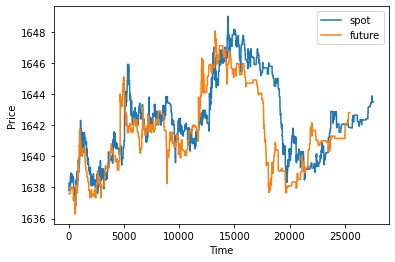

In [54]:
plt.plot(spotPrices, label="spot")
plt.plot(futurePrices, label="future")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc="upper right")
plt.show()

In [55]:
differences = [i for i in differences if i > 0]
# differences[6869] = 1.6924
# differences[6870] = 1.560
# differences[6866] = 1.49
# differences[6867] = 1.47

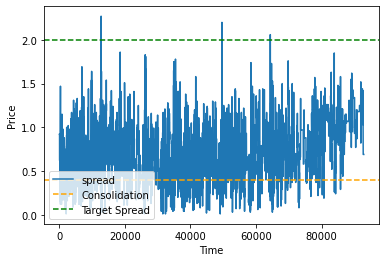

In [56]:
differences.pop(0)
plt.plot(differences, label="spread")
plt.axhline(y=0.4, color='orange', linestyle='--', label="Consolidation")
plt.axhline(y=2, color='green', linestyle='--', label="Target Spread")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc="lower left")
plt.show()

In [36]:
print(max(differences))
print(differences.index(1.8900000000001))

1.69


ValueError: 1.8900000000001 is not in list